In [1]:
import numpy as np
import pandas as pd
import h5py
import os
import glob
from datetime import datetime
from datetime import timedelta
from matplotlib import pyplot as plt
import matplotlib.lines as mlines
import matplotlib.dates as md
import warnings
from scipy.interpolate import interp2d
from scipy.interpolate import interp1d
from scipy.interpolate import make_interp_spline
warnings.filterwarnings('ignore')
import scipy.ndimage as ndimage
from matplotlib import cm
import matplotlib.lines as mlines
from sklearn.linear_model import LinearRegression
from matplotlib.transforms import ScaledTranslation
from matplotlib.colors import LogNorm
from sklearn import preprocessing
import seaborn as sns
from scipy.stats import pearsonr
from scipy import stats

In [2]:
def simple_read(path):
    with open(path) as f:
        first_line = f.readline()
        header_line = int(first_line[0:-2].split(",")[0])-1
        #all_lines = f.readlines()
    data = pd.read_csv(path, sep=',', skiprows=header_line)
    data.columns = [i.strip() for i in data.columns]
    #date = all_lines[5][0:10].split(',')
    #dt = datetime(int(date[0]), int(date[1]), int(date[2]))

    acc = 0
    boo = False
    for letter in path:
        if letter == '2':
            boo = True
        elif boo and letter == '0':
            acc -= 1
            break
        acc += 1
    #print(path[:acc+4], path[acc+4:acc+6], path[acc+6:acc+8])
    dt = datetime(int(path[acc:acc+4]), int(path[acc+4:acc+6]), int(path[acc+6:acc+8]))
    
    for column in data.keys():
        if 'Time' in column:
            data[column] = dt + pd.to_timedelta(data[column], unit='seconds')
    return data.replace(-999999, np.NaN)

In [3]:
DAY22 = simple_read('C:/Users/taiwoajayi/Documents/org_f(RH)/activate-mrg1_hu25_20220602_R0_L1_20230713T152528.ict')
start_index = np.where(DAY22["Time_Start"] == pd.to_datetime("2022-06-02 12:58:55"))
stop_index = np.where(DAY22["Time_Start"] == pd.to_datetime("2022-06-02 13:10:00"))

DAY22_subset = DAY22[start_index[0][0]:stop_index[0][0]]

# Print the modified subset dataframe
DAY22_subset


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,fRH550_RH20to80_ZIEMBA
5981,2022-06-02 12:58:55,2022-06-02 12:58:56,32.901061,-69.417865,115.705,0.314,1.592,-0.017,0.700,0.009,0.011,1.435
5982,2022-06-02 12:58:56,2022-06-02 12:58:57,32.901505,-69.416658,115.605,0.314,1.592,-0.017,0.700,0.009,0.011,1.235
5983,2022-06-02 12:58:57,2022-06-02 12:58:58,32.901950,-69.415451,114.775,0.314,1.592,-0.017,0.700,0.009,0.011,1.245
5984,2022-06-02 12:58:58,2022-06-02 12:58:59,32.902395,-69.414241,113.025,0.314,1.592,-0.017,0.700,0.009,0.011,1.325
5985,2022-06-02 12:58:59,2022-06-02 12:59:00,32.902841,-69.413027,110.485,0.314,1.592,-0.017,0.700,0.009,0.011,1.315
...,...,...,...,...,...,...,...,...,...,...,...,...
6641,2022-06-02 13:09:55,2022-06-02 13:09:56,32.856578,-69.176604,3810.860,0.437,0.139,-0.021,0.195,0.007,0.029,NaN
6642,2022-06-02 13:09:56,2022-06-02 13:09:57,32.856534,-69.174895,3811.410,0.437,0.139,-0.021,0.195,0.007,0.029,NaN
6643,2022-06-02 13:09:57,2022-06-02 13:09:58,32.856492,-69.173186,3812.340,0.437,0.139,-0.021,0.195,0.007,0.029,NaN
6644,2022-06-02 13:09:58,2022-06-02 13:09:59,32.856451,-69.171477,3813.680,0.437,0.139,-0.021,0.195,0.007,0.029,NaN


In [4]:
normal = (DAY22_subset['Chl_Ave_IsoK_STP_ZIEMBA'] + DAY22_subset['Org_Ave_IsoK_STP_ZIEMBA'] +
          DAY22_subset['SO4_Ave_IsoK_STP_ZIEMBA'] + DAY22_subset['NO3_Ave_IsoK_STP_ZIEMBA'] +
          DAY22_subset['NH4_Ave_IsoK_STP_ZIEMBA'])
# Create a new column 'mz44' by dividing 'mz44_Ave_IsoK_STP_ZIEMBA' by 'Org_Ave_IsoK_STP_ZIEMBA'
DAY22_subset['mz44'] = DAY22_subset['mz44_Ave_IsoK_STP_ZIEMBA'] / (DAY22_subset['Org_Ave_IsoK_STP_ZIEMBA']>=0.3)

# Specify the range of columns for division
start_col2 = 'Org_Ave_IsoK_STP_ZIEMBA'
stop_col2 = 'Chl_Ave_IsoK_STP_ZIEMBA'

# Perform division and assign the result to the specified range of columns
DAY22_subset.loc[:, start_col2:stop_col2] = DAY22_subset.loc[:, start_col2:stop_col2].div(normal, axis=0)
DAY22_subset['AMS'] = normal
DAY22_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,fRH550_RH20to80_ZIEMBA,mz44,AMS
5981,2022-06-02 12:58:55,2022-06-02 12:58:56,32.901061,-69.417865,115.705,0.120862,0.612779,-0.006543,0.269438,0.003464,0.011,1.435,0.011,2.598
5982,2022-06-02 12:58:56,2022-06-02 12:58:57,32.901505,-69.416658,115.605,0.120862,0.612779,-0.006543,0.269438,0.003464,0.011,1.235,0.011,2.598
5983,2022-06-02 12:58:57,2022-06-02 12:58:58,32.901950,-69.415451,114.775,0.120862,0.612779,-0.006543,0.269438,0.003464,0.011,1.245,0.011,2.598
5984,2022-06-02 12:58:58,2022-06-02 12:58:59,32.902395,-69.414241,113.025,0.120862,0.612779,-0.006543,0.269438,0.003464,0.011,1.325,0.011,2.598
5985,2022-06-02 12:58:59,2022-06-02 12:59:00,32.902841,-69.413027,110.485,0.120862,0.612779,-0.006543,0.269438,0.003464,0.011,1.315,0.011,2.598
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6641,2022-06-02 13:09:55,2022-06-02 13:09:56,32.856578,-69.176604,3810.860,0.577279,0.183620,-0.027741,0.257596,0.009247,0.029,NaN,0.029,0.757
6642,2022-06-02 13:09:56,2022-06-02 13:09:57,32.856534,-69.174895,3811.410,0.577279,0.183620,-0.027741,0.257596,0.009247,0.029,NaN,0.029,0.757
6643,2022-06-02 13:09:57,2022-06-02 13:09:58,32.856492,-69.173186,3812.340,0.577279,0.183620,-0.027741,0.257596,0.009247,0.029,NaN,0.029,0.757
6644,2022-06-02 13:09:58,2022-06-02 13:09:59,32.856451,-69.171477,3813.680,0.577279,0.183620,-0.027741,0.257596,0.009247,0.029,NaN,0.029,0.757


In [5]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY22_subset.GPS_Altitude_THORNHILL.min(), DAY22_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY22_subset['Bins'] = pd.cut(DAY22_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY22_subset_1000 = DAY22_subset.groupby('Bins').median()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY22_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY22_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_1000a = DAY22_subset_1000[start_index:stop_index]
DAY1000_subset_1000a


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,fRH550_RH20to80_ZIEMBA,mz44,AMS
Bins,,,,,,,,,,,,,,
"(105.985, 143.17]",2022-06-02 12:59:00.500,2022-06-02 12:59:01.500,32.903514,-69.411194,113.9000,0.120862,0.612779,-0.006543,0.269438,0.003464,0.011,1.3050,0.011,2.598
"(143.17, 180.354]",2022-06-02 12:59:09.500,2022-06-02 12:59:10.500,32.907635,-69.400132,160.4275,0.120862,0.612779,-0.006543,0.269438,0.003464,0.011,1.4475,0.011,2.598
"(180.354, 217.539]",2022-06-02 12:59:14.500,2022-06-02 12:59:15.500,32.910235,-69.394203,199.8250,0.120862,0.612779,-0.006543,0.269438,0.003464,0.011,1.2525,0.011,2.598
"(217.539, 254.723]",2022-06-02 12:59:20.500,2022-06-02 12:59:21.500,32.914346,-69.387850,234.4575,0.245490,0.546869,-0.022639,0.231694,-0.001415,0.039,1.2400,0.039,2.827
"(254.723, 291.908]",2022-06-02 12:59:26.000,2022-06-02 12:59:27.000,32.919085,-69.383209,276.6850,0.245490,0.546869,-0.022639,0.231694,-0.001415,0.039,1.2000,0.039,2.827
"(291.908, 329.092]",2022-06-02 12:59:32.000,2022-06-02 12:59:33.000,32.925125,-69.379793,304.7050,0.245490,0.546869,-0.022639,0.231694,-0.001415,0.039,1.3150,0.039,2.827
"(329.092, 366.277]",2022-06-02 12:59:37.000,2022-06-02 12:59:38.000,32.930599,-69.378595,345.2250,0.245490,0.546869,-0.022639,0.231694,-0.001415,0.039,1.0100,0.039,2.827
"(366.277, 403.461]",2022-06-02 12:59:40.500,2022-06-02 12:59:41.500,32.934451,-69.378665,383.8625,0.245490,0.546869,-0.022639,0.231694,-0.001415,0.039,1.3975,0.039,2.827
"(403.461, 440.646]",2022-06-02 12:59:45.500,2022-06-02 12:59:46.500,32.939847,-69.379819,420.9575,0.245490,0.546869,-0.022639,0.231694,-0.001415,0.039,1.4425,0.039,2.827


In [6]:

#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY22_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY22_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY3000_subset_3000a = DAY22_subset_1000[start_index:stop_index]
DAY3000_subset_3000a

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,fRH550_RH20to80_ZIEMBA,mz44,AMS
Bins,,,,,,,,,,,,,,
"(998.414, 1035.599]",2022-06-02 13:00:58.500,2022-06-02 13:00:59.500,32.926077,-69.440875,1020.465,0.254849,0.674916,-0.005351,0.074247,0.001338,0.030,1.4875,0.03,1.495
"(1035.599, 1072.783]",2022-06-02 13:01:03.000,2022-06-02 13:01:04.000,32.921032,-69.439333,1057.400,0.254849,0.674916,-0.005351,0.074247,0.001338,0.030,1.6700,0.03,1.495
"(1072.783, 1109.968]",2022-06-02 13:01:08.000,2022-06-02 13:01:09.000,32.915694,-69.436460,1089.620,0.254849,0.674916,-0.005351,0.074247,0.001338,0.030,1.1400,0.03,1.495
"(1109.968, 1147.152]",2022-06-02 13:01:13.000,2022-06-02 13:01:14.000,32.910879,-69.432361,1128.500,0.254849,0.674916,-0.005351,0.074247,0.001338,0.030,1.1700,0.03,1.495
"(1147.152, 1184.337]",2022-06-02 13:01:17.500,2022-06-02 13:01:18.500,32.907172,-69.427752,1167.055,0.254849,0.674916,-0.005351,0.074247,0.001338,0.030,1.2700,0.03,1.495
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(3266.672, 3303.856]",2022-06-02 13:06:03.500,2022-06-02 13:06:04.500,32.971773,-69.393744,3284.205,0.147872,0.248936,0.045745,0.571277,-0.013830,-0.029,NaN,-inf,0.940
"(3303.856, 3341.041]",2022-06-02 13:06:09.000,2022-06-02 13:06:10.000,32.970076,-69.401513,3322.510,0.147872,0.248936,0.045745,0.571277,-0.013830,-0.029,NaN,-inf,0.940
"(3341.041, 3378.225]",2022-06-02 13:06:13.500,2022-06-02 13:06:14.500,32.967769,-69.407456,3359.940,0.147872,0.248936,0.045745,0.571277,-0.013830,-0.029,NaN,-inf,0.940


In [7]:
DAY2 = simple_read('C:/Users/taiwoajayi/Documents/org_f(RH)/activate-mrg1_hu25_20220602_R0_L1_20230713T152528.ict')
start_index = np.where(DAY2["Time_Start"]==pd.to_datetime("2022-06-02 13:48:00"))
stop_index = np.where(DAY2["Time_Start"]==pd.to_datetime("2022-06-02 14:10:00"))
    
DAY2_subset = DAY2[start_index[0][0]:stop_index[0][0]]
DAY2_subset = DAY2_subset.replace(-888888, 0)
DAY2_subset


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,fRH550_RH20to80_ZIEMBA
8926,2022-06-02 13:48:00,2022-06-02 13:48:01,32.397719,-65.920473,1896.68,0.241,0.453,0.108,0.114,0.008,-0.049,0.99
8927,2022-06-02 13:48:01,2022-06-02 13:48:02,32.397400,-65.918900,1897.28,0.241,0.453,0.108,0.114,0.008,-0.049,0.99
8928,2022-06-02 13:48:02,2022-06-02 13:48:03,32.397079,-65.917327,1898.01,0.241,0.453,0.108,0.114,0.008,-0.049,0.82
8929,2022-06-02 13:48:03,2022-06-02 13:48:04,32.396758,-65.915754,1898.83,0.241,0.453,0.108,0.114,0.008,-0.049,0.82
8930,2022-06-02 13:48:04,2022-06-02 13:48:05,32.396435,-65.914182,1899.75,0.241,0.453,0.108,0.114,0.008,-0.049,1.02
...,...,...,...,...,...,...,...,...,...,...,...,...
10241,2022-06-02 14:09:55,2022-06-02 14:09:56,32.272869,-64.969777,2855.32,0.475,0.315,0.002,0.133,0.035,0.004,NaN
10242,2022-06-02 14:09:56,2022-06-02 14:09:57,32.273564,-64.970808,2861.28,0.475,0.315,0.002,0.133,0.035,0.004,NaN
10243,2022-06-02 14:09:57,2022-06-02 14:09:58,32.274234,-64.971861,2867.15,0.475,0.315,0.002,0.133,0.035,0.004,NaN
10244,2022-06-02 14:09:58,2022-06-02 14:09:59,32.274877,-64.972937,2872.99,0.475,0.315,0.002,0.133,0.035,0.004,NaN


In [8]:
normal = (DAY2_subset['Chl_Ave_IsoK_STP_ZIEMBA'] + DAY2_subset['Org_Ave_IsoK_STP_ZIEMBA'] +
          DAY2_subset['SO4_Ave_IsoK_STP_ZIEMBA'] + DAY2_subset['NO3_Ave_IsoK_STP_ZIEMBA'] +
          DAY2_subset['NH4_Ave_IsoK_STP_ZIEMBA'])
# Create a new column 'mz44' by dividing 'mz44_Ave_IsoK_STP_ZIEMBA' by 'Org_Ave_IsoK_STP_ZIEMBA'
DAY2_subset['mz44'] = DAY2_subset['mz44_Ave_IsoK_STP_ZIEMBA'] / (DAY2_subset['Org_Ave_IsoK_STP_ZIEMBA']>=0.3)

# Specify the range of columns for division
start_col2 = 'Org_Ave_IsoK_STP_ZIEMBA'
stop_col2 = 'Chl_Ave_IsoK_STP_ZIEMBA'

# Perform division and assign the result to the specified range of columns
DAY2_subset.loc[:, start_col2:stop_col2] = DAY2_subset.loc[:, start_col2:stop_col2].div(normal, axis=0)
DAY2_subset['AMS'] = normal
DAY2_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,fRH550_RH20to80_ZIEMBA,mz44,AMS
8926,2022-06-02 13:48:00,2022-06-02 13:48:01,32.397719,-65.920473,1896.68,0.260823,0.490260,0.116883,0.123377,0.008658,-0.049,0.99,-inf,0.924
8927,2022-06-02 13:48:01,2022-06-02 13:48:02,32.397400,-65.918900,1897.28,0.260823,0.490260,0.116883,0.123377,0.008658,-0.049,0.99,-inf,0.924
8928,2022-06-02 13:48:02,2022-06-02 13:48:03,32.397079,-65.917327,1898.01,0.260823,0.490260,0.116883,0.123377,0.008658,-0.049,0.82,-inf,0.924
8929,2022-06-02 13:48:03,2022-06-02 13:48:04,32.396758,-65.915754,1898.83,0.260823,0.490260,0.116883,0.123377,0.008658,-0.049,0.82,-inf,0.924
8930,2022-06-02 13:48:04,2022-06-02 13:48:05,32.396435,-65.914182,1899.75,0.260823,0.490260,0.116883,0.123377,0.008658,-0.049,1.02,-inf,0.924
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10241,2022-06-02 14:09:55,2022-06-02 14:09:56,32.272869,-64.969777,2855.32,0.494792,0.328125,0.002083,0.138542,0.036458,0.004,NaN,0.004,0.960
10242,2022-06-02 14:09:56,2022-06-02 14:09:57,32.273564,-64.970808,2861.28,0.494792,0.328125,0.002083,0.138542,0.036458,0.004,NaN,0.004,0.960
10243,2022-06-02 14:09:57,2022-06-02 14:09:58,32.274234,-64.971861,2867.15,0.494792,0.328125,0.002083,0.138542,0.036458,0.004,NaN,0.004,0.960
10244,2022-06-02 14:09:58,2022-06-02 14:09:59,32.274877,-64.972937,2872.99,0.494792,0.328125,0.002083,0.138542,0.036458,0.004,NaN,0.004,0.960


In [9]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY2_subset.GPS_Altitude_THORNHILL.min(), DAY2_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY2_subset['Bins'] = pd.cut(DAY2_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY2_subset_1000 = DAY2_subset.groupby('Bins').median()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY2_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY2_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_1000 = DAY2_subset_1000[start_index:stop_index]
DAY1000_subset_1000


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,fRH550_RH20to80_ZIEMBA,mz44,AMS
Bins,,,,,,,,,,,,,,
"(106.28, 134.006]",2022-06-02 13:58:08.000,2022-06-02 13:58:09.000,32.208306,-65.047757,122.4800,0.207111,0.592563,0.014843,0.273041,0.002829,-0.0050,1.5700,-0.005,2.4740
"(134.006, 161.732]",2022-06-02 13:58:49.000,2022-06-02 13:58:50.000,32.202678,-64.998075,149.2400,0.098868,0.665505,0.009582,0.201655,0.024390,0.0190,1.4800,inf,2.2960
"(161.732, 189.459]",2022-06-02 13:59:02.000,2022-06-02 13:59:03.000,32.210501,-64.983373,174.5650,0.098868,0.665505,0.009582,0.201655,0.024390,0.0190,1.5150,inf,2.2960
"(189.459, 217.185]",2022-06-02 13:57:08.000,2022-06-02 13:57:09.000,32.233247,-65.116465,202.3350,0.184973,0.605553,0.004900,0.220090,-0.015517,0.0620,1.4900,0.062,2.4490
"(217.185, 244.911]",2022-06-02 13:57:01.500,2022-06-02 13:57:02.500,32.235899,-65.124099,231.2250,0.184973,0.605553,0.004900,0.220090,-0.015517,0.0620,1.2900,0.062,2.4490
"(244.911, 272.637]",2022-06-02 13:58:08.000,2022-06-02 13:58:09.000,32.231922,-65.051973,260.1525,0.197729,0.598495,0.000249,0.215487,-0.011960,0.0400,1.3300,0.040,2.4740
"(272.637, 300.363]",2022-06-02 13:59:28.000,2022-06-02 13:59:29.000,32.235911,-64.973962,282.5850,0.210484,0.591437,-0.004402,0.210884,-0.008403,0.0180,1.6650,0.018,2.4990
"(300.363, 328.09]",2022-06-02 13:56:41.500,2022-06-02 13:56:42.500,32.243827,-65.148157,312.9625,-0.001660,0.767553,0.010250,0.239147,-0.002588,-0.0330,1.4575,-inf,1.8710
"(328.09, 355.816]",2022-06-02 13:56:33.500,2022-06-02 13:56:34.500,32.246800,-65.158144,339.6750,-0.052179,0.775148,0.015600,0.258203,0.003228,-0.0410,1.3900,-inf,1.8590


In [10]:

#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY2_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY2_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY3000_subset_3000 = DAY2_subset_1000[start_index:stop_index]
DAY3000_subset_3000

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,fRH550_RH20to80_ZIEMBA,mz44,AMS
Bins,,,,,,,,,,,,,,
"(993.518, 1021.245]",2022-06-02 14:02:19.500,2022-06-02 14:02:20.500,32.232227,-64.969261,1005.710,0.152929,0.612234,0.074650,0.147745,0.012442,-0.074,1.7675,-inf,1.929
"(1021.245, 1048.971]",2022-06-02 14:02:24.500,2022-06-02 14:02:25.500,32.235766,-64.963898,1036.645,0.152929,0.612234,0.074650,0.147745,0.012442,-0.074,1.8075,-inf,1.929
"(1048.971, 1076.697]",2022-06-02 14:02:31.500,2022-06-02 14:02:32.500,32.240709,-64.957500,1060.535,0.152929,0.612234,0.074650,0.147745,0.012442,-0.074,1.7075,-inf,1.929
"(1076.697, 1104.423]",2022-06-02 14:02:37.500,2022-06-02 14:02:38.500,32.247281,-64.953153,1089.530,0.152929,0.612234,0.074650,0.147745,0.012442,-0.074,1.3850,-inf,1.929
"(1104.423, 1132.149]",2022-06-02 14:02:43.000,2022-06-02 14:02:44.000,32.252841,-64.950287,1119.480,0.113208,0.693920,0.038435,0.162124,-0.007687,-0.068,1.5000,-inf,1.431
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(2712.543, 2740.269]",2022-06-02 14:09:22.000,2022-06-02 14:09:23.000,32.239725,-64.957045,2729.930,0.537884,0.279070,0.043511,0.132033,0.007502,0.020,1.0600,0.020,1.333
"(2740.269, 2767.995]",2022-06-02 14:09:30.500,2022-06-02 14:09:31.500,32.249106,-64.955641,2751.515,0.537884,0.279070,0.043511,0.132033,0.007502,0.020,0.8350,0.020,1.333
"(2767.995, 2795.721]",2022-06-02 14:09:38.000,2022-06-02 14:09:39.000,32.257341,-64.957280,2784.750,0.537884,0.279070,0.043511,0.132033,0.007502,0.020,0.8900,0.020,1.333


In [11]:
DAY2b = simple_read('C:/Users/taiwoajayi/Documents/org_f(RH)/activate-mrg1_hu25_20220602_R0_L2_20230713T152528.ict')
start_index = np.where(DAY2b["Time_Start"]==pd.to_datetime("2022-06-02 18:36:00"))
stop_index = np.where(DAY2b["Time_Start"]==pd.to_datetime("2022-06-02 18:53:00"))
DAY2b_subset = DAY2b[start_index[0][0]:stop_index[0][0]]
DAY2b_subset = DAY2b_subset.replace(-888888, 0)
DAY2b_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,fRH550_RH20to80_ZIEMBA
9180,2022-06-02 18:36:00,2022-06-02 18:36:01,32.312301,-65.009805,191.225,0.669,1.479,-0.051,0.057,0.028,-0.033,1.330
9181,2022-06-02 18:36:01,2022-06-02 18:36:02,32.312336,-65.010962,193.480,0.669,1.479,-0.051,0.057,0.028,-0.033,1.945
9182,2022-06-02 18:36:02,2022-06-02 18:36:03,32.312332,-65.012116,195.600,0.669,1.479,-0.051,0.057,0.028,-0.033,2.065
9183,2022-06-02 18:36:03,2022-06-02 18:36:04,32.312294,-65.013268,197.010,0.669,1.479,-0.051,0.057,0.028,-0.033,1.530
9184,2022-06-02 18:36:04,2022-06-02 18:36:05,32.312221,-65.014415,197.440,0.669,1.479,-0.051,0.057,0.028,-0.033,1.390
...,...,...,...,...,...,...,...,...,...,...,...,...
10195,2022-06-02 18:52:55,2022-06-02 18:52:56,32.205808,-64.977280,3678.610,0.836,0.176,0.024,-0.174,-0.012,0.066,NaN
10196,2022-06-02 18:52:56,2022-06-02 18:52:57,32.205215,-64.976028,3684.900,0.836,0.176,0.024,-0.174,-0.012,0.066,NaN
10197,2022-06-02 18:52:57,2022-06-02 18:52:58,32.204648,-64.974760,3691.340,0.836,0.176,0.024,-0.174,-0.012,0.066,NaN
10198,2022-06-02 18:52:58,2022-06-02 18:52:59,32.204104,-64.973478,3697.790,0.836,0.176,0.024,-0.174,-0.012,0.066,NaN


In [12]:
normal2 = (DAY2b_subset['Chl_Ave_IsoK_STP_ZIEMBA'] + DAY2b_subset['Org_Ave_IsoK_STP_ZIEMBA'] +
          DAY2b_subset['SO4_Ave_IsoK_STP_ZIEMBA'] + DAY2b_subset['NO3_Ave_IsoK_STP_ZIEMBA'] +
          DAY2b_subset['NH4_Ave_IsoK_STP_ZIEMBA'])
# Create a new column 'mz44' by dividing 'mz44_Ave_IsoK_STP_ZIEMBA' by 'Org_Ave_IsoK_STP_ZIEMBA'
DAY2b_subset['mz44'] = DAY2b_subset['mz44_Ave_IsoK_STP_ZIEMBA'] / (DAY2b_subset['Org_Ave_IsoK_STP_ZIEMBA']>=0.3)

# Specify the range of columns for division
start_col2 = 'Org_Ave_IsoK_STP_ZIEMBA'
stop_col2 = 'Chl_Ave_IsoK_STP_ZIEMBA'

# Perform division and assign the result to the specified range of columns
DAY2b_subset.loc[:, start_col2:stop_col2] = DAY2b_subset.loc[:, start_col2:stop_col2].div(normal2, axis=0)
DAY2b_subset['AMS'] = normal2
DAY2b_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,fRH550_RH20to80_ZIEMBA,mz44,AMS
9180,2022-06-02 18:36:00,2022-06-02 18:36:01,32.312301,-65.009805,191.225,0.306599,0.677819,-0.023373,0.026123,0.012832,-0.033,1.330,-0.033,2.182
9181,2022-06-02 18:36:01,2022-06-02 18:36:02,32.312336,-65.010962,193.480,0.306599,0.677819,-0.023373,0.026123,0.012832,-0.033,1.945,-0.033,2.182
9182,2022-06-02 18:36:02,2022-06-02 18:36:03,32.312332,-65.012116,195.600,0.306599,0.677819,-0.023373,0.026123,0.012832,-0.033,2.065,-0.033,2.182
9183,2022-06-02 18:36:03,2022-06-02 18:36:04,32.312294,-65.013268,197.010,0.306599,0.677819,-0.023373,0.026123,0.012832,-0.033,1.530,-0.033,2.182
9184,2022-06-02 18:36:04,2022-06-02 18:36:05,32.312221,-65.014415,197.440,0.306599,0.677819,-0.023373,0.026123,0.012832,-0.033,1.390,-0.033,2.182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10195,2022-06-02 18:52:55,2022-06-02 18:52:56,32.205808,-64.977280,3678.610,0.983529,0.207059,0.028235,-0.204706,-0.014118,0.066,NaN,0.066,0.850
10196,2022-06-02 18:52:56,2022-06-02 18:52:57,32.205215,-64.976028,3684.900,0.983529,0.207059,0.028235,-0.204706,-0.014118,0.066,NaN,0.066,0.850
10197,2022-06-02 18:52:57,2022-06-02 18:52:58,32.204648,-64.974760,3691.340,0.983529,0.207059,0.028235,-0.204706,-0.014118,0.066,NaN,0.066,0.850
10198,2022-06-02 18:52:58,2022-06-02 18:52:59,32.204104,-64.973478,3697.790,0.983529,0.207059,0.028235,-0.204706,-0.014118,0.066,NaN,0.066,0.850


In [13]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY2b_subset.GPS_Altitude_THORNHILL.min(), DAY2b_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY2b_subset['Bins'] = pd.cut(DAY2b_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY2b_subset_1000 = DAY2b_subset.groupby('Bins').median()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY2b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY2b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_1000b = DAY2b_subset_1000[start_index:stop_index]
DAY1000_subset_1000b

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,fRH550_RH20to80_ZIEMBA,mz44,AMS
Bins,,,,,,,,,,,,,,
"(132.5, 168.217]",2022-06-02 18:36:33.500,2022-06-02 18:36:34.500,32.294860,-65.039923,151.3675,0.236009,0.666811,0.048156,0.024729,0.024295,0.009,1.4150,0.009,2.305
"(168.217, 203.933]",2022-06-02 18:36:12.000,2022-06-02 18:36:13.000,32.310300,-65.023333,186.7200,0.306599,0.677819,-0.023373,0.026123,0.012832,-0.033,1.6250,-0.033,2.182
"(203.933, 239.65]",2022-06-02 18:37:02.000,2022-06-02 18:37:03.000,32.265793,-65.038849,214.3750,0.127354,0.650224,0.035426,0.166816,0.020179,0.068,1.2250,inf,2.230
"(239.65, 275.366]",2022-06-02 18:37:13.000,2022-06-02 18:37:14.000,32.254715,-65.034943,260.1500,0.127354,0.650224,0.035426,0.166816,0.020179,0.068,1.3900,inf,2.230
"(275.366, 311.083]",2022-06-02 18:37:24.000,2022-06-02 18:37:25.000,32.245041,-65.027102,289.4500,0.127354,0.650224,0.035426,0.166816,0.020179,0.068,1.5750,inf,2.230
"(311.083, 346.8]",2022-06-02 18:37:38.000,2022-06-02 18:37:39.000,32.237004,-65.011946,332.1600,0.031373,0.689076,0.010084,0.258263,0.011204,0.033,1.2150,inf,1.785
"(346.8, 382.516]",2022-06-02 18:37:53.000,2022-06-02 18:37:54.000,32.236630,-64.992675,362.9050,0.031373,0.689076,0.010084,0.258263,0.011204,0.033,1.3800,inf,1.785
"(382.516, 418.233]",2022-06-02 18:38:07.000,2022-06-02 18:38:08.000,32.244388,-64.977146,399.5450,0.151802,0.608387,0.005907,0.248080,-0.014176,0.003,1.4600,inf,1.693
"(418.233, 453.949]",2022-06-02 18:38:19.000,2022-06-02 18:38:20.000,32.255430,-64.969121,432.9000,0.151802,0.608387,0.005907,0.248080,-0.014176,0.003,1.5250,inf,1.693


In [14]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY2b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY2b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY3000_subset_3000b = DAY2b_subset_1000[start_index:stop_index]
DAY3000_subset_3000b

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,fRH550_RH20to80_ZIEMBA,mz44,AMS
Bins,,,,,,,,,,,,,,
"(989.698, 1025.415]",2022-06-02 18:41:23.000,2022-06-02 18:41:24.000,32.269872,-64.947192,1010.300,0.312242,0.601100,-0.008941,0.085970,0.009629,0.013,1.3200,0.013,1.454
"(1025.415, 1061.132]",2022-06-02 18:41:31.500,2022-06-02 18:41:32.500,32.278880,-64.945719,1046.060,0.068655,0.590846,0.019417,0.331484,-0.010402,-0.043,0.7700,-inf,1.442
"(1061.132, 1096.848]",2022-06-02 18:41:40.500,2022-06-02 18:41:41.500,32.288332,-64.947078,1080.155,0.068655,0.590846,0.019417,0.331484,-0.010402,-0.043,1.5425,-inf,1.442
"(1096.848, 1132.565]",2022-06-02 18:41:52.500,2022-06-02 18:41:53.500,32.299232,-64.954250,1111.995,0.068655,0.590846,0.019417,0.331484,-0.010402,-0.043,1.3800,-inf,1.442
"(1132.565, 1168.281]",2022-06-02 18:42:04.500,2022-06-02 18:42:05.500,32.306221,-64.966341,1150.090,0.160388,0.695371,0.039828,0.110872,-0.006459,0.035,1.4375,inf,0.929
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(3275.561, 3311.277]",2022-06-02 18:51:48.500,2022-06-02 18:51:49.500,32.275042,-65.008039,3293.650,0.323725,0.399113,-0.106430,0.325942,0.057650,-0.033,NaN,-inf,0.451
"(3311.277, 3346.994]",2022-06-02 18:51:54.000,2022-06-02 18:51:55.000,32.268640,-65.008712,3329.670,0.323725,0.399113,-0.106430,0.325942,0.057650,-0.033,NaN,-inf,0.451
"(3346.994, 3382.711]",2022-06-02 18:51:59.000,2022-06-02 18:52:00.000,32.262831,-65.009201,3366.390,0.425725,0.342391,0.012681,0.143116,0.076087,-0.021,NaN,-inf,0.552


In [15]:
DAY7 = simple_read('C:/Users/taiwoajayi/Documents/org_f(RH)/activate-mrg1_hu25_20220607_R0_L1_20230713T152529.ict')
start_index = np.where(DAY7["Time_Start"]==pd.to_datetime("2022-06-07 14:32:00"))
stop_index = np.where(DAY7["Time_Start"]==pd.to_datetime("2022-06-07 14:47:00"))
    
DAY7_subset =DAY7[start_index[0][0]:stop_index[0][0]]
DAY7_subset = DAY7_subset.replace(-888888, 0)
DAY7_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,fRH550_RH20to80_ZIEMBA
10397,2022-06-07 14:32:00,2022-06-07 14:32:01,32.250498,-64.999220,127.595,1.99,0.94,0.086,0.069,0.008,0.245,1.245
10398,2022-06-07 14:32:01,2022-06-07 14:32:02,32.249883,-64.998233,126.585,1.99,0.94,0.086,0.069,0.008,0.245,1.395
10399,2022-06-07 14:32:02,2022-06-07 14:32:03,32.249267,-64.997244,125.870,1.99,0.94,0.086,0.069,0.008,0.245,1.520
10400,2022-06-07 14:32:03,2022-06-07 14:32:04,32.248648,-64.996254,125.955,1.99,0.94,0.086,0.069,0.008,0.245,1.535
10401,2022-06-07 14:32:04,2022-06-07 14:32:05,32.248027,-64.995263,126.990,1.99,0.94,0.086,0.069,0.008,0.245,1.445
...,...,...,...,...,...,...,...,...,...,...,...,...
11292,2022-06-07 14:46:55,2022-06-07 14:46:56,32.255021,-64.999573,2800.660,0.46,0.33,0.027,-0.270,-0.026,0.072,NaN
11293,2022-06-07 14:46:56,2022-06-07 14:46:57,32.255098,-64.998248,2805.770,0.46,0.33,0.027,-0.270,-0.026,0.072,NaN
11294,2022-06-07 14:46:57,2022-06-07 14:46:58,32.255152,-64.996919,2810.920,0.46,0.33,0.027,-0.270,-0.026,0.072,NaN
11295,2022-06-07 14:46:58,2022-06-07 14:46:59,32.255184,-64.995588,2816.140,0.46,0.33,0.027,-0.270,-0.026,0.072,NaN


In [16]:
normal7 = (DAY7_subset['Chl_Ave_IsoK_STP_ZIEMBA'] + DAY7_subset['Org_Ave_IsoK_STP_ZIEMBA'] +
          DAY7_subset['SO4_Ave_IsoK_STP_ZIEMBA'] + DAY7_subset['NO3_Ave_IsoK_STP_ZIEMBA'] +
          DAY7_subset['NH4_Ave_IsoK_STP_ZIEMBA'])
# Create a new column 'mz44' by dividing 'mz44_Ave_IsoK_STP_ZIEMBA' by 'Org_Ave_IsoK_STP_ZIEMBA'
DAY7_subset['mz44'] = DAY7_subset['mz44_Ave_IsoK_STP_ZIEMBA'] /(DAY7_subset['Org_Ave_IsoK_STP_ZIEMBA']>=0.3)

# Specify the range of columns for division
start_col2 = 'Org_Ave_IsoK_STP_ZIEMBA'
stop_col2 = 'Chl_Ave_IsoK_STP_ZIEMBA'

# Perform division and assign the result to the specified range of columns
DAY7_subset.loc[:, start_col2:stop_col2] = DAY7_subset.loc[:, start_col2:stop_col2].div(normal7, axis=0)
DAY7_subset['AMS'] = normal7
DAY7_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,fRH550_RH20to80_ZIEMBA,mz44,AMS
10397,2022-06-07 14:32:00,2022-06-07 14:32:01,32.250498,-64.999220,127.595,0.643388,0.303912,0.027805,0.022308,0.002586,0.245,1.245,0.245,3.093
10398,2022-06-07 14:32:01,2022-06-07 14:32:02,32.249883,-64.998233,126.585,0.643388,0.303912,0.027805,0.022308,0.002586,0.245,1.395,0.245,3.093
10399,2022-06-07 14:32:02,2022-06-07 14:32:03,32.249267,-64.997244,125.870,0.643388,0.303912,0.027805,0.022308,0.002586,0.245,1.520,0.245,3.093
10400,2022-06-07 14:32:03,2022-06-07 14:32:04,32.248648,-64.996254,125.955,0.643388,0.303912,0.027805,0.022308,0.002586,0.245,1.535,0.245,3.093
10401,2022-06-07 14:32:04,2022-06-07 14:32:05,32.248027,-64.995263,126.990,0.643388,0.303912,0.027805,0.022308,0.002586,0.245,1.445,0.245,3.093
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11292,2022-06-07 14:46:55,2022-06-07 14:46:56,32.255021,-64.999573,2800.660,0.882917,0.633397,0.051823,-0.518234,-0.049904,0.072,NaN,0.072,0.521
11293,2022-06-07 14:46:56,2022-06-07 14:46:57,32.255098,-64.998248,2805.770,0.882917,0.633397,0.051823,-0.518234,-0.049904,0.072,NaN,0.072,0.521
11294,2022-06-07 14:46:57,2022-06-07 14:46:58,32.255152,-64.996919,2810.920,0.882917,0.633397,0.051823,-0.518234,-0.049904,0.072,NaN,0.072,0.521
11295,2022-06-07 14:46:58,2022-06-07 14:46:59,32.255184,-64.995588,2816.140,0.882917,0.633397,0.051823,-0.518234,-0.049904,0.072,NaN,0.072,0.521


In [17]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY7_subset.GPS_Altitude_THORNHILL.min(), DAY7_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY7_subset['Bins'] = pd.cut(DAY7_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY7_subset_1000 = DAY7_subset.groupby('Bins').median()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY7_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY7_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_7 = DAY7_subset_1000[start_index:stop_index]
DAY1000_subset_7


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,fRH550_RH20to80_ZIEMBA,mz44,AMS
Bins,,,,,,,,,,,,,,
"(125.87, 152.826]",2022-06-07 14:32:05.500,2022-06-07 14:32:06.500,32.247084,-64.993783,130.6300,0.643388,0.303912,0.027805,0.022308,0.002586,0.245,1.4400,0.245,3.093
"(152.826, 179.781]",2022-06-07 14:32:14.000,2022-06-07 14:32:15.000,32.241242,-64.985855,172.0250,0.608696,0.276398,0.022516,0.087474,0.004917,0.372,1.3750,0.372,3.864
"(179.781, 206.737]",2022-06-07 14:32:27.500,2022-06-07 14:32:28.500,32.229405,-64.976252,188.3900,0.608696,0.276398,0.022516,0.087474,0.004917,0.372,1.3775,0.372,3.864
"(206.737, 233.692]",2022-06-07 14:32:40.000,2022-06-07 14:32:41.000,32.216014,-64.972467,219.6400,0.541940,0.231022,0.020853,0.195408,0.010778,0.296,1.8400,0.296,4.268
"(233.692, 260.648]",2022-06-07 14:32:48.000,2022-06-07 14:32:49.000,32.207231,-64.973025,250.9800,0.541940,0.231022,0.020853,0.195408,0.010778,0.296,1.6250,0.296,4.268
"(260.648, 287.604]",2022-06-07 14:33:01.000,2022-06-07 14:33:02.000,32.193921,-64.978990,261.7850,0.541940,0.231022,0.020853,0.195408,0.010778,0.296,1.3650,0.296,4.268
"(287.604, 314.559]",2022-06-07 14:33:13.500,2022-06-07 14:33:14.500,32.184462,-64.990490,305.6750,0.549837,0.264625,0.015566,0.165704,0.004268,0.284,1.4500,0.284,3.983
"(314.559, 341.515]",2022-06-07 14:33:26.000,2022-06-07 14:33:27.000,32.179369,-65.005060,326.2850,0.549837,0.264625,0.015566,0.165704,0.004268,0.284,1.3750,0.284,3.983
"(341.515, 368.47]",2022-06-07 14:33:38.000,2022-06-07 14:33:39.000,32.179429,-65.019922,353.5650,0.565186,0.260015,0.014567,0.151493,0.008740,0.286,1.4150,0.286,4.119


In [18]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY7_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY7_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY7_subset_3000 = DAY7_subset_1000[start_index:stop_index]
DAY7_subset_3000

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,fRH550_RH20to80_ZIEMBA,mz44,AMS
Bins,,,,,,,,,,,,,,
"(1015.405, 1042.36]",2022-06-07 14:38:12.000,2022-06-07 14:38:13.000,32.229355,-65.062216,1030.120,0.432010,0.395250,0.023097,0.150943,-0.001301,0.143,1.6100,0.143,3.074
"(1042.36, 1069.316]",2022-06-07 14:38:21.000,2022-06-07 14:38:22.000,32.237006,-65.057784,1055.940,0.432010,0.395250,0.023097,0.150943,-0.001301,0.143,1.5850,0.143,3.074
"(1069.316, 1096.272]",2022-06-07 14:38:32.000,2022-06-07 14:38:33.000,32.245194,-65.050061,1084.140,0.432010,0.395250,0.023097,0.150943,-0.001301,0.143,1.6300,0.143,3.074
"(1096.272, 1123.227]",2022-06-07 14:38:42.500,2022-06-07 14:38:43.500,32.251219,-65.040481,1107.855,0.351597,0.424546,0.015654,0.195679,0.012523,0.132,1.5975,0.132,3.194
"(1123.227, 1150.183]",2022-06-07 14:38:52.000,2022-06-07 14:38:53.000,32.254166,-65.030077,1136.620,0.351597,0.424546,0.015654,0.195679,0.012523,0.132,1.4950,0.132,3.194
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(2659.696, 2686.652]",2022-06-07 14:46:31.000,2022-06-07 14:46:32.000,32.246810,-65.029401,2672.740,0.889796,0.273469,-0.104762,0.005442,-0.063946,0.079,NaN,0.079,0.735
"(2686.652, 2713.608]",2022-06-07 14:46:36.000,2022-06-07 14:46:37.000,32.249493,-65.023658,2699.640,0.882917,0.633397,0.051823,-0.518234,-0.049904,0.072,NaN,0.072,0.521
"(2713.608, 2740.563]",2022-06-07 14:46:41.000,2022-06-07 14:46:42.000,32.251676,-65.017607,2726.120,0.882917,0.633397,0.051823,-0.518234,-0.049904,0.072,NaN,0.072,0.521


In [19]:
DAY7b = simple_read('C:/Users/taiwoajayi/Documents/org_f(RH)/activate-mrg1_hu25_20220607_R0_L2_20230713T152529.ict')
start_index = np.where(DAY7b["Time_Start"]==pd.to_datetime("2022-06-07 19:08:00"))
stop_index = np.where(DAY7b["Time_Start"]==pd.to_datetime("2022-06-07 19:23:00"))
    
DAY7b_subset = DAY7b[start_index[0][0]:stop_index[0][0]]
DAY7b_subset = DAY7b_subset.replace(-888888, 0)
DAY7b_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,fRH550_RH20to80_ZIEMBA
10420,2022-06-07 19:08:00,2022-06-07 19:08:01,32.242823,-65.003952,133.320,0.875,0.562,0.050,0.120,0.004,0.077,NaN
10421,2022-06-07 19:08:01,2022-06-07 19:08:02,32.243085,-65.002775,133.120,0.875,0.562,0.050,0.120,0.004,0.077,NaN
10422,2022-06-07 19:08:02,2022-06-07 19:08:03,32.243347,-65.001596,132.930,0.875,0.562,0.050,0.120,0.004,0.077,NaN
10423,2022-06-07 19:08:03,2022-06-07 19:08:04,32.243610,-65.000416,132.720,0.875,0.562,0.050,0.120,0.004,0.077,NaN
10424,2022-06-07 19:08:04,2022-06-07 19:08:05,32.243873,-64.999235,132.595,0.875,0.562,0.050,0.120,0.004,0.077,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
11315,2022-06-07 19:22:55,2022-06-07 19:22:56,32.296480,-65.011792,3518.030,0.538,0.199,0.045,0.271,0.004,0.148,NaN
11316,2022-06-07 19:22:56,2022-06-07 19:22:57,32.296519,-65.013093,3524.890,0.538,0.199,0.045,0.271,0.004,0.148,NaN
11317,2022-06-07 19:22:57,2022-06-07 19:22:58,32.296518,-65.014396,3531.840,0.538,0.199,0.045,0.271,0.004,0.148,NaN
11318,2022-06-07 19:22:58,2022-06-07 19:22:59,32.296479,-65.015699,3538.850,0.538,0.199,0.045,0.271,0.004,0.148,NaN


In [20]:
normal7b = (DAY7b_subset['Chl_Ave_IsoK_STP_ZIEMBA'] + DAY7b_subset['Org_Ave_IsoK_STP_ZIEMBA'] +
          DAY7b_subset['SO4_Ave_IsoK_STP_ZIEMBA'] + DAY7b_subset['NO3_Ave_IsoK_STP_ZIEMBA'] +
          DAY7b_subset['NH4_Ave_IsoK_STP_ZIEMBA'])
# Create a new column 'mz44' by dividing 'mz44_Ave_IsoK_STP_ZIEMBA' by 'Org_Ave_IsoK_STP_ZIEMBA'
DAY7b_subset['mz44'] = DAY7b_subset['mz44_Ave_IsoK_STP_ZIEMBA'] /(DAY7b_subset['Org_Ave_IsoK_STP_ZIEMBA']>=0.3)
# Specify the range of columns for division
start_col2 = 'Org_Ave_IsoK_STP_ZIEMBA'
stop_col2 = 'Chl_Ave_IsoK_STP_ZIEMBA'

# Perform division and assign the result to the specified range of columns
DAY7b_subset.loc[:, start_col2:stop_col2] = DAY7b_subset.loc[:, start_col2:stop_col2].div(normal7b, axis=0)
DAY7b_subset['AMS'] = normal7b
DAY7b_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,fRH550_RH20to80_ZIEMBA,mz44,AMS
10420,2022-06-07 19:08:00,2022-06-07 19:08:01,32.242823,-65.003952,133.320,0.543141,0.348852,0.031037,0.074488,0.002483,0.077,NaN,0.077,1.611
10421,2022-06-07 19:08:01,2022-06-07 19:08:02,32.243085,-65.002775,133.120,0.543141,0.348852,0.031037,0.074488,0.002483,0.077,NaN,0.077,1.611
10422,2022-06-07 19:08:02,2022-06-07 19:08:03,32.243347,-65.001596,132.930,0.543141,0.348852,0.031037,0.074488,0.002483,0.077,NaN,0.077,1.611
10423,2022-06-07 19:08:03,2022-06-07 19:08:04,32.243610,-65.000416,132.720,0.543141,0.348852,0.031037,0.074488,0.002483,0.077,NaN,0.077,1.611
10424,2022-06-07 19:08:04,2022-06-07 19:08:05,32.243873,-64.999235,132.595,0.543141,0.348852,0.031037,0.074488,0.002483,0.077,NaN,0.077,1.611
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11315,2022-06-07 19:22:55,2022-06-07 19:22:56,32.296480,-65.011792,3518.030,0.508988,0.188269,0.042573,0.256386,0.003784,0.148,NaN,0.148,1.057
11316,2022-06-07 19:22:56,2022-06-07 19:22:57,32.296519,-65.013093,3524.890,0.508988,0.188269,0.042573,0.256386,0.003784,0.148,NaN,0.148,1.057
11317,2022-06-07 19:22:57,2022-06-07 19:22:58,32.296518,-65.014396,3531.840,0.508988,0.188269,0.042573,0.256386,0.003784,0.148,NaN,0.148,1.057
11318,2022-06-07 19:22:58,2022-06-07 19:22:59,32.296479,-65.015699,3538.850,0.508988,0.188269,0.042573,0.256386,0.003784,0.148,NaN,0.148,1.057


In [21]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY7b_subset.GPS_Altitude_THORNHILL.min(), DAY7b_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY7b_subset['Bins'] = pd.cut(DAY7b_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY7b_subset_1000 = DAY7b_subset.groupby('Bins').median()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY7b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY7b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_7b = DAY7b_subset_1000[start_index:stop_index]
DAY1000_subset_7b

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,fRH550_RH20to80_ZIEMBA,mz44,AMS
Bins,,,,,,,,,,,,,,
"(132.595, 166.728]",2022-06-07 19:08:09.000,2022-06-07 19:08:10.000,32.245348,-64.993377,138.9650,0.543141,0.348852,0.031037,0.074488,0.002483,0.077,NaN,0.077,1.611
"(166.728, 200.861]",2022-06-07 19:08:21.500,2022-06-07 19:08:22.500,32.252398,-64.980762,183.5400,0.565343,0.328728,0.078296,0.033391,-0.005757,0.077,NaN,0.077,1.737
"(200.861, 234.994]",2022-06-07 19:08:31.500,2022-06-07 19:08:32.500,32.261138,-64.974323,217.5125,0.565343,0.328728,0.078296,0.033391,-0.005757,0.077,NaN,0.077,1.737
"(234.994, 269.127]",2022-06-07 19:08:42.500,2022-06-07 19:08:43.500,32.272447,-64.972235,251.5325,0.565343,0.328728,0.078296,0.033391,-0.005757,0.077,NaN,0.077,1.737
"(269.127, 303.26]",2022-06-07 19:08:51.500,2022-06-07 19:08:52.500,32.281722,-64.974383,286.8050,0.496990,0.300334,0.011371,0.161873,0.029431,0.066,NaN,0.066,1.495
"(303.26, 337.393]",2022-06-07 19:09:01.500,2022-06-07 19:09:02.500,32.290928,-64.980598,318.2300,0.496990,0.300334,0.011371,0.161873,0.029431,0.066,NaN,0.066,1.495
"(337.393, 371.526]",2022-06-07 19:09:12.000,2022-06-07 19:09:13.000,32.298341,-64.990692,354.8600,0.496990,0.300334,0.011371,0.161873,0.029431,0.066,NaN,0.066,1.495
"(371.526, 405.659]",2022-06-07 19:09:23.500,2022-06-07 19:09:24.500,32.302729,-65.004544,389.4000,0.588634,0.263816,0.006778,0.144943,-0.004171,0.141,NaN,0.141,1.918
"(405.659, 439.792]",2022-06-07 19:09:35.000,2022-06-07 19:09:36.000,32.302622,-65.019577,421.5550,0.588634,0.263816,0.006778,0.144943,-0.004171,0.141,NaN,0.141,1.918


In [22]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY7b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY7b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY7b_subset_3000 = DAY7b_subset_1000[start_index:stop_index]
DAY7b_subset_3000

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,fRH550_RH20to80_ZIEMBA,mz44,AMS
Bins,,,,,,,,,,,,,,
"(985.921, 1020.054]",2022-06-07 19:12:28.500,2022-06-07 19:12:29.500,32.296267,-64.998305,1003.240,0.563830,0.428369,0.017021,-0.006383,-0.002837,0.184,NaN,0.184,2.820
"(1020.054, 1054.187]",2022-06-07 19:12:38.500,2022-06-07 19:12:39.500,32.300110,-65.010330,1036.910,0.563830,0.428369,0.017021,-0.006383,-0.002837,0.184,NaN,0.184,2.820
"(1054.187, 1088.32]",2022-06-07 19:12:48.000,2022-06-07 19:12:49.000,32.300666,-65.022512,1072.330,0.456305,0.379765,0.024927,0.134897,0.004106,0.239,NaN,0.239,3.410
"(1088.32, 1122.453]",2022-06-07 19:12:58.500,2022-06-07 19:12:59.500,32.297754,-65.035518,1104.765,0.456305,0.379765,0.024927,0.134897,0.004106,0.239,NaN,0.239,3.410
"(1122.453, 1156.586]",2022-06-07 19:13:10.500,2022-06-07 19:13:11.500,32.290292,-65.048118,1140.005,0.456305,0.379765,0.024927,0.134897,0.004106,0.239,NaN,0.239,3.410
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(3306.969, 3341.102]",2022-06-07 19:22:24.000,2022-06-07 19:22:25.000,32.278740,-64.979743,3325.470,0.365105,0.158320,-0.059774,0.537964,-0.001616,0.000,NaN,NaN,0.619
"(3341.102, 3375.235]",2022-06-07 19:22:29.500,2022-06-07 19:22:30.500,32.283576,-64.983815,3359.530,0.365105,0.158320,-0.059774,0.537964,-0.001616,0.000,NaN,NaN,0.619
"(3375.235, 3409.368]",2022-06-07 19:22:35.000,2022-06-07 19:22:36.000,32.287903,-64.988645,3393.950,0.365105,0.158320,-0.059774,0.537964,-0.001616,0.000,NaN,NaN,0.619


In [23]:
DAY8 = simple_read('C:/Users/taiwoajayi/Documents/org_f(RH)/activate-mrg1_hu25_20220608_R0_L2_20230713T152529.ict')
start_index = np.where(DAY8["Time_Start"]==pd.to_datetime("2022-06-08 20:30:00"))
stop_index = np.where(DAY8["Time_Start"]==pd.to_datetime("2022-06-08 20:45:00"))
    
DAY8_subset = DAY8[start_index[0][0]:stop_index[0][0]]
DAY8_subset = DAY8_subset.replace(-888888, 0)
DAY8_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,fRH550_RH20to80_ZIEMBA
10668,2022-06-08 20:30:00,2022-06-08 20:30:01,32.267080,-64.998961,152.725,1.050,1.150,0.088,0.330,0.037,0.169,0.745
10669,2022-06-08 20:30:01,2022-06-08 20:30:02,32.268158,-64.999178,153.350,1.050,1.150,0.088,0.330,0.037,0.169,0.730
10670,2022-06-08 20:30:02,2022-06-08 20:30:03,32.269234,-64.999434,153.870,1.050,1.150,0.088,0.330,0.037,0.169,0.855
10671,2022-06-08 20:30:03,2022-06-08 20:30:04,32.270310,-64.999724,154.255,1.050,1.150,0.088,0.330,0.037,0.169,1.015
10672,2022-06-08 20:30:04,2022-06-08 20:30:05,32.271382,-65.000051,154.510,1.050,1.150,0.088,0.330,0.037,0.169,1.050
...,...,...,...,...,...,...,...,...,...,...,...,...
11563,2022-06-08 20:44:55,2022-06-08 20:44:56,32.251172,-65.086081,3838.620,0.153,0.308,0.063,0.185,-0.003,0.050,NaN
11564,2022-06-08 20:44:56,2022-06-08 20:44:57,32.250122,-65.085465,3847.170,0.153,0.308,0.063,0.185,-0.003,0.050,NaN
11565,2022-06-08 20:44:57,2022-06-08 20:44:58,32.249088,-65.084808,3855.660,0.153,0.308,0.063,0.185,-0.003,0.050,NaN
11566,2022-06-08 20:44:58,2022-06-08 20:44:59,32.248074,-65.084107,3864.100,0.153,0.308,0.063,0.185,-0.003,0.050,NaN


In [24]:
normal8 = (DAY8_subset['Chl_Ave_IsoK_STP_ZIEMBA'] + DAY8_subset['Org_Ave_IsoK_STP_ZIEMBA'] +
          DAY8_subset['SO4_Ave_IsoK_STP_ZIEMBA'] + DAY8_subset['NO3_Ave_IsoK_STP_ZIEMBA'] +
          DAY8_subset['NH4_Ave_IsoK_STP_ZIEMBA'])
# Create a new column 'mz44' by dividing 'mz44_Ave_IsoK_STP_ZIEMBA' by 'Org_Ave_IsoK_STP_ZIEMBA'
DAY8_subset['mz44'] = DAY8_subset['mz44_Ave_IsoK_STP_ZIEMBA'] / (DAY8_subset['Org_Ave_IsoK_STP_ZIEMBA']>=0.3)
# Specify the range of columns for division
start_col2 = 'Org_Ave_IsoK_STP_ZIEMBA'
stop_col2 = 'Chl_Ave_IsoK_STP_ZIEMBA'

# Perform division and assign the result to the specified range of columns
DAY8_subset.loc[:, start_col2:stop_col2] = DAY8_subset.loc[:, start_col2:stop_col2].div(normal8, axis=0)
DAY8_subset['AMS'] = normal8
DAY8_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,fRH550_RH20to80_ZIEMBA,mz44,AMS
10668,2022-06-08 20:30:00,2022-06-08 20:30:01,32.267080,-64.998961,152.725,0.395480,0.433145,0.033145,0.124294,0.013936,0.169,0.745,0.169,2.655
10669,2022-06-08 20:30:01,2022-06-08 20:30:02,32.268158,-64.999178,153.350,0.395480,0.433145,0.033145,0.124294,0.013936,0.169,0.730,0.169,2.655
10670,2022-06-08 20:30:02,2022-06-08 20:30:03,32.269234,-64.999434,153.870,0.395480,0.433145,0.033145,0.124294,0.013936,0.169,0.855,0.169,2.655
10671,2022-06-08 20:30:03,2022-06-08 20:30:04,32.270310,-64.999724,154.255,0.395480,0.433145,0.033145,0.124294,0.013936,0.169,1.015,0.169,2.655
10672,2022-06-08 20:30:04,2022-06-08 20:30:05,32.271382,-65.000051,154.510,0.395480,0.433145,0.033145,0.124294,0.013936,0.169,1.050,0.169,2.655
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11563,2022-06-08 20:44:55,2022-06-08 20:44:56,32.251172,-65.086081,3838.620,0.216714,0.436261,0.089235,0.262040,-0.004249,0.050,NaN,inf,0.706
11564,2022-06-08 20:44:56,2022-06-08 20:44:57,32.250122,-65.085465,3847.170,0.216714,0.436261,0.089235,0.262040,-0.004249,0.050,NaN,inf,0.706
11565,2022-06-08 20:44:57,2022-06-08 20:44:58,32.249088,-65.084808,3855.660,0.216714,0.436261,0.089235,0.262040,-0.004249,0.050,NaN,inf,0.706
11566,2022-06-08 20:44:58,2022-06-08 20:44:59,32.248074,-65.084107,3864.100,0.216714,0.436261,0.089235,0.262040,-0.004249,0.050,NaN,inf,0.706


In [25]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY8_subset.GPS_Altitude_THORNHILL.min(), DAY8_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY8_subset['Bins'] = pd.cut(DAY8_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY8_subset_1000 = DAY8_subset.groupby('Bins').median()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY8_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY8_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_8 = DAY8_subset_1000[start_index:stop_index]
DAY1000_subset_8


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,fRH550_RH20to80_ZIEMBA,mz44,AMS
Bins,,,,,,,,,,,,,,
"(147.455, 184.705]",2022-06-08 20:30:28.000,2022-06-08 20:30:29.000,32.293626,-65.017848,154.5400,0.434934,0.473664,0.014717,0.073199,0.003486,0.142,0.9050,0.142,2.582
"(184.705, 221.955]",2022-06-08 20:31:07.000,2022-06-08 20:31:08.000,32.300051,-65.066294,198.9850,0.411602,0.590239,0.000460,0.001381,-0.003683,0.102,1.1000,0.102,2.172
"(221.955, 259.205]",2022-06-08 20:31:21.500,2022-06-08 20:31:22.500,32.291698,-65.080461,242.1600,0.411602,0.590239,0.000460,0.001381,-0.003683,0.102,1.0675,0.102,2.172
"(259.205, 296.455]",2022-06-08 20:31:32.500,2022-06-08 20:31:33.500,32.282742,-65.087275,278.0025,0.430960,0.639274,0.017678,-0.087434,-0.000478,0.076,0.8900,0.076,2.093
"(296.455, 333.705]",2022-06-08 20:31:44.000,2022-06-08 20:31:45.000,32.272093,-65.089858,314.4600,0.430960,0.639274,0.017678,-0.087434,-0.000478,0.076,0.8050,0.076,2.093
"(333.705, 370.955]",2022-06-08 20:31:54.500,2022-06-08 20:31:55.500,32.262326,-65.088323,352.5375,0.430960,0.639274,0.017678,-0.087434,-0.000478,0.076,1.0400,0.076,2.093
"(370.955, 408.205]",2022-06-08 20:32:04.500,2022-06-08 20:32:05.500,32.253920,-65.083280,389.1225,0.367757,0.641121,0.014019,-0.008879,-0.014019,0.124,0.7975,0.124,2.140
"(408.205, 445.455]",2022-06-08 20:32:15.500,2022-06-08 20:32:16.500,32.246596,-65.074434,425.9075,0.367757,0.641121,0.014019,-0.008879,-0.014019,0.124,0.9375,0.124,2.140
"(445.455, 482.705]",2022-06-08 20:32:27.000,2022-06-08 20:32:28.000,32.241922,-65.062468,462.3600,0.216404,0.651993,0.027340,0.103336,0.000927,0.095,1.0750,0.095,2.158


In [26]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY8_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY8_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY8_subset_3000 = DAY8_subset_1000[start_index:stop_index]
DAY8_subset_3000

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,fRH550_RH20to80_ZIEMBA,mz44,AMS
Bins,,,,,,,,,,,,,,
"(1004.206, 1041.456]",2022-06-08 20:35:22.000,2022-06-08 20:35:23.000,32.281187,-65.081965,1020.120,NaN,NaN,NaN,NaN,NaN,NaN,1.5250,NaN,NaN
"(1041.456, 1078.706]",2022-06-08 20:35:35.000,2022-06-08 20:35:36.000,32.268765,-65.078655,1060.190,0.391133,0.475858,0.009414,0.104160,0.019435,0.161,1.4300,0.161,3.293
"(1078.706, 1115.956]",2022-06-08 20:35:48.500,2022-06-08 20:35:49.500,32.257159,-65.071069,1096.685,0.391133,0.475858,0.009414,0.104160,0.019435,0.161,1.2625,0.161,3.293
"(1115.956, 1153.206]",2022-06-08 20:36:00.500,2022-06-08 20:36:01.500,32.249873,-65.060165,1134.755,0.391962,0.508416,0.009275,0.092065,-0.001718,0.120,1.1525,0.120,2.911
"(1153.206, 1190.456]",2022-06-08 20:36:12.500,2022-06-08 20:36:13.500,32.247776,-65.046364,1173.080,0.391962,0.508416,0.009275,0.092065,-0.001718,0.120,1.4625,0.120,2.911
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(3276.459, 3313.709]",2022-06-08 20:43:51.000,2022-06-08 20:43:52.000,32.296100,-65.043959,3293.800,0.285347,0.650386,-0.074550,0.105398,0.033419,0.028,NaN,inf,0.389
"(3313.709, 3350.959]",2022-06-08 20:43:55.500,2022-06-08 20:43:56.500,32.297077,-65.049657,3332.045,0.285347,0.650386,-0.074550,0.105398,0.033419,0.028,NaN,inf,0.389
"(3350.959, 3388.209]",2022-06-08 20:44:00.000,2022-06-08 20:44:01.000,32.297241,-65.055479,3370.540,0.525959,0.514673,-0.124153,0.040632,0.042889,0.004,NaN,inf,0.443


In [27]:
DAY10 = simple_read('C:/Users/taiwoajayi/Documents/org_f(RH)/activate-mrg1_hu25_20220610_R0_L1_20230713T152530.ict')
start_index = np.where(DAY10["Time_Start"]==pd.to_datetime("2022-06-10 15:17:00"))
stop_index = np.where(DAY10["Time_Start"]==pd.to_datetime("2022-06-10 15:25:00"))
    
DAY10_subset = DAY10[start_index[0][0]:stop_index[0][0]]
DAY10_subset = DAY10_subset.replace(-888888, 0)
DAY10_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,fRH550_RH20to80_ZIEMBA
10616,2022-06-10 15:17:00,2022-06-10 15:17:01,32.206691,-64.996969,122.040,0.311,0.857,0.124,-0.052,-0.006,-0.023,NaN
10617,2022-06-10 15:17:01,2022-06-10 15:17:02,32.207809,-64.997169,122.105,0.311,0.857,0.124,-0.052,-0.006,-0.023,NaN
10618,2022-06-10 15:17:02,2022-06-10 15:17:03,32.208928,-64.997370,122.170,0.311,0.857,0.124,-0.052,-0.006,-0.023,NaN
10619,2022-06-10 15:17:03,2022-06-10 15:17:04,32.210048,-64.997569,122.240,0.311,0.857,0.124,-0.052,-0.006,-0.023,NaN
10620,2022-06-10 15:17:04,2022-06-10 15:17:05,32.211167,-64.997768,122.315,0.311,0.857,0.124,-0.052,-0.006,-0.023,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
11091,2022-06-10 15:24:55,2022-06-10 15:24:56,32.207088,-65.031191,3540.260,0.243,0.189,0.017,-0.335,-0.018,0.027,NaN
11092,2022-06-10 15:24:56,2022-06-10 15:24:57,32.207061,-65.029663,3546.970,0.243,0.189,0.017,-0.335,-0.018,0.027,NaN
11093,2022-06-10 15:24:57,2022-06-10 15:24:58,32.207068,-65.028134,3553.620,0.243,0.189,0.017,-0.335,-0.018,0.027,NaN
11094,2022-06-10 15:24:58,2022-06-10 15:24:59,32.207109,-65.026603,3560.200,0.243,0.189,0.017,-0.335,-0.018,0.027,NaN


In [28]:
normal10 = (DAY10_subset['Chl_Ave_IsoK_STP_ZIEMBA'] + DAY10_subset['Org_Ave_IsoK_STP_ZIEMBA'] +
          DAY10_subset['SO4_Ave_IsoK_STP_ZIEMBA'] + DAY10_subset['NO3_Ave_IsoK_STP_ZIEMBA'] +
          DAY10_subset['NH4_Ave_IsoK_STP_ZIEMBA'])
# Create a new column 'mz44' by dividing 'mz44_Ave_IsoK_STP_ZIEMBA' by 'Org_Ave_IsoK_STP_ZIEMBA'
DAY10_subset['mz44'] = DAY10_subset['mz44_Ave_IsoK_STP_ZIEMBA'] / (DAY10_subset['Org_Ave_IsoK_STP_ZIEMBA']>=0.3)

# Specify the range of columns for division
start_col2 = 'Org_Ave_IsoK_STP_ZIEMBA'
stop_col2 = 'Chl_Ave_IsoK_STP_ZIEMBA'

# Perform division and assign the result to the specified range of columns
DAY10_subset.loc[:, start_col2:stop_col2] = DAY10_subset.loc[:, start_col2:stop_col2].div(normal10, axis=0)
DAY10_subset['AMS'] = normal10
DAY10_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,fRH550_RH20to80_ZIEMBA,mz44,AMS
10616,2022-06-10 15:17:00,2022-06-10 15:17:01,32.206691,-64.996969,122.040,0.252026,0.694489,0.100486,-0.042139,-0.004862,-0.023,NaN,-0.023,1.234
10617,2022-06-10 15:17:01,2022-06-10 15:17:02,32.207809,-64.997169,122.105,0.252026,0.694489,0.100486,-0.042139,-0.004862,-0.023,NaN,-0.023,1.234
10618,2022-06-10 15:17:02,2022-06-10 15:17:03,32.208928,-64.997370,122.170,0.252026,0.694489,0.100486,-0.042139,-0.004862,-0.023,NaN,-0.023,1.234
10619,2022-06-10 15:17:03,2022-06-10 15:17:04,32.210048,-64.997569,122.240,0.252026,0.694489,0.100486,-0.042139,-0.004862,-0.023,NaN,-0.023,1.234
10620,2022-06-10 15:17:04,2022-06-10 15:17:05,32.211167,-64.997768,122.315,0.252026,0.694489,0.100486,-0.042139,-0.004862,-0.023,NaN,-0.023,1.234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11091,2022-06-10 15:24:55,2022-06-10 15:24:56,32.207088,-65.031191,3540.260,2.531250,1.968750,0.177083,-3.489583,-0.187500,0.027,NaN,inf,0.096
11092,2022-06-10 15:24:56,2022-06-10 15:24:57,32.207061,-65.029663,3546.970,2.531250,1.968750,0.177083,-3.489583,-0.187500,0.027,NaN,inf,0.096
11093,2022-06-10 15:24:57,2022-06-10 15:24:58,32.207068,-65.028134,3553.620,2.531250,1.968750,0.177083,-3.489583,-0.187500,0.027,NaN,inf,0.096
11094,2022-06-10 15:24:58,2022-06-10 15:24:59,32.207109,-65.026603,3560.200,2.531250,1.968750,0.177083,-3.489583,-0.187500,0.027,NaN,inf,0.096


In [29]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY10_subset.GPS_Altitude_THORNHILL.min(), DAY10_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY10_subset['Bins'] = pd.cut(DAY10_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY10_subset_1000 = DAY10_subset.groupby('Bins').median()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY10_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY10_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_10 = DAY10_subset_1000[start_index:stop_index]
DAY1000_subset_10

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,fRH550_RH20to80_ZIEMBA,mz44,AMS
Bins,,,,,,,,,,,,,,
"(122.04, 156.487]",2022-06-10 15:17:25.000,2022-06-10 15:17:26.000,32.234690,-65.001976,123.7050,0.249079,0.669860,0.017686,0.042741,0.020634,-0.0100,NaN,-0.010,1.3570
"(156.487, 190.934]",2022-06-10 15:17:52.500,2022-06-10 15:17:53.500,32.265725,-65.007644,173.7850,0.165815,0.651902,0.015900,0.173765,-0.007382,-0.0070,NaN,-inf,1.7610
"(190.934, 225.381]",2022-06-10 15:17:58.000,2022-06-10 15:17:59.000,32.271651,-65.009660,209.2900,0.165815,0.651902,0.015900,0.173765,-0.007382,-0.0070,NaN,-inf,1.7610
"(225.381, 259.828]",2022-06-10 15:18:03.000,2022-06-10 15:18:04.000,32.276788,-65.012279,244.1150,0.165815,0.651902,0.015900,0.173765,-0.007382,-0.0070,NaN,-inf,1.7610
"(259.828, 294.274]",2022-06-10 15:18:07.500,2022-06-10 15:18:08.500,32.281187,-65.015215,277.9725,0.165815,0.651902,0.015900,0.173765,-0.007382,-0.0070,NaN,-inf,1.7610
"(294.274, 328.721]",2022-06-10 15:18:12.000,2022-06-10 15:18:13.000,32.285285,-65.018704,312.6600,0.165815,0.651902,0.015900,0.173765,-0.007382,-0.0070,NaN,-inf,1.7610
"(328.721, 363.168]",2022-06-10 15:18:16.500,2022-06-10 15:18:17.500,32.288983,-65.022752,349.4500,0.165815,0.651902,0.015900,0.173765,-0.007382,-0.0070,NaN,-inf,1.7610
"(363.168, 397.615]",2022-06-10 15:18:20.500,2022-06-10 15:18:21.500,32.291912,-65.026738,383.6350,0.182907,0.637029,0.003459,0.179098,-0.002493,0.0035,NaN,-inf,1.7155
"(397.615, 432.062]",2022-06-10 15:18:24.500,2022-06-10 15:18:25.500,32.294488,-65.031034,417.9100,0.200000,0.622156,-0.008982,0.184431,0.002395,0.0140,NaN,0.014,1.6700


In [30]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY10_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY10_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY10_subset_3000 = DAY10_subset_1000[start_index:stop_index]
DAY10_subset_3000

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,fRH550_RH20to80_ZIEMBA,mz44,AMS
Bins,,,,,,,,,,,,,,
"(983.212, 1017.659]",2022-06-10 15:19:33.500,2022-06-10 15:19:34.500,32.275745,-65.106980,1002.010,0.289825,0.547368,-0.012632,0.171930,0.003509,0.093,NaN,0.093,2.850
"(1017.659, 1052.106]",2022-06-10 15:19:37.500,2022-06-10 15:19:38.500,32.271569,-65.108848,1036.915,0.289825,0.547368,-0.012632,0.171930,0.003509,0.093,NaN,0.093,2.850
"(1052.106, 1086.553]",2022-06-10 15:19:41.500,2022-06-10 15:19:42.500,32.267229,-65.110177,1072.325,0.289825,0.547368,-0.012632,0.171930,0.003509,0.093,NaN,0.093,2.850
"(1086.553, 1121.0]",2022-06-10 15:19:45.000,2022-06-10 15:19:46.000,32.263341,-65.110907,1103.920,0.289825,0.547368,-0.012632,0.171930,0.003509,0.093,NaN,0.093,2.850
"(1121.0, 1155.447]",2022-06-10 15:19:48.500,2022-06-10 15:19:49.500,32.259401,-65.111223,1135.630,0.289825,0.547368,-0.012632,0.171930,0.003509,0.093,NaN,0.093,2.850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(3291.155, 3325.602]",2022-06-10 15:24:24.000,2022-06-10 15:24:25.000,32.223132,-65.072532,3308.150,0.728180,0.503741,0.167082,-0.418953,0.019950,0.062,NaN,inf,0.401
"(3325.602, 3360.049]",2022-06-10 15:24:29.000,2022-06-10 15:24:30.000,32.218854,-65.067099,3344.300,0.728180,0.503741,0.167082,-0.418953,0.019950,0.062,NaN,inf,0.401
"(3360.049, 3394.496]",2022-06-10 15:24:33.500,2022-06-10 15:24:34.500,32.215490,-65.061689,3377.515,0.728180,0.503741,0.167082,-0.418953,0.019950,0.062,NaN,inf,0.401


In [31]:
DAY110b = simple_read('C:/Users/taiwoajayi/Documents/org_f(RH)/activate-mrg1_hu25_20220610_R0_L2_20230713T152530.ict')
start_index = np.where(DAY110b["Time_Start"]==pd.to_datetime("2022-06-10 19:30:00"))
stop_index = np.where(DAY110b["Time_Start"]==pd.to_datetime("2022-06-10 19:51:00"))
    
DAY110b_subset = DAY110b[start_index[0][0]:stop_index[0][0]]
DAY110b_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,fRH550_RH20to80_ZIEMBA
7182,2022-06-10 19:30:00,2022-06-10 19:30:01,31.639092,-65.606420,113.375,0.248,1.358,0.034,0.269,-0.004,0.026,0.870
7183,2022-06-10 19:30:01,2022-06-10 19:30:02,31.639446,-65.607515,113.225,0.248,1.358,0.034,0.269,-0.004,0.026,0.955
7184,2022-06-10 19:30:02,2022-06-10 19:30:03,31.639806,-65.608607,113.065,0.248,1.358,0.034,0.269,-0.004,0.026,0.965
7185,2022-06-10 19:30:03,2022-06-10 19:30:04,31.640170,-65.609698,112.970,0.248,1.358,0.034,0.269,-0.004,0.026,1.070
7186,2022-06-10 19:30:04,2022-06-10 19:30:05,31.640539,-65.610788,112.985,0.248,1.358,0.034,0.269,-0.004,0.026,1.070
...,...,...,...,...,...,...,...,...,...,...,...,...
8437,2022-06-10 19:50:55,2022-06-10 19:50:56,31.228702,-65.973911,4967.450,0.435,0.137,-0.020,0.518,-0.031,0.045,NaN
8438,2022-06-10 19:50:56,2022-06-10 19:50:57,31.227365,-65.974288,4964.110,0.435,0.137,-0.020,0.518,-0.031,0.045,NaN
8439,2022-06-10 19:50:57,2022-06-10 19:50:58,31.226025,-65.974659,4960.810,0.435,0.137,-0.020,0.518,-0.031,0.045,NaN
8440,2022-06-10 19:50:58,2022-06-10 19:50:59,31.224682,-65.975025,4957.520,0.435,0.137,-0.020,0.518,-0.031,0.045,NaN


In [32]:
normal10 = (DAY110b_subset['Chl_Ave_IsoK_STP_ZIEMBA'] + DAY110b_subset['Org_Ave_IsoK_STP_ZIEMBA'] +
          DAY110b_subset['SO4_Ave_IsoK_STP_ZIEMBA'] + DAY110b_subset['NO3_Ave_IsoK_STP_ZIEMBA'] +
          DAY110b_subset['NH4_Ave_IsoK_STP_ZIEMBA'])
# Create a new column 'mz44' by dividing 'mz44_Ave_IsoK_STP_ZIEMBA' by 'Org_Ave_IsoK_STP_ZIEMBA'
DAY110b_subset['mz44'] = DAY110b_subset['mz44_Ave_IsoK_STP_ZIEMBA'] / (DAY110b_subset['Org_Ave_IsoK_STP_ZIEMBA']>=0.3)

# Specify the range of columns for division
start_col2 = 'Org_Ave_IsoK_STP_ZIEMBA'
stop_col2 = 'Chl_Ave_IsoK_STP_ZIEMBA'

# Perform division and assign the result to the specified range of columns
DAY110b_subset.loc[:, start_col2:stop_col2] = DAY110b_subset.loc[:, start_col2:stop_col2].div(normal10, axis=0)
DAY110b_subset['AMS'] = normal10
DAY110b_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,fRH550_RH20to80_ZIEMBA,mz44,AMS
7182,2022-06-10 19:30:00,2022-06-10 19:30:01,31.639092,-65.606420,113.375,0.130184,0.712861,0.017848,0.141207,-0.002100,0.026,0.870,inf,1.905
7183,2022-06-10 19:30:01,2022-06-10 19:30:02,31.639446,-65.607515,113.225,0.130184,0.712861,0.017848,0.141207,-0.002100,0.026,0.955,inf,1.905
7184,2022-06-10 19:30:02,2022-06-10 19:30:03,31.639806,-65.608607,113.065,0.130184,0.712861,0.017848,0.141207,-0.002100,0.026,0.965,inf,1.905
7185,2022-06-10 19:30:03,2022-06-10 19:30:04,31.640170,-65.609698,112.970,0.130184,0.712861,0.017848,0.141207,-0.002100,0.026,1.070,inf,1.905
7186,2022-06-10 19:30:04,2022-06-10 19:30:05,31.640539,-65.610788,112.985,0.130184,0.712861,0.017848,0.141207,-0.002100,0.026,1.070,inf,1.905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8437,2022-06-10 19:50:55,2022-06-10 19:50:56,31.228702,-65.973911,4967.450,0.418672,0.131858,-0.019249,0.498556,-0.029836,0.045,NaN,0.045,1.039
8438,2022-06-10 19:50:56,2022-06-10 19:50:57,31.227365,-65.974288,4964.110,0.418672,0.131858,-0.019249,0.498556,-0.029836,0.045,NaN,0.045,1.039
8439,2022-06-10 19:50:57,2022-06-10 19:50:58,31.226025,-65.974659,4960.810,0.418672,0.131858,-0.019249,0.498556,-0.029836,0.045,NaN,0.045,1.039
8440,2022-06-10 19:50:58,2022-06-10 19:50:59,31.224682,-65.975025,4957.520,0.418672,0.131858,-0.019249,0.498556,-0.029836,0.045,NaN,0.045,1.039


In [33]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY110b_subset.GPS_Altitude_THORNHILL.min(), DAY110b_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY110b_subset['Bins'] = pd.cut(DAY110b_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY110b_subset_1000 = DAY110b_subset.groupby('Bins').median()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY110b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY110b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_110b = DAY110b_subset_1000[start_index:stop_index]
DAY1000_subset_110b

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,fRH550_RH20to80_ZIEMBA,mz44,AMS
Bins,,,,,,,,,,,,,,
"(112.97, 161.788]",2022-06-10 19:32:19.500,2022-06-10 19:32:20.500,31.700626,-65.755362,115.2325,0.175079,0.655462,0.025974,0.129255,0.000440,0.023,1.0550,0.041,1.994
"(161.788, 210.605]",2022-06-10 19:34:43.500,2022-06-10 19:34:44.500,31.798272,-65.891416,181.9325,0.151832,0.552557,0.048731,0.234797,0.012082,0.081,1.0950,0.081,2.483
"(210.605, 259.422]",2022-06-10 19:34:52.000,2022-06-10 19:34:53.000,31.805841,-65.897477,232.4700,0.151832,0.552557,0.048731,0.234797,0.012082,0.081,1.1150,0.081,2.483
"(259.422, 308.24]",2022-06-10 19:35:00.000,2022-06-10 19:35:01.000,31.813945,-65.901028,286.4950,0.151832,0.552557,0.048731,0.234797,0.012082,0.081,0.9150,0.081,2.483
"(308.24, 357.058]",2022-06-10 19:35:09.000,2022-06-10 19:35:10.000,31.823671,-65.902442,332.9850,0.151832,0.552557,0.048731,0.234797,0.012082,0.081,0.9600,0.081,2.483
"(357.058, 405.875]",2022-06-10 19:35:18.000,2022-06-10 19:35:19.000,31.833527,-65.901482,381.7600,0.150000,0.606364,0.002273,0.229545,0.011818,0.019,1.0200,0.019,2.200
"(405.875, 454.692]",2022-06-10 19:35:27.000,2022-06-10 19:35:28.000,31.842996,-65.897901,429.9200,0.150000,0.606364,0.002273,0.229545,0.011818,0.019,0.9300,0.019,2.200
"(454.692, 503.51]",2022-06-10 19:35:36.000,2022-06-10 19:35:37.000,31.851346,-65.891483,479.5150,0.150000,0.606364,0.002273,0.229545,0.011818,0.019,0.9850,0.019,2.200
"(503.51, 552.328]",2022-06-10 19:35:45.000,2022-06-10 19:35:46.000,31.857986,-65.882745,529.9600,0.087767,0.588449,0.024102,0.316508,-0.016826,-0.027,0.9550,-inf,2.199


In [34]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY110b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY110b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY110b_subset_3000 = DAY110b_subset_1000[start_index:stop_index]
DAY110b_subset_3000

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,fRH550_RH20to80_ZIEMBA,mz44,AMS
Bins,,,,,,,,,,,,,,
"(991.685, 1040.502]",2022-06-10 19:37:18.500,2022-06-10 19:37:19.500,31.815326,-65.837822,1016.095,0.188958,0.579724,-0.001428,0.220847,0.011899,0.064,1.1000,0.064,2.101
"(1040.502, 1089.32]",2022-06-10 19:37:27.500,2022-06-10 19:37:28.500,31.813047,-65.847973,1061.385,0.188958,0.579724,-0.001428,0.220847,0.011899,0.064,1.1825,0.064,2.101
"(1089.32, 1138.138]",2022-06-10 19:37:36.000,2022-06-10 19:37:37.000,31.813987,-65.857950,1116.890,0.188958,0.579724,-0.001428,0.220847,0.011899,0.064,1.0650,0.064,2.101
"(1138.138, 1186.955]",2022-06-10 19:37:45.500,2022-06-10 19:37:46.500,31.818631,-65.868063,1157.980,0.143872,0.603464,-0.010213,0.257993,0.004885,0.070,1.0075,0.070,2.252
"(1186.955, 1235.772]",2022-06-10 19:37:54.500,2022-06-10 19:37:55.500,31.826208,-65.874940,1210.350,0.143872,0.603464,-0.010213,0.257993,0.004885,0.070,1.2025,0.070,2.252
"(1235.772, 1284.59]",2022-06-10 19:38:04.500,2022-06-10 19:38:05.500,31.836742,-65.878375,1261.140,0.143872,0.603464,-0.010213,0.257993,0.004885,0.070,1.1650,0.070,2.252
"(1284.59, 1333.408]",2022-06-10 19:38:14.500,2022-06-10 19:38:15.500,31.847974,-65.877050,1308.955,0.254768,0.569028,-0.009083,0.202089,-0.016803,0.035,1.0375,0.035,2.202
"(1333.408, 1382.225]",2022-06-10 19:38:22.500,2022-06-10 19:38:23.500,31.856220,-65.872219,1359.380,0.254768,0.569028,-0.009083,0.202089,-0.016803,0.035,1.1800,0.035,2.202
"(1382.225, 1431.042]",2022-06-10 19:38:31.000,2022-06-10 19:38:32.000,31.863225,-65.864015,1405.730,0.254768,0.569028,-0.009083,0.202089,-0.016803,0.035,1.0700,0.035,2.202


In [35]:
DAY10b = simple_read('C:/Users/taiwoajayi/Documents/org_f(RH)/activate-mrg1_hu25_20220610_R0_L2_20230713T152530.ict')
start_index = np.where(DAY10b["Time_Start"]==pd.to_datetime("2022-06-10 20:25:00"))
stop_index = np.where(DAY10b["Time_Start"]==pd.to_datetime("2022-06-10 20:35:00"))
    
DAY10b_subset = DAY10b[start_index[0][0]:stop_index[0][0]]
DAY10b_subset = DAY10b_subset.replace(-888888, 0)
DAY10b_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,fRH550_RH20to80_ZIEMBA
10482,2022-06-10 20:25:00,2022-06-10 20:25:01,31.199210,-65.892109,133.810,0.316,1.072,-0.011,0.461,0.038,0.078,NaN
10483,2022-06-10 20:25:01,2022-06-10 20:25:02,31.200274,-65.891772,133.615,0.316,1.072,-0.011,0.461,0.038,0.078,NaN
10484,2022-06-10 20:25:02,2022-06-10 20:25:03,31.201338,-65.891430,133.015,0.316,1.072,-0.011,0.461,0.038,0.078,1.03
10485,2022-06-10 20:25:03,2022-06-10 20:25:04,31.202402,-65.891083,131.855,0.316,1.072,-0.011,0.461,0.038,0.078,1.10
10486,2022-06-10 20:25:04,2022-06-10 20:25:05,31.203466,-65.890727,130.265,0.316,1.072,-0.011,0.461,0.038,0.078,1.10
...,...,...,...,...,...,...,...,...,...,...,...,...
11077,2022-06-10 20:34:55,2022-06-10 20:34:56,31.464508,-65.626679,4924.170,0.361,0.126,-0.036,-0.021,0.059,0.056,NaN
11078,2022-06-10 20:34:56,2022-06-10 20:34:57,31.465555,-65.625580,4924.550,0.361,0.126,-0.036,-0.021,0.059,0.056,NaN
11079,2022-06-10 20:34:57,2022-06-10 20:34:58,31.466603,-65.624479,4924.900,0.361,0.126,-0.036,-0.021,0.059,0.056,NaN
11080,2022-06-10 20:34:58,2022-06-10 20:34:59,31.467650,-65.623378,4925.210,0.361,0.126,-0.036,-0.021,0.059,0.056,NaN


In [36]:
normal10b = (DAY10b_subset['Chl_Ave_IsoK_STP_ZIEMBA'] + DAY10b_subset['Org_Ave_IsoK_STP_ZIEMBA'] +
          DAY10b_subset['SO4_Ave_IsoK_STP_ZIEMBA'] + DAY10b_subset['NO3_Ave_IsoK_STP_ZIEMBA'] +
          DAY10b_subset['NH4_Ave_IsoK_STP_ZIEMBA'])
# Create a new column 'mz44' by dividing 'mz44_Ave_IsoK_STP_ZIEMBA' by 'Org_Ave_IsoK_STP_ZIEMBA'
DAY10b_subset['mz44'] = DAY10b_subset['mz44_Ave_IsoK_STP_ZIEMBA'] / (DAY10b_subset['Org_Ave_IsoK_STP_ZIEMBA']>=0.3)

# Specify the range of columns for division
start_col2 = 'Org_Ave_IsoK_STP_ZIEMBA'
stop_col2 = 'Chl_Ave_IsoK_STP_ZIEMBA'

# Perform division and assign the result to the specified range of columns
DAY10b_subset.loc[:, start_col2:stop_col2] = DAY10b_subset.loc[:, start_col2:stop_col2].div(normal10b, axis=0)
DAY10b_subset['AMS'] = normal10b
DAY10b_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,fRH550_RH20to80_ZIEMBA,mz44,AMS
10482,2022-06-10 20:25:00,2022-06-10 20:25:01,31.199210,-65.892109,133.810,0.168443,0.571429,-0.005864,0.245736,0.020256,0.078,NaN,0.078,1.876
10483,2022-06-10 20:25:01,2022-06-10 20:25:02,31.200274,-65.891772,133.615,0.168443,0.571429,-0.005864,0.245736,0.020256,0.078,NaN,0.078,1.876
10484,2022-06-10 20:25:02,2022-06-10 20:25:03,31.201338,-65.891430,133.015,0.168443,0.571429,-0.005864,0.245736,0.020256,0.078,1.03,0.078,1.876
10485,2022-06-10 20:25:03,2022-06-10 20:25:04,31.202402,-65.891083,131.855,0.168443,0.571429,-0.005864,0.245736,0.020256,0.078,1.10,0.078,1.876
10486,2022-06-10 20:25:04,2022-06-10 20:25:05,31.203466,-65.890727,130.265,0.168443,0.571429,-0.005864,0.245736,0.020256,0.078,1.10,0.078,1.876
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11077,2022-06-10 20:34:55,2022-06-10 20:34:56,31.464508,-65.626679,4924.170,0.738241,0.257669,-0.073620,-0.042945,0.120654,0.056,NaN,0.056,0.489
11078,2022-06-10 20:34:56,2022-06-10 20:34:57,31.465555,-65.625580,4924.550,0.738241,0.257669,-0.073620,-0.042945,0.120654,0.056,NaN,0.056,0.489
11079,2022-06-10 20:34:57,2022-06-10 20:34:58,31.466603,-65.624479,4924.900,0.738241,0.257669,-0.073620,-0.042945,0.120654,0.056,NaN,0.056,0.489
11080,2022-06-10 20:34:58,2022-06-10 20:34:59,31.467650,-65.623378,4925.210,0.738241,0.257669,-0.073620,-0.042945,0.120654,0.056,NaN,0.056,0.489


In [37]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY10b_subset.GPS_Altitude_THORNHILL.min(), DAY10b_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY10b_subset['Bins'] = pd.cut(DAY10b_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY10b_subset_1000 = DAY10b_subset.groupby('Bins').median()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY10b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY10b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_10b = DAY10b_subset_1000[start_index:stop_index]
DAY1000_subset_10b

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,fRH550_RH20to80_ZIEMBA,mz44,AMS
Bins,,,,,,,,,,,,,,
"(119.575, 167.73]",2022-06-10 20:25:54.000,2022-06-10 20:25:55.000,31.246358,-65.850461,127.6650,0.096901,0.578947,0.019797,0.295424,0.006421,0.020,1.0350,0.020,2.033
"(167.73, 215.886]",2022-06-10 20:26:49.500,2022-06-10 20:26:50.500,31.294812,-65.804153,192.9050,0.127971,0.647623,0.034278,0.222121,-0.031993,0.003,1.0200,inf,2.188
"(215.886, 264.041]",2022-06-10 20:26:53.500,2022-06-10 20:26:54.500,31.298720,-65.801157,242.3875,0.127971,0.647623,0.034278,0.222121,-0.031993,0.003,0.9975,inf,2.188
"(264.041, 312.196]",2022-06-10 20:26:57.500,2022-06-10 20:26:58.500,31.302887,-65.798766,289.1125,0.127971,0.647623,0.034278,0.222121,-0.031993,0.003,1.0475,inf,2.188
"(312.196, 360.352]",2022-06-10 20:27:02.000,2022-06-10 20:27:03.000,31.307843,-65.796931,334.1400,0.127971,0.647623,0.034278,0.222121,-0.031993,0.003,0.9350,inf,2.188
"(360.352, 408.507]",2022-06-10 20:27:07.000,2022-06-10 20:27:08.000,31.313522,-65.795905,384.2600,0.127971,0.647623,0.034278,0.222121,-0.031993,0.003,1.0500,inf,2.188
"(408.507, 456.662]",2022-06-10 20:27:11.500,2022-06-10 20:27:12.500,31.318646,-65.795860,435.1125,0.119093,0.643704,0.045096,0.218587,-0.026480,-0.007,1.1100,NaN,2.024
"(456.662, 504.818]",2022-06-10 20:27:15.000,2022-06-10 20:27:16.000,31.322558,-65.796392,479.9450,0.110215,0.639785,0.055914,0.215054,-0.020968,-0.017,1.0100,-inf,1.860
"(504.818, 552.973]",2022-06-10 20:27:18.500,2022-06-10 20:27:19.500,31.326337,-65.797454,525.2150,0.110215,0.639785,0.055914,0.215054,-0.020968,-0.017,0.9000,-inf,1.860


In [38]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY10b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY10b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY10b_subset_3000 = DAY10b_subset_1000[start_index:stop_index]
DAY10b_subset_3000

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,fRH550_RH20to80_ZIEMBA,mz44,AMS
Bins,,,,,,,,,,,,,,
"(986.371, 1034.527]",2022-06-10 20:27:53.000,2022-06-10 20:27:54.000,31.345734,-65.828653,1010.110,0.159435,0.584945,0.022478,0.219028,0.014114,0.0450,1.2200,0.045,1.9130
"(1034.527, 1082.682]",2022-06-10 20:27:56.000,2022-06-10 20:27:57.000,31.345343,-65.831934,1056.050,0.159435,0.584945,0.022478,0.219028,0.014114,0.0450,0.9650,0.045,1.9130
"(1082.682, 1130.837]",2022-06-10 20:27:59.000,2022-06-10 20:28:00.000,31.344599,-65.835094,1102.340,0.159435,0.584945,0.022478,0.219028,0.014114,0.0450,0.9150,0.045,1.9130
"(1130.837, 1178.993]",2022-06-10 20:28:02.500,2022-06-10 20:28:03.500,31.343299,-65.838557,1156.145,0.159435,0.584945,0.022478,0.219028,0.014114,0.0450,1.0150,0.045,1.9130
"(1178.993, 1227.148]",2022-06-10 20:28:06.000,2022-06-10 20:28:07.000,31.341605,-65.841755,1207.910,0.159435,0.584945,0.022478,0.219028,0.014114,0.0450,1.0250,0.045,1.9130
"(1227.148, 1275.303]",2022-06-10 20:28:09.000,2022-06-10 20:28:10.000,31.339861,-65.844253,1253.350,0.159435,0.584945,0.022478,0.219028,0.014114,0.0450,0.9350,0.045,1.9130
"(1275.303, 1323.459]",2022-06-10 20:28:12.000,2022-06-10 20:28:13.000,31.337883,-65.846478,1302.510,0.250583,0.519832,0.048063,0.166122,0.015399,0.1030,1.0500,0.103,2.1430
"(1323.459, 1371.614]",2022-06-10 20:28:15.000,2022-06-10 20:28:16.000,31.335707,-65.848398,1353.630,0.250583,0.519832,0.048063,0.166122,0.015399,0.1030,0.8350,0.103,2.1430
"(1371.614, 1419.769]",2022-06-10 20:28:17.500,2022-06-10 20:28:18.500,31.333762,-65.849741,1395.860,0.250583,0.519832,0.048063,0.166122,0.015399,0.1030,0.8450,0.103,2.1430


In [39]:
DAY11 = simple_read('C:/Users/taiwoajayi/Documents/org_f(RH)/activate-mrg1_hu25_20220611_R0_L1_20230713T152531.ict')
start_index = np.where(DAY11["Time_Start"]==pd.to_datetime("2022-06-11 15:24:00"))
stop_index = np.where(DAY11["Time_Start"]==pd.to_datetime("2022-06-11 15:42:00"))
    
DAY11_subset = DAY11[start_index[0][0]:stop_index[0][0]]
DAY11_subset = DAY11_subset.replace(-888888, 0)
DAY11_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,fRH550_RH20to80_ZIEMBA
10800,2022-06-11 15:24:00,2022-06-11 15:24:01,32.234864,-64.977277,137.985,0.426,1.496,0.042,0.350,-0.004,-0.003,0.845
10801,2022-06-11 15:24:01,2022-06-11 15:24:02,32.233969,-64.976649,138.245,0.426,1.496,0.042,0.350,-0.004,-0.003,0.995
10802,2022-06-11 15:24:02,2022-06-11 15:24:03,32.233058,-64.976063,138.485,0.426,1.496,0.042,0.350,-0.004,-0.003,1.155
10803,2022-06-11 15:24:03,2022-06-11 15:24:04,32.232130,-64.975521,138.740,0.426,1.496,0.042,0.350,-0.004,-0.003,1.055
10804,2022-06-11 15:24:04,2022-06-11 15:24:05,32.231186,-64.975026,139.035,0.426,1.496,0.042,0.350,-0.004,-0.003,0.870
...,...,...,...,...,...,...,...,...,...,...,...,...
11875,2022-06-11 15:41:55,2022-06-11 15:41:56,32.259305,-64.971567,4701.700,0.580,0.154,-0.023,0.363,0.017,0.006,NaN
11876,2022-06-11 15:41:56,2022-06-11 15:41:57,32.258543,-64.970428,4708.440,0.580,0.154,-0.023,0.363,0.017,0.006,NaN
11877,2022-06-11 15:41:57,2022-06-11 15:41:58,32.257745,-64.969326,4714.800,0.580,0.154,-0.023,0.363,0.017,0.006,NaN
11878,2022-06-11 15:41:58,2022-06-11 15:41:59,32.256913,-64.968261,4720.960,0.580,0.154,-0.023,0.363,0.017,0.006,NaN


In [40]:
normal11 = (DAY11_subset['Chl_Ave_IsoK_STP_ZIEMBA'] + DAY11_subset['Org_Ave_IsoK_STP_ZIEMBA'] +
          DAY11_subset['SO4_Ave_IsoK_STP_ZIEMBA'] + DAY11_subset['NO3_Ave_IsoK_STP_ZIEMBA'] +
          DAY11_subset['NH4_Ave_IsoK_STP_ZIEMBA'])
# Create a new column 'mz44' by dividing 'mz44_Ave_IsoK_STP_ZIEMBA' by 'Org_Ave_IsoK_STP_ZIEMBA'
DAY11_subset['mz44'] = DAY11_subset['mz44_Ave_IsoK_STP_ZIEMBA'] / (DAY11_subset['Org_Ave_IsoK_STP_ZIEMBA']>=0.3)

# Specify the range of columns for division
start_col2 = 'Org_Ave_IsoK_STP_ZIEMBA'
stop_col2 = 'Chl_Ave_IsoK_STP_ZIEMBA'

# Perform division and assign the result to the specified range of columns
DAY11_subset.loc[:, start_col2:stop_col2] = DAY11_subset.loc[:, start_col2:stop_col2].div(normal11, axis=0)
DAY11_subset['AMS'] = normal11
DAY11_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,fRH550_RH20to80_ZIEMBA,mz44,AMS
10800,2022-06-11 15:24:00,2022-06-11 15:24:01,32.234864,-64.977277,137.985,0.184416,0.647619,0.018182,0.151515,-0.001732,-0.003,0.845,-0.003,2.310
10801,2022-06-11 15:24:01,2022-06-11 15:24:02,32.233969,-64.976649,138.245,0.184416,0.647619,0.018182,0.151515,-0.001732,-0.003,0.995,-0.003,2.310
10802,2022-06-11 15:24:02,2022-06-11 15:24:03,32.233058,-64.976063,138.485,0.184416,0.647619,0.018182,0.151515,-0.001732,-0.003,1.155,-0.003,2.310
10803,2022-06-11 15:24:03,2022-06-11 15:24:04,32.232130,-64.975521,138.740,0.184416,0.647619,0.018182,0.151515,-0.001732,-0.003,1.055,-0.003,2.310
10804,2022-06-11 15:24:04,2022-06-11 15:24:05,32.231186,-64.975026,139.035,0.184416,0.647619,0.018182,0.151515,-0.001732,-0.003,0.870,-0.003,2.310
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11875,2022-06-11 15:41:55,2022-06-11 15:41:56,32.259305,-64.971567,4701.700,0.531622,0.141155,-0.021082,0.332722,0.015582,0.006,NaN,0.006,1.091
11876,2022-06-11 15:41:56,2022-06-11 15:41:57,32.258543,-64.970428,4708.440,0.531622,0.141155,-0.021082,0.332722,0.015582,0.006,NaN,0.006,1.091
11877,2022-06-11 15:41:57,2022-06-11 15:41:58,32.257745,-64.969326,4714.800,0.531622,0.141155,-0.021082,0.332722,0.015582,0.006,NaN,0.006,1.091
11878,2022-06-11 15:41:58,2022-06-11 15:41:59,32.256913,-64.968261,4720.960,0.531622,0.141155,-0.021082,0.332722,0.015582,0.006,NaN,0.006,1.091


In [41]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY11_subset.GPS_Altitude_THORNHILL.min(), DAY11_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY11_subset['Bins'] = pd.cut(DAY11_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY11_subset_1000 = DAY11_subset.groupby('Bins').median()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY11_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY11_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_11 = DAY11_subset_1000[start_index:stop_index]
DAY1000_subset_11


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,fRH550_RH20to80_ZIEMBA,mz44,AMS
Bins,,,,,,,,,,,,,,
"(137.295, 183.191]",2022-06-11 15:24:38.000,2022-06-11 15:24:39.000,32.199022,-64.981262,139.4050,0.184416,0.665456,0.018182,0.148434,-0.001732,0.004,0.9500,0.004,2.203
"(183.191, 229.087]",2022-06-11 15:25:26.500,2022-06-11 15:25:27.500,32.202683,-65.032508,206.6225,0.058041,0.779927,-0.035067,0.198912,-0.001814,-0.019,1.0375,-inf,1.654
"(229.087, 274.983]",2022-06-11 15:25:52.000,2022-06-11 15:25:53.000,32.228500,-65.038554,248.9200,0.121302,0.692899,-0.004142,0.185799,0.004142,-0.046,0.9950,-inf,1.690
"(274.983, 320.88]",2022-06-11 15:26:15.000,2022-06-11 15:26:16.000,32.246798,-65.020353,294.7700,0.145084,0.664269,0.012590,0.186451,-0.008393,-0.018,0.8750,-inf,1.668
"(320.88, 366.776]",2022-06-11 15:26:29.000,2022-06-11 15:26:30.000,32.249291,-65.003630,343.1150,0.145084,0.664269,0.012590,0.186451,-0.008393,-0.018,0.9200,-inf,1.668
"(366.776, 412.672]",2022-06-11 15:26:42.500,2022-06-11 15:26:43.500,32.246002,-64.988482,394.6075,0.035259,0.685671,0.006752,0.276819,-0.004501,0.038,0.9150,inf,1.333
"(412.672, 458.568]",2022-06-11 15:26:58.000,2022-06-11 15:26:59.000,32.236136,-64.975996,434.9900,0.035259,0.685671,0.006752,0.276819,-0.004501,0.038,0.9000,inf,1.333
"(458.568, 504.464]",2022-06-11 15:27:15.500,2022-06-11 15:27:16.500,32.220900,-64.971576,479.7575,0.119518,0.598452,-0.019776,0.291488,0.010318,-0.025,0.9500,-inf,1.163
"(504.464, 550.36]",2022-06-11 15:27:29.500,2022-06-11 15:27:30.500,32.208572,-64.975829,527.8900,0.119518,0.598452,-0.019776,0.291488,0.010318,-0.025,0.9350,-inf,1.163


In [42]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY11_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY11_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY11_subset_3000 = DAY11_subset_1000[start_index:stop_index]
DAY11_subset_3000

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,fRH550_RH20to80_ZIEMBA,mz44,AMS
Bins,,,,,,,,,,,,,,
"(1009.322, 1055.218]",2022-06-11 15:29:30.500,2022-06-11 15:29:31.500,32.257708,-64.988110,1037.675,0.198347,0.360631,0.039068,0.391435,0.010518,-0.0200,0.7750,-inf,1.3310
"(1055.218, 1101.114]",2022-06-11 15:29:43.500,2022-06-11 15:29:44.500,32.250362,-64.974099,1071.975,0.122705,0.514010,0.019324,0.344928,-0.000966,-0.0370,0.7700,-inf,1.0350
"(1101.114, 1147.01]",2022-06-11 15:29:57.500,2022-06-11 15:29:58.500,32.237643,-64.965912,1128.065,0.122705,0.514010,0.019324,0.344928,-0.000966,-0.0370,0.8325,-inf,1.0350
"(1147.01, 1192.906]",2022-06-11 15:30:12.500,2022-06-11 15:30:13.500,32.222529,-64.966712,1171.605,0.271617,0.531015,-0.015038,0.209586,0.002820,0.0180,0.7025,inf,1.0640
"(1192.906, 1238.803]",2022-06-11 15:30:26.000,2022-06-11 15:30:27.000,32.211134,-64.975236,1213.630,0.271617,0.531015,-0.015038,0.209586,0.002820,0.0180,0.7250,inf,1.0640
"(1238.803, 1284.699]",2022-06-11 15:30:37.500,2022-06-11 15:30:38.500,32.204914,-64.986677,1261.425,0.271617,0.531015,-0.015038,0.209586,0.002820,0.0180,0.8400,inf,1.0640
"(1284.699, 1330.595]",2022-06-11 15:30:48.000,2022-06-11 15:30:49.000,32.203025,-64.998866,1310.200,0.289842,0.602050,-0.007456,0.127679,-0.012116,0.0200,0.8650,0.020,1.0730
"(1330.595, 1376.491]",2022-06-11 15:31:00.000,2022-06-11 15:31:01.000,32.205088,-65.013031,1354.910,0.289842,0.602050,-0.007456,0.127679,-0.012116,0.0200,0.8450,0.020,1.0730
"(1376.491, 1422.387]",2022-06-11 15:31:12.500,2022-06-11 15:31:13.500,32.211853,-65.026186,1396.245,0.282140,0.668680,-0.043141,0.091458,0.000863,-0.0060,0.8225,-0.006,1.1590


In [43]:
DAY11b = simple_read('C:/Users/taiwoajayi/Documents/org_f(RH)/activate-mrg1_hu25_20220611_R0_L2_20230713T152531.ict')
start_index = np.where(DAY11b["Time_Start"]==pd.to_datetime("2022-06-11 20:08:00"))
stop_index = np.where(DAY11b["Time_Start"]==pd.to_datetime("2022-06-11 20:15:39"))
    
DAY11b_subset = DAY11b[start_index[0][0]:stop_index[0][0]]
DAY11b_subset = DAY11b_subset.replace(-888888, 0)
DAY11b_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,fRH550_RH20to80_ZIEMBA
9830,2022-06-11 20:08:00,2022-06-11 20:08:01,31.216085,-64.640552,127.335,0.070,0.988,0.055,0.232,-0.004,0.018,NaN
9831,2022-06-11 20:08:01,2022-06-11 20:08:02,31.216703,-64.641627,125.935,0.070,0.988,0.055,0.232,-0.004,0.018,NaN
9832,2022-06-11 20:08:02,2022-06-11 20:08:03,31.217282,-64.642730,124.040,0.070,0.988,0.055,0.232,-0.004,0.018,NaN
9833,2022-06-11 20:08:03,2022-06-11 20:08:04,31.217824,-64.643860,121.770,0.070,0.988,0.055,0.232,-0.004,0.018,NaN
9834,2022-06-11 20:08:04,2022-06-11 20:08:05,31.218325,-64.645014,119.225,0.070,0.988,0.055,0.232,-0.004,0.018,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
10284,2022-06-11 20:15:34,2022-06-11 20:15:35,31.204221,-64.650827,2831.710,0.293,0.322,-0.059,0.119,0.006,-0.012,NaN
10285,2022-06-11 20:15:35,2022-06-11 20:15:36,31.203070,-64.651345,2823.550,0.293,0.322,-0.059,0.119,0.006,-0.012,NaN
10286,2022-06-11 20:15:36,2022-06-11 20:15:37,31.201921,-64.651869,2815.510,0.293,0.322,-0.059,0.119,0.006,-0.012,NaN
10287,2022-06-11 20:15:37,2022-06-11 20:15:38,31.200775,-64.652397,2808.060,0.293,0.322,-0.059,0.119,0.006,-0.012,NaN


In [44]:
normal11b = (DAY11b_subset['Chl_Ave_IsoK_STP_ZIEMBA'] + DAY11b_subset['Org_Ave_IsoK_STP_ZIEMBA'] +
          DAY11b_subset['SO4_Ave_IsoK_STP_ZIEMBA'] + DAY11b_subset['NO3_Ave_IsoK_STP_ZIEMBA'] +
          DAY11b_subset['NH4_Ave_IsoK_STP_ZIEMBA'])
# Create a new column 'mz44' by dividing 'mz44_Ave_IsoK_STP_ZIEMBA' by 'Org_Ave_IsoK_STP_ZIEMBA'
DAY11b_subset['mz44'] = DAY11b_subset['mz44_Ave_IsoK_STP_ZIEMBA'] / (DAY11b_subset['Org_Ave_IsoK_STP_ZIEMBA']>=0.3)

# Specify the range of columns for division
start_col2 = 'Org_Ave_IsoK_STP_ZIEMBA'
stop_col2 = 'Chl_Ave_IsoK_STP_ZIEMBA'

# Perform division and assign the result to the specified range of columns
DAY11b_subset.loc[:, start_col2:stop_col2] = DAY11b_subset.loc[:, start_col2:stop_col2].div(normal11b, axis=0)
DAY11b_subset['AMS'] = normal11b
DAY11b_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,fRH550_RH20to80_ZIEMBA,mz44,AMS
9830,2022-06-11 20:08:00,2022-06-11 20:08:01,31.216085,-64.640552,127.335,0.05220,0.736764,0.041014,0.173005,-0.002983,0.018,NaN,inf,1.341
9831,2022-06-11 20:08:01,2022-06-11 20:08:02,31.216703,-64.641627,125.935,0.05220,0.736764,0.041014,0.173005,-0.002983,0.018,NaN,inf,1.341
9832,2022-06-11 20:08:02,2022-06-11 20:08:03,31.217282,-64.642730,124.040,0.05220,0.736764,0.041014,0.173005,-0.002983,0.018,NaN,inf,1.341
9833,2022-06-11 20:08:03,2022-06-11 20:08:04,31.217824,-64.643860,121.770,0.05220,0.736764,0.041014,0.173005,-0.002983,0.018,NaN,inf,1.341
9834,2022-06-11 20:08:04,2022-06-11 20:08:05,31.218325,-64.645014,119.225,0.05220,0.736764,0.041014,0.173005,-0.002983,0.018,NaN,inf,1.341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10284,2022-06-11 20:15:34,2022-06-11 20:15:35,31.204221,-64.650827,2831.710,0.43025,0.472834,-0.086637,0.174743,0.008811,-0.012,NaN,-inf,0.681
10285,2022-06-11 20:15:35,2022-06-11 20:15:36,31.203070,-64.651345,2823.550,0.43025,0.472834,-0.086637,0.174743,0.008811,-0.012,NaN,-inf,0.681
10286,2022-06-11 20:15:36,2022-06-11 20:15:37,31.201921,-64.651869,2815.510,0.43025,0.472834,-0.086637,0.174743,0.008811,-0.012,NaN,-inf,0.681
10287,2022-06-11 20:15:37,2022-06-11 20:15:38,31.200775,-64.652397,2808.060,0.43025,0.472834,-0.086637,0.174743,0.008811,-0.012,NaN,-inf,0.681


In [45]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY11b_subset.GPS_Altitude_THORNHILL.min(), DAY11b_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY11b_subset['Bins'] = pd.cut(DAY11b_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY11b_subset_1000 = DAY11b_subset.groupby('Bins').median()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY11b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY11b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_11b = DAY11b_subset_1000[start_index:stop_index]
DAY1000_subset_11b


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,fRH550_RH20to80_ZIEMBA,mz44,AMS
Bins,,,,,,,,,,,,,,
"(108.925, 139.393]",2022-06-11 20:08:07.500,2022-06-11 20:08:08.500,31.219751,-64.649218,117.8975,0.052200,0.736764,0.041014,0.173005,-0.002983,0.018,1.0175,inf,1.341
"(139.393, 169.862]",2022-06-11 20:08:18.500,2022-06-11 20:08:19.500,31.221780,-64.662994,155.3050,0.052200,0.736764,0.041014,0.173005,-0.002983,0.018,1.0150,inf,1.341
"(169.862, 200.33]",2022-06-11 20:08:22.000,2022-06-11 20:08:23.000,31.222112,-64.667273,184.5700,0.052200,0.736764,0.041014,0.173005,-0.002983,0.018,0.7650,inf,1.341
"(200.33, 230.799]",2022-06-11 20:08:25.500,2022-06-11 20:08:26.500,31.222478,-64.671463,214.7325,0.299712,0.688761,0.020893,-0.017291,0.007925,0.028,0.9400,0.028,1.388
"(230.799, 261.267]",2022-06-11 20:08:29.000,2022-06-11 20:08:30.000,31.222965,-64.675553,247.0700,0.299712,0.688761,0.020893,-0.017291,0.007925,0.028,0.7850,0.028,1.388
"(261.267, 291.736]",2022-06-11 20:08:32.000,2022-06-11 20:08:33.000,31.223379,-64.678986,275.3900,0.299712,0.688761,0.020893,-0.017291,0.007925,0.028,0.9050,0.028,1.388
"(291.736, 322.204]",2022-06-11 20:08:36.000,2022-06-11 20:08:37.000,31.224086,-64.683442,308.0950,0.299712,0.688761,0.020893,-0.017291,0.007925,0.028,1.1100,0.028,1.388
"(322.204, 352.673]",2022-06-11 20:08:41.000,2022-06-11 20:08:42.000,31.225641,-64.688748,332.6500,0.299712,0.688761,0.020893,-0.017291,0.007925,0.028,0.8150,0.028,1.388
"(352.673, 383.141]",2022-06-11 20:08:45.000,2022-06-11 20:08:46.000,31.227667,-64.692540,364.2550,0.299712,0.688761,0.020893,-0.017291,0.007925,0.028,1.0475,0.028,1.388


In [46]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY11b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY11b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY11b_subset_3000 = DAY11b_subset_1000[start_index:stop_index]
DAY11b_subset_3000

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,fRH550_RH20to80_ZIEMBA,mz44,AMS
Bins,,,,,,,,,,,,,,
"(992.51, 1022.978]",2022-06-11 20:10:20.500,2022-06-11 20:10:21.500,31.230824,-64.658997,1007.105,0.238913,0.489747,0.015737,0.243205,0.012399,0.066,1.1425,0.066,2.097
"(1022.978, 1053.447]",2022-06-11 20:10:24.000,2022-06-11 20:10:25.000,31.228020,-64.661901,1034.660,0.206002,0.590430,0.002433,0.209246,-0.008110,-0.017,0.9350,-inf,1.233
"(1053.447, 1083.915]",2022-06-11 20:10:27.500,2022-06-11 20:10:28.500,31.225668,-64.665294,1068.345,0.206002,0.590430,0.002433,0.209246,-0.008110,-0.017,0.9425,-inf,1.233
"(1083.915, 1114.384]",2022-06-11 20:10:31.000,2022-06-11 20:10:32.000,31.223786,-64.669063,1100.200,0.206002,0.590430,0.002433,0.209246,-0.008110,-0.017,0.9000,-inf,1.233
"(1114.384, 1144.852]",2022-06-11 20:10:34.500,2022-06-11 20:10:35.500,31.222475,-64.673154,1130.580,0.206002,0.590430,0.002433,0.209246,-0.008110,-0.017,0.9575,-inf,1.233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(2972.959, 3003.428]",2022-06-11 20:14:53.500,2022-06-11 20:14:54.500,31.248967,-64.650137,2989.120,0.296500,0.540076,0.000670,0.180040,-0.017286,-0.021,NaN,NaN,0.605
"(3003.428, 3033.896]",2022-06-11 20:15:11.500,2022-06-11 20:15:12.500,31.230501,-64.641713,3019.390,0.264766,0.621181,-0.026477,0.148676,-0.008147,-0.046,NaN,-inf,0.491
"(3033.896, 3064.365]",2022-06-11 20:15:06.500,2022-06-11 20:15:07.500,31.236496,-64.639950,3050.175,0.264766,0.621181,-0.026477,0.148676,-0.008147,-0.046,NaN,-inf,0.491


In [47]:
DAY13 = simple_read('C:/Users/taiwoajayi/Documents/org_f(RH)/activate-mrg1_hu25_20220613_R0_L1_20230713T152532.ict')
start_index = np.where(DAY13["Time_Start"]==pd.to_datetime("2022-06-13 14:30:00"))
stop_index = np.where(DAY13["Time_Start"]==pd.to_datetime("2022-06-13 14:46:00"))
    
DAY13_subset = DAY13[start_index[0][0]:stop_index[0][0]]
DAY13_subset = DAY13_subset.replace(-888888, 0)
DAY13_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,fRH550_RH20to80_ZIEMBA
10015,2022-06-13 14:30:00,2022-06-13 14:30:01,32.210354,-65.054053,141.795,0.207,0.760,-0.037,0.166,0.031,-0.012,1.110
10016,2022-06-13 14:30:01,2022-06-13 14:30:02,32.209934,-65.052981,141.725,0.207,0.760,-0.037,0.166,0.031,-0.012,1.080
10017,2022-06-13 14:30:02,2022-06-13 14:30:03,32.209541,-65.051894,141.615,0.207,0.760,-0.037,0.166,0.031,-0.012,1.085
10018,2022-06-13 14:30:03,2022-06-13 14:30:04,32.209173,-65.050793,141.460,0.207,0.760,-0.037,0.166,0.031,-0.012,1.230
10019,2022-06-13 14:30:04,2022-06-13 14:30:05,32.208832,-65.049680,141.275,0.207,0.760,-0.037,0.166,0.031,-0.012,1.260
...,...,...,...,...,...,...,...,...,...,...,...,...
10970,2022-06-13 14:45:55,2022-06-13 14:45:56,32.197220,-65.046274,4504.770,0.472,0.218,0.043,0.118,0.027,0.009,NaN
10971,2022-06-13 14:45:56,2022-06-13 14:45:57,32.196954,-65.044914,4514.670,0.472,0.218,0.043,0.118,0.027,0.009,NaN
10972,2022-06-13 14:45:57,2022-06-13 14:45:58,32.196726,-65.043543,4523.980,0.472,0.218,0.043,0.118,0.027,0.009,NaN
10973,2022-06-13 14:45:58,2022-06-13 14:45:59,32.196539,-65.042160,4532.940,0.472,0.218,0.043,0.118,0.027,0.009,NaN


In [48]:
normal13 = (DAY13_subset['Chl_Ave_IsoK_STP_ZIEMBA'] + DAY13_subset['Org_Ave_IsoK_STP_ZIEMBA'] +
          DAY13_subset['SO4_Ave_IsoK_STP_ZIEMBA'] + DAY13_subset['NO3_Ave_IsoK_STP_ZIEMBA'] +
          DAY13_subset['NH4_Ave_IsoK_STP_ZIEMBA'])
# Create a new column 'mz44' by dividing 'mz44_Ave_IsoK_STP_ZIEMBA' by 'Org_Ave_IsoK_STP_ZIEMBA'
DAY13_subset['mz44'] = DAY13_subset['mz44_Ave_IsoK_STP_ZIEMBA'] / (DAY13_subset['Org_Ave_IsoK_STP_ZIEMBA']>=0.3)

# Specify the range of columns for division
start_col2 = 'Org_Ave_IsoK_STP_ZIEMBA'
stop_col2 = 'Chl_Ave_IsoK_STP_ZIEMBA'

# Perform division and assign the result to the specified range of columns
DAY13_subset.loc[:, start_col2:stop_col2] = DAY13_subset.loc[:, start_col2:stop_col2].div(normal13, axis=0)
DAY13_subset['AMS'] = normal13
DAY13_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,fRH550_RH20to80_ZIEMBA,mz44,AMS
10015,2022-06-13 14:30:00,2022-06-13 14:30:01,32.210354,-65.054053,141.795,0.183673,0.674357,-0.032831,0.147294,0.027507,-0.012,1.110,-inf,1.127
10016,2022-06-13 14:30:01,2022-06-13 14:30:02,32.209934,-65.052981,141.725,0.183673,0.674357,-0.032831,0.147294,0.027507,-0.012,1.080,-inf,1.127
10017,2022-06-13 14:30:02,2022-06-13 14:30:03,32.209541,-65.051894,141.615,0.183673,0.674357,-0.032831,0.147294,0.027507,-0.012,1.085,-inf,1.127
10018,2022-06-13 14:30:03,2022-06-13 14:30:04,32.209173,-65.050793,141.460,0.183673,0.674357,-0.032831,0.147294,0.027507,-0.012,1.230,-inf,1.127
10019,2022-06-13 14:30:04,2022-06-13 14:30:05,32.208832,-65.049680,141.275,0.183673,0.674357,-0.032831,0.147294,0.027507,-0.012,1.260,-inf,1.127
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10970,2022-06-13 14:45:55,2022-06-13 14:45:56,32.197220,-65.046274,4504.770,0.537585,0.248292,0.048975,0.134396,0.030752,0.009,NaN,0.009,0.878
10971,2022-06-13 14:45:56,2022-06-13 14:45:57,32.196954,-65.044914,4514.670,0.537585,0.248292,0.048975,0.134396,0.030752,0.009,NaN,0.009,0.878
10972,2022-06-13 14:45:57,2022-06-13 14:45:58,32.196726,-65.043543,4523.980,0.537585,0.248292,0.048975,0.134396,0.030752,0.009,NaN,0.009,0.878
10973,2022-06-13 14:45:58,2022-06-13 14:45:59,32.196539,-65.042160,4532.940,0.537585,0.248292,0.048975,0.134396,0.030752,0.009,NaN,0.009,0.878


In [49]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY13_subset.GPS_Altitude_THORNHILL.min(), DAY13_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY13_subset['Bins'] = pd.cut(DAY13_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY13_subset_1000 = DAY13_subset.groupby('Bins').median()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY13_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY13_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_13 = DAY13_subset_1000[start_index:stop_index]
DAY1000_subset_13


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,fRH550_RH20to80_ZIEMBA,mz44,AMS
Bins,,,,,,,,,,,,,,
"(138.195, 182.23]",2022-06-13 14:30:32.000,2022-06-13 14:30:33.000,32.211055,-65.017005,138.9350,0.183673,0.674357,-0.032831,0.147294,0.027507,-0.007,1.2850,-inf,1.127
"(182.23, 226.264]",2022-06-13 14:31:11.500,2022-06-13 14:31:12.500,32.245850,-64.994188,199.8125,0.251685,0.656180,0.033708,0.038202,0.020225,0.035,1.2700,0.035,1.335
"(226.264, 270.299]",2022-06-13 14:31:24.000,2022-06-13 14:31:25.000,32.259414,-64.997626,251.1650,0.052950,0.642209,0.058245,0.245840,0.000756,-0.058,1.2950,-inf,1.322
"(270.299, 314.334]",2022-06-13 14:31:36.500,2022-06-13 14:31:37.500,32.271554,-65.006133,292.3100,0.052950,0.642209,0.058245,0.245840,0.000756,-0.058,1.3100,-inf,1.322
"(314.334, 358.368]",2022-06-13 14:31:48.000,2022-06-13 14:31:49.000,32.280090,-65.017838,338.4650,0.228935,0.648649,0.039746,0.085851,-0.003180,-0.034,1.1300,-inf,1.258
"(358.368, 402.403]",2022-06-13 14:32:01.000,2022-06-13 14:32:02.000,32.285844,-65.033991,380.4400,0.228935,0.648649,0.039746,0.085851,-0.003180,-0.034,1.3300,-inf,1.258
"(402.403, 446.438]",2022-06-13 14:32:13.000,2022-06-13 14:32:14.000,32.287315,-65.050159,422.4850,0.228935,0.648649,0.039746,0.085851,-0.003180,-0.034,1.1950,-inf,1.258
"(446.438, 490.472]",2022-06-13 14:32:22.000,2022-06-13 14:32:23.000,32.285775,-65.062118,469.4600,0.331334,0.862069,-0.043478,-0.160420,0.010495,-0.004,1.0950,-inf,0.667
"(490.472, 534.507]",2022-06-13 14:32:33.000,2022-06-13 14:32:34.000,32.280658,-65.075490,513.9000,0.331334,0.862069,-0.043478,-0.160420,0.010495,-0.004,1.0750,-inf,0.667


In [50]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY13_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY13_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY13_subset_3000 = DAY13_subset_1000[start_index:stop_index]
DAY13_subset_3000

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,fRH550_RH20to80_ZIEMBA,mz44,AMS
Bins,,,,,,,,,,,,,,
"(1018.888, 1062.923]",2022-06-13 14:34:55.500,2022-06-13 14:34:56.500,32.220413,-64.995351,1043.195,0.047330,0.658981,-0.020631,0.322816,-0.008495,-0.047,0.8725,-inf,0.824
"(1062.923, 1106.957]",2022-06-13 14:35:07.500,2022-06-13 14:35:08.500,32.233542,-64.989012,1085.090,0.047330,0.658981,-0.020631,0.322816,-0.008495,-0.047,0.8475,-inf,0.824
"(1106.957, 1150.992]",2022-06-13 14:35:20.000,2022-06-13 14:35:21.000,32.248213,-64.987533,1131.920,0.269841,0.596230,-0.048611,0.195437,-0.012897,-0.004,0.8350,-inf,1.008
"(1150.992, 1195.027]",2022-06-13 14:35:35.000,2022-06-13 14:35:36.000,32.265223,-64.992717,1172.530,0.269841,0.596230,-0.048611,0.195437,-0.012897,-0.004,0.8650,-inf,1.008
"(1195.027, 1239.061]",2022-06-13 14:35:49.500,2022-06-13 14:35:50.500,32.278966,-65.004468,1216.515,0.078346,0.647443,0.034820,0.237214,0.002176,-0.003,0.8300,-inf,0.919
"(1239.061, 1283.096]",2022-06-13 14:36:04.000,2022-06-13 14:36:05.000,32.288747,-65.020637,1262.420,0.078346,0.647443,0.034820,0.237214,0.002176,-0.003,0.8300,-inf,0.919
"(1283.096, 1327.131]",2022-06-13 14:36:18.000,2022-06-13 14:36:19.000,32.292316,-65.039284,1303.960,0.237363,0.551648,0.015385,0.179121,0.016484,0.018,0.8500,inf,0.910
"(1327.131, 1371.165]",2022-06-13 14:36:32.000,2022-06-13 14:36:33.000,32.290713,-65.058244,1353.230,0.237363,0.551648,0.015385,0.179121,0.016484,0.018,0.8600,inf,0.910
"(1371.165, 1415.2]",2022-06-13 14:36:48.500,2022-06-13 14:36:49.500,32.280985,-65.077565,1387.600,0.206171,0.591865,0.061711,0.117812,0.022440,-0.005,0.8925,-inf,0.713


In [51]:
DAY13b = simple_read('C:/Users/taiwoajayi/Documents/org_f(RH)/activate-mrg1_hu25_20220613_R0_L2_20230713T152532.ict')
start_index = np.where(DAY13b["Time_Start"]==pd.to_datetime("2022-06-13 19:46:00"))
stop_index = np.where(DAY13b["Time_Start"]==pd.to_datetime("2022-06-13 20:09:00")) 
DAY13b_subset = DAY13b[start_index[0][0]:stop_index[0][0]]
DAY13b_subset = DAY13b_subset.replace(-888888, 0)
DAY13b_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,fRH550_RH20to80_ZIEMBA
10610,2022-06-13 19:46:00,2022-06-13 19:46:01,32.251226,-65.007304,106.13,0.122,0.732,0.079,0.011,-0.010,-0.036,NaN
10611,2022-06-13 19:46:01,2022-06-13 19:46:02,32.250414,-65.006555,105.59,0.122,0.732,0.079,0.011,-0.010,-0.036,NaN
10612,2022-06-13 19:46:02,2022-06-13 19:46:03,32.249605,-65.005808,106.45,0.122,0.732,0.079,0.011,-0.010,-0.036,NaN
10613,2022-06-13 19:46:03,2022-06-13 19:46:04,32.248799,-65.005062,108.91,0.122,0.732,0.079,0.011,-0.010,-0.036,NaN
10614,2022-06-13 19:46:04,2022-06-13 19:46:05,32.247996,-65.004323,112.60,0.122,0.732,0.079,0.011,-0.010,-0.036,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
11985,2022-06-13 20:08:55,2022-06-13 20:08:56,32.290180,-64.996666,4558.09,0.299,0.259,-0.013,-0.186,0.032,0.055,NaN
11986,2022-06-13 20:08:56,2022-06-13 20:08:57,32.289203,-64.997413,4565.53,0.299,0.259,-0.013,-0.186,0.032,0.055,NaN
11987,2022-06-13 20:08:57,2022-06-13 20:08:58,32.288204,-64.998124,4572.98,0.299,0.259,-0.013,-0.186,0.032,0.055,NaN
11988,2022-06-13 20:08:58,2022-06-13 20:08:59,32.287185,-64.998799,4580.36,0.098,0.231,0.133,0.113,-0.036,0.018,NaN


In [52]:
normal13b = (DAY13b_subset['Chl_Ave_IsoK_STP_ZIEMBA'] + DAY13b_subset['Org_Ave_IsoK_STP_ZIEMBA'] +
          DAY13b_subset['SO4_Ave_IsoK_STP_ZIEMBA'] + DAY13b_subset['NO3_Ave_IsoK_STP_ZIEMBA'] +
          DAY13b_subset['NH4_Ave_IsoK_STP_ZIEMBA'])
# Create a new column 'mz44' by dividing 'mz44_Ave_IsoK_STP_ZIEMBA' by 'Org_Ave_IsoK_STP_ZIEMBA'
DAY13b_subset['mz44'] = DAY13b_subset['mz44_Ave_IsoK_STP_ZIEMBA'] / (DAY13b_subset['Org_Ave_IsoK_STP_ZIEMBA']>=0.3)

# Specify the range of columns for division
start_col2 = 'Org_Ave_IsoK_STP_ZIEMBA'
stop_col2 = 'Chl_Ave_IsoK_STP_ZIEMBA'

# Perform division and assign the result to the specified range of columns
DAY13b_subset.loc[:, start_col2:stop_col2] = DAY13b_subset.loc[:, start_col2:stop_col2].div(normal13b, axis=0)
DAY13b_subset['AMS'] = normal13b
DAY13b_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,fRH550_RH20to80_ZIEMBA,mz44,AMS
10610,2022-06-13 19:46:00,2022-06-13 19:46:01,32.251226,-65.007304,106.13,0.130621,0.783726,0.084582,0.011777,-0.010707,-0.036,NaN,-inf,0.934
10611,2022-06-13 19:46:01,2022-06-13 19:46:02,32.250414,-65.006555,105.59,0.130621,0.783726,0.084582,0.011777,-0.010707,-0.036,NaN,-inf,0.934
10612,2022-06-13 19:46:02,2022-06-13 19:46:03,32.249605,-65.005808,106.45,0.130621,0.783726,0.084582,0.011777,-0.010707,-0.036,NaN,-inf,0.934
10613,2022-06-13 19:46:03,2022-06-13 19:46:04,32.248799,-65.005062,108.91,0.130621,0.783726,0.084582,0.011777,-0.010707,-0.036,NaN,-inf,0.934
10614,2022-06-13 19:46:04,2022-06-13 19:46:05,32.247996,-65.004323,112.60,0.130621,0.783726,0.084582,0.011777,-0.010707,-0.036,NaN,-inf,0.934
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11985,2022-06-13 20:08:55,2022-06-13 20:08:56,32.290180,-64.996666,4558.09,0.764706,0.662404,-0.033248,-0.475703,0.081841,0.055,NaN,inf,0.391
11986,2022-06-13 20:08:56,2022-06-13 20:08:57,32.289203,-64.997413,4565.53,0.764706,0.662404,-0.033248,-0.475703,0.081841,0.055,NaN,inf,0.391
11987,2022-06-13 20:08:57,2022-06-13 20:08:58,32.288204,-64.998124,4572.98,0.764706,0.662404,-0.033248,-0.475703,0.081841,0.055,NaN,inf,0.391
11988,2022-06-13 20:08:58,2022-06-13 20:08:59,32.287185,-64.998799,4580.36,0.181818,0.428571,0.246753,0.209647,-0.066790,0.018,NaN,inf,0.539


In [53]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY13b_subset.GPS_Altitude_THORNHILL.min(), DAY13b_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY13b_subset['Bins'] = pd.cut(DAY13b_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY13b_subset_1000 = DAY13b_subset.groupby('Bins').median()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY13b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY13b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_13b = DAY13b_subset_1000[start_index:stop_index]
DAY1000_subset_13b


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,fRH550_RH20to80_ZIEMBA,mz44,AMS
Bins,,,,,,,,,,,,,,
"(105.59, 150.409]",2022-06-13 19:46:21.500,2022-06-13 19:46:22.500,32.234071,-64.991872,119.6275,0.130621,0.783726,0.084582,0.011777,-0.010707,-0.036,NaN,-inf,0.934
"(150.409, 195.228]",2022-06-13 19:46:50.000,2022-06-13 19:46:51.000,32.223075,-64.962152,172.9900,-0.166667,1.074257,0.082508,-0.052805,0.062706,-0.045,1.1500,-inf,0.606
"(195.228, 240.047]",2022-06-13 19:47:03.500,2022-06-13 19:47:04.500,32.226720,-64.946639,218.5850,0.200472,0.666274,-0.012972,0.169811,-0.023585,-0.007,1.1900,-inf,0.848
"(240.047, 284.866]",2022-06-13 19:47:16.500,2022-06-13 19:47:17.500,32.235319,-64.934760,261.7975,0.200472,0.666274,-0.012972,0.169811,-0.023585,-0.007,0.9000,-inf,0.848
"(284.866, 329.686]",2022-06-13 19:47:33.000,2022-06-13 19:47:34.000,32.250726,-64.927562,309.0100,0.212531,0.699017,0.020885,0.082310,-0.014742,-0.025,1.0000,-inf,0.814
"(329.686, 374.505]",2022-06-13 19:47:48.000,2022-06-13 19:47:49.000,32.265647,-64.930256,352.0100,0.212531,0.699017,0.020885,0.082310,-0.014742,-0.025,NaN,-inf,0.814
"(374.505, 419.324]",2022-06-13 19:48:00.500,2022-06-13 19:48:01.500,32.275791,-64.938610,396.1500,0.008565,0.989293,-0.122056,0.122056,0.002141,-0.093,NaN,-inf,0.467
"(419.324, 464.143]",2022-06-13 19:48:11.500,2022-06-13 19:48:12.500,32.282020,-64.948867,442.3500,0.008565,0.989293,-0.122056,0.122056,0.002141,-0.093,NaN,-inf,0.467
"(464.143, 508.962]",2022-06-13 19:48:21.500,2022-06-13 19:48:22.500,32.284975,-64.959430,489.9675,0.008565,0.989293,-0.122056,0.122056,0.002141,-0.093,NaN,-inf,0.467


In [54]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY13b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY13b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY13b_subset_3000 = DAY13b_subset_1000[start_index:stop_index]
DAY13b_subset_3000

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,fRH550_RH20to80_ZIEMBA,mz44,AMS
Bins,,,,,,,,,,,,,,
"(1001.972, 1046.791]",2022-06-13 19:51:08.500,2022-06-13 19:51:09.500,32.277873,-64.944429,1023.140,0.174879,0.624155,-0.041546,0.250242,-0.007729,-0.027,0.9500,-inf,1.0350
"(1046.791, 1091.61]",2022-06-13 19:51:18.500,2022-06-13 19:51:19.500,32.285539,-64.953594,1069.170,0.174879,0.624155,-0.041546,0.250242,-0.007729,-0.027,0.7850,-inf,1.0350
"(1091.61, 1136.429]",2022-06-13 19:51:28.500,2022-06-13 19:51:29.500,32.290908,-64.964615,1112.985,0.207700,0.650456,0.029382,0.088146,0.024316,0.027,0.9875,inf,0.9870
"(1136.429, 1181.248]",2022-06-13 19:51:38.500,2022-06-13 19:51:39.500,32.293547,-64.976733,1165.700,0.207700,0.650456,0.029382,0.088146,0.024316,0.027,0.9500,inf,0.9870
"(1181.248, 1226.067]",2022-06-13 19:51:52.000,2022-06-13 19:51:53.000,32.292640,-64.993397,1203.510,0.207700,0.650456,0.029382,0.088146,0.024316,0.027,0.8350,inf,0.9870
"(1226.067, 1270.887]",2022-06-13 19:52:08.500,2022-06-13 19:52:09.500,32.284523,-65.011440,1243.390,0.356345,0.702538,0.020305,-0.092386,0.013198,0.002,0.7800,0.002,0.9850
"(1270.887, 1315.706]",2022-06-13 19:52:25.000,2022-06-13 19:52:26.000,32.270236,-65.023314,1291.870,-0.222985,1.041166,0.042882,0.048027,0.090909,-0.043,0.6950,-inf,0.5830
"(1315.706, 1360.525]",2022-06-13 19:52:41.000,2022-06-13 19:52:42.000,32.253282,-65.026309,1341.630,-0.222985,1.041166,0.042882,0.048027,0.090909,-0.043,0.6300,-inf,0.5830
"(1360.525, 1405.344]",2022-06-13 19:52:54.500,2022-06-13 19:52:55.500,32.239025,-65.022636,1385.490,-0.121134,0.871134,0.053810,0.125942,0.070248,-0.027,0.7225,-inf,0.6545


In [55]:
DAY14 = simple_read('C:/Users/taiwoajayi/Documents/org_f(RH)/activate-mrg1_hu25_20220614_R0_20230713T152532.ict')
start_index = np.where(DAY14["Time_Start"]==pd.to_datetime("2022-06-14 16:05:00"))
stop_index = np.where(DAY14["Time_Start"]==pd.to_datetime("2022-06-14 16:25:00"))
DAY14_subset = DAY14[start_index[0][0]:stop_index[0][0]]
DAY14_subset = DAY14_subset.replace(-888888, 0)
DAY14_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,fRH550_RH20to80_ZIEMBA
9363,2022-06-14 16:05:00,2022-06-14 16:05:01,30.642555,-64.394685,117.000,0.419,0.764,0.052,0.223,0.006,0.024,NaN
9364,2022-06-14 16:05:01,2022-06-14 16:05:02,30.641725,-64.395343,117.085,0.419,0.764,0.052,0.223,0.006,0.024,NaN
9365,2022-06-14 16:05:02,2022-06-14 16:05:03,30.640923,-64.396042,117.190,0.419,0.764,0.052,0.223,0.006,0.024,NaN
9366,2022-06-14 16:05:03,2022-06-14 16:05:04,30.640148,-64.396780,117.295,0.238,0.747,0.077,-0.117,-0.008,0.020,NaN
9367,2022-06-14 16:05:04,2022-06-14 16:05:05,30.639403,-64.397555,117.380,0.238,0.747,0.077,-0.117,-0.008,0.020,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
10558,2022-06-14 16:24:55,2022-06-14 16:24:56,30.850057,-64.439182,8454.590,0.229,0.155,0.206,0.466,-0.023,-0.089,0.35
10559,2022-06-14 16:24:56,2022-06-14 16:24:57,30.851471,-64.439393,8461.000,0.229,0.155,0.206,0.466,-0.023,-0.089,NaN
10560,2022-06-14 16:24:57,2022-06-14 16:24:58,30.852885,-64.439595,8467.420,0.229,0.155,0.206,0.466,-0.023,-0.089,NaN
10561,2022-06-14 16:24:58,2022-06-14 16:24:59,30.854300,-64.439786,8473.860,0.229,0.155,0.206,0.466,-0.023,-0.089,NaN


In [56]:
normal14 = (DAY14_subset['Chl_Ave_IsoK_STP_ZIEMBA'] + DAY14_subset['Org_Ave_IsoK_STP_ZIEMBA'] +
          DAY14_subset['SO4_Ave_IsoK_STP_ZIEMBA'] + DAY14_subset['NO3_Ave_IsoK_STP_ZIEMBA'] +
          DAY14_subset['NH4_Ave_IsoK_STP_ZIEMBA'])
# Create a new column 'mz44' by dividing 'mz44_Ave_IsoK_STP_ZIEMBA' by 'Org_Ave_IsoK_STP_ZIEMBA'
DAY14_subset['mz44'] = DAY14_subset['mz44_Ave_IsoK_STP_ZIEMBA'] / (DAY14_subset['Org_Ave_IsoK_STP_ZIEMBA']>=0.3)

# Specify the range of columns for division
start_col2 = 'Org_Ave_IsoK_STP_ZIEMBA'
stop_col2 = 'Chl_Ave_IsoK_STP_ZIEMBA'

# Perform division and assign the result to the specified range of columns
DAY14_subset.loc[:, start_col2:stop_col2] = DAY14_subset.loc[:, start_col2:stop_col2].div(normal14, axis=0)
DAY14_subset['AMS'] = normal14
DAY14_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,fRH550_RH20to80_ZIEMBA,mz44,AMS
9363,2022-06-14 16:05:00,2022-06-14 16:05:01,30.642555,-64.394685,117.000,0.286202,0.521858,0.035519,0.152322,0.004098,0.024,NaN,0.024,1.464
9364,2022-06-14 16:05:01,2022-06-14 16:05:02,30.641725,-64.395343,117.085,0.286202,0.521858,0.035519,0.152322,0.004098,0.024,NaN,0.024,1.464
9365,2022-06-14 16:05:02,2022-06-14 16:05:03,30.640923,-64.396042,117.190,0.286202,0.521858,0.035519,0.152322,0.004098,0.024,NaN,0.024,1.464
9366,2022-06-14 16:05:03,2022-06-14 16:05:04,30.640148,-64.396780,117.295,0.254002,0.797225,0.082177,-0.124867,-0.008538,0.020,NaN,inf,0.937
9367,2022-06-14 16:05:04,2022-06-14 16:05:05,30.639403,-64.397555,117.380,0.254002,0.797225,0.082177,-0.124867,-0.008538,0.020,NaN,inf,0.937
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10558,2022-06-14 16:24:55,2022-06-14 16:24:56,30.850057,-64.439182,8454.590,0.221684,0.150048,0.199419,0.451113,-0.022265,-0.089,0.35,-inf,1.033
10559,2022-06-14 16:24:56,2022-06-14 16:24:57,30.851471,-64.439393,8461.000,0.221684,0.150048,0.199419,0.451113,-0.022265,-0.089,NaN,-inf,1.033
10560,2022-06-14 16:24:57,2022-06-14 16:24:58,30.852885,-64.439595,8467.420,0.221684,0.150048,0.199419,0.451113,-0.022265,-0.089,NaN,-inf,1.033
10561,2022-06-14 16:24:58,2022-06-14 16:24:59,30.854300,-64.439786,8473.860,0.221684,0.150048,0.199419,0.451113,-0.022265,-0.089,NaN,-inf,1.033


In [57]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY14_subset.GPS_Altitude_THORNHILL.min(), DAY14_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY14_subset['Bins'] = pd.cut(DAY14_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY14_subset_1000 = DAY14_subset.groupby('Bins').median()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY14_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY14_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_14 = DAY14_subset_1000[start_index:stop_index]
DAY1000_subset_14


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,fRH550_RH20to80_ZIEMBA,mz44,AMS
Bins,,,,,,,,,,,,,,
"(117.0, 200.633]",2022-06-14 16:05:20.000,2022-06-14 16:05:21.000,30.634387,-64.413680,118.0250,0.254002,0.797225,0.082177,-0.124867,-0.008538,0.020,NaN,inf,0.937
"(200.633, 284.267]",2022-06-14 16:05:44.500,2022-06-14 16:05:45.500,30.642431,-64.438555,243.7250,0.188290,0.654691,-0.009315,0.156354,0.009980,-0.002,1.1800,-inf,1.503
"(284.267, 367.9]",2022-06-14 16:05:55.000,2022-06-14 16:05:56.000,30.651870,-64.443885,326.2200,0.188290,0.654691,-0.009315,0.156354,0.009980,-0.002,1.2250,-inf,1.503
"(367.9, 451.533]",2022-06-14 16:06:05.500,2022-06-14 16:06:06.500,30.662373,-64.443863,410.0450,0.130834,0.634277,0.018363,0.174445,0.042081,-0.049,1.0325,-inf,1.307
"(451.533, 535.166]",2022-06-14 16:06:16.000,2022-06-14 16:06:17.000,30.672051,-64.438733,493.6150,0.130834,0.634277,0.018363,0.174445,0.042081,-0.049,0.8700,-inf,1.307
"(535.166, 618.8]",2022-06-14 16:06:27.500,2022-06-14 16:06:28.500,30.680642,-64.429457,577.6025,0.130834,0.634277,0.018363,0.174445,0.042081,-0.049,1.0575,-inf,1.307
"(618.8, 702.433]",2022-06-14 16:06:38.500,2022-06-14 16:06:39.500,30.684686,-64.417288,662.5250,-0.186014,0.980420,0.033566,0.186014,-0.013986,-0.047,0.9700,-inf,0.715
"(702.433, 786.066]",2022-06-14 16:06:48.500,2022-06-14 16:06:49.500,30.683898,-64.405451,744.1025,-0.186014,0.980420,0.033566,0.186014,-0.013986,-0.047,0.9175,-inf,0.715
"(786.066, 869.7]",2022-06-14 16:06:59.500,2022-06-14 16:07:00.500,30.678364,-64.394209,825.6350,-0.186014,0.980420,0.033566,0.186014,-0.013986,-0.047,0.8350,-inf,0.715


In [58]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY14_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY14_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY14_subset_3000 = DAY14_subset_1000[start_index:stop_index]
DAY14_subset_3000.describe()

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,fRH550_RH20to80_ZIEMBA,mz44,AMS
count,28,28,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,19.000000,28.000,28.000000
mean,2022-06-14 16:09:40.571428352,2022-06-14 16:09:41.571428864,30.665503,-64.406074,2207.891071,0.652513,-0.497997,-0.191874,1.078121,-0.040763,0.006321,0.800526,NaN,0.518179
min,2022-06-14 16:07:29.500000,2022-06-14 16:07:30.500000,30.637526,-64.436728,1076.810000,-0.666667,-5.166667,-2.600000,-0.237721,-0.609756,-0.054000,0.615000,-inf,-0.041000
25%,2022-06-14 16:08:34.124999936,2022-06-14 16:08:35.124999936,30.644346,-64.425290,1642.641250,0.355556,0.207026,-0.040468,-0.176638,-0.000000,-0.019000,0.751250,NaN,0.351000
50%,2022-06-14 16:09:38.750000128,2022-06-14 16:09:39.750000128,30.661838,-64.407812,2206.242500,0.561254,0.300761,0.017766,0.116751,0.015429,0.013000,0.795000,0.013,0.509000
75%,2022-06-14 16:10:45.624999936,2022-06-14 16:10:46.624999936,30.684779,-64.388155,2773.765000,0.685658,0.409381,0.050980,0.341280,0.040151,0.039000,0.873750,0.050,0.790250
max,2022-06-14 16:11:56,2022-06-14 16:11:57,30.699736,-64.368100,3337.470000,2.682927,0.583497,0.756098,9.433333,0.100000,0.050000,0.970000,inf,1.037000
std,NaN,NaN,0.021410,0.022139,688.103077,0.824007,1.840226,0.882191,2.955993,0.203586,0.035176,0.093740,NaN,0.362906


In [59]:
DAY17 = simple_read('C:/Users/taiwoajayi/Documents/org_f(RH)/activate-mrg1_hu25_20220617_R0_20230713T152533.ict')
start_index = np.where(DAY17["Time_Start"]==pd.to_datetime("2022-06-17 16:20:00"))
stop_index = np.where(DAY17["Time_Start"]==pd.to_datetime("2022-06-17 16:47:00")) 
DAY17_subset = DAY17[start_index[0][0]:stop_index[0][0]]
DAY17_subset = DAY17_subset.replace(-888888, 0)
DAY17_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,fRH550_RH20to80_ZIEMBA
10469,2022-06-17 16:20:00,2022-06-17 16:20:01,32.206574,-65.006772,134.100,0.504,0.614,0.000,0.096,0.051,0.016,1.525
10470,2022-06-17 16:20:01,2022-06-17 16:20:02,32.206131,-65.005761,133.795,0.504,0.614,0.000,0.096,0.051,0.016,1.365
10471,2022-06-17 16:20:02,2022-06-17 16:20:03,32.205725,-65.004728,133.485,0.504,0.614,0.000,0.096,0.051,0.016,1.180
10472,2022-06-17 16:20:03,2022-06-17 16:20:04,32.205357,-65.003676,133.170,0.504,0.614,0.000,0.096,0.051,0.016,1.025
10473,2022-06-17 16:20:04,2022-06-17 16:20:05,32.205027,-65.002606,132.825,0.504,0.614,0.000,0.096,0.051,0.016,0.935
...,...,...,...,...,...,...,...,...,...,...,...,...
12084,2022-06-17 16:46:55,2022-06-17 16:46:56,32.158601,-65.020304,7639.050,0.540,0.148,-0.076,0.036,0.043,0.004,NaN
12085,2022-06-17 16:46:56,2022-06-17 16:46:57,32.157293,-65.019563,7645.810,0.540,0.148,-0.076,0.036,0.043,0.004,NaN
12086,2022-06-17 16:46:57,2022-06-17 16:46:58,32.156002,-65.018778,7652.610,0.540,0.148,-0.076,0.036,0.043,0.004,NaN
12087,2022-06-17 16:46:58,2022-06-17 16:46:59,32.154729,-65.017953,7659.440,0.540,0.148,-0.076,0.036,0.043,0.004,NaN


In [60]:
normal17 = (DAY17_subset['Chl_Ave_IsoK_STP_ZIEMBA'] + DAY17_subset['Org_Ave_IsoK_STP_ZIEMBA'] +
          DAY17_subset['SO4_Ave_IsoK_STP_ZIEMBA'] + DAY17_subset['NO3_Ave_IsoK_STP_ZIEMBA'] +
          DAY17_subset['NH4_Ave_IsoK_STP_ZIEMBA'])
# Create a new column 'mz44' by dividing 'mz44_Ave_IsoK_STP_ZIEMBA' by 'Org_Ave_IsoK_STP_ZIEMBA'
DAY17_subset['mz44'] = DAY17_subset['mz44_Ave_IsoK_STP_ZIEMBA'] / (DAY17_subset['Org_Ave_IsoK_STP_ZIEMBA']>=0.3)

# Specify the range of columns for division
start_col2 = 'Org_Ave_IsoK_STP_ZIEMBA'
stop_col2 = 'Chl_Ave_IsoK_STP_ZIEMBA'

# Perform division and assign the result to the specified range of columns
DAY17_subset.loc[:, start_col2:stop_col2] = DAY17_subset.loc[:, start_col2:stop_col2].div(normal17, axis=0)
DAY17_subset['AMS'] = normal17
DAY17_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,fRH550_RH20to80_ZIEMBA,mz44,AMS
10469,2022-06-17 16:20:00,2022-06-17 16:20:01,32.206574,-65.006772,134.100,0.398419,0.485375,0.000000,0.075889,0.040316,0.016,1.525,0.016,1.265
10470,2022-06-17 16:20:01,2022-06-17 16:20:02,32.206131,-65.005761,133.795,0.398419,0.485375,0.000000,0.075889,0.040316,0.016,1.365,0.016,1.265
10471,2022-06-17 16:20:02,2022-06-17 16:20:03,32.205725,-65.004728,133.485,0.398419,0.485375,0.000000,0.075889,0.040316,0.016,1.180,0.016,1.265
10472,2022-06-17 16:20:03,2022-06-17 16:20:04,32.205357,-65.003676,133.170,0.398419,0.485375,0.000000,0.075889,0.040316,0.016,1.025,0.016,1.265
10473,2022-06-17 16:20:04,2022-06-17 16:20:05,32.205027,-65.002606,132.825,0.398419,0.485375,0.000000,0.075889,0.040316,0.016,0.935,0.016,1.265
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12084,2022-06-17 16:46:55,2022-06-17 16:46:56,32.158601,-65.020304,7639.050,0.781476,0.214182,-0.109986,0.052098,0.062229,0.004,NaN,0.004,0.691
12085,2022-06-17 16:46:56,2022-06-17 16:46:57,32.157293,-65.019563,7645.810,0.781476,0.214182,-0.109986,0.052098,0.062229,0.004,NaN,0.004,0.691
12086,2022-06-17 16:46:57,2022-06-17 16:46:58,32.156002,-65.018778,7652.610,0.781476,0.214182,-0.109986,0.052098,0.062229,0.004,NaN,0.004,0.691
12087,2022-06-17 16:46:58,2022-06-17 16:46:59,32.154729,-65.017953,7659.440,0.781476,0.214182,-0.109986,0.052098,0.062229,0.004,NaN,0.004,0.691


In [61]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY17_subset.GPS_Altitude_THORNHILL.min(), DAY17_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY17_subset['Bins'] = pd.cut(DAY17_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY17_subset_1000 = DAY17_subset.groupby('Bins').median()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY17_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY17_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_17 = DAY17_subset_1000[start_index:stop_index]
DAY1000_subset_17


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,fRH550_RH20to80_ZIEMBA,mz44,AMS
Bins,,,,,,,,,,,,,,
"(124.73, 200.146]",2022-06-17 16:20:35.000,2022-06-17 16:20:36.000,32.214041,-64.973553,129.0550,0.398419,0.457562,0.000000,0.118056,0.030267,0.016,1.3150,0.016,1.296
"(200.146, 275.561]",2022-06-17 16:21:24.500,2022-06-17 16:21:25.500,32.251108,-64.989798,233.5475,0.466724,0.509075,0.055315,-0.033708,0.002593,0.023,1.5225,0.023,1.157
"(275.561, 350.977]",2022-06-17 16:21:50.000,2022-06-17 16:21:51.000,32.242680,-65.013329,308.3550,0.477004,0.411301,-0.003285,0.122865,-0.007884,0.098,1.3750,0.098,1.522
"(350.977, 426.392]",2022-06-17 16:22:13.000,2022-06-17 16:22:14.000,32.223230,-65.014063,397.4800,0.438073,0.525994,0.055046,0.016055,-0.035168,0.067,1.5300,0.067,1.308
"(426.392, 501.808]",2022-06-17 16:22:35.000,2022-06-17 16:22:36.000,32.213584,-64.995409,463.9800,0.438073,0.525994,0.055046,0.016055,-0.035168,0.067,1.3100,0.067,1.308
"(501.808, 577.223]",2022-06-17 16:22:57.000,2022-06-17 16:22:58.000,32.220725,-64.973889,543.1900,0.240557,0.656064,0.043738,0.093439,-0.033797,-0.013,1.4100,-inf,1.006
"(577.223, 652.638]",2022-06-17 16:23:17.000,2022-06-17 16:23:18.000,32.239210,-64.967740,615.0050,0.290290,0.446446,-0.023524,0.297297,-0.010511,0.043,1.3900,0.043,1.998
"(652.638, 728.054]",2022-06-17 16:23:38.000,2022-06-17 16:23:39.000,32.257797,-64.979905,685.4600,0.505872,0.330956,0.004195,0.155621,0.003356,0.093,1.4350,0.093,2.384
"(728.054, 803.47]",2022-06-17 16:23:59.000,2022-06-17 16:24:00.000,32.263464,-65.005588,763.5200,0.505872,0.330956,0.004195,0.155621,0.003356,0.093,1.4550,0.093,2.384


In [62]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY17_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY17_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY17_subset_3000 = DAY17_subset_1000[start_index:stop_index]
DAY17_subset_3000

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,fRH550_RH20to80_ZIEMBA,mz44,AMS
Bins,,,,,,,,,,,,,,
"(1029.716, 1105.132]",2022-06-17 16:25:25.000,2022-06-17 16:25:26.000,32.197730,-65.013219,1070.580,0.356109,0.460788,0.017503,0.158532,0.007068,0.091,1.4350,0.091,2.9710
"(1105.132, 1180.547]",2022-06-17 16:25:50.500,2022-06-17 16:25:51.500,32.205137,-64.982527,1144.030,0.360985,0.628457,0.002514,-0.002514,0.010558,0.030,1.5550,0.030,1.9890
"(1180.547, 1255.962]",2022-06-17 16:27:55.000,2022-06-17 16:27:56.000,32.229677,-64.998935,1207.650,0.296799,0.532398,-0.004676,0.076152,0.011734,0.069,1.6400,0.069,1.9920
"(1255.962, 1331.378]",2022-06-17 16:29:59.500,2022-06-17 16:30:00.500,32.252786,-65.015892,1288.060,0.216365,0.519578,0.015060,0.219880,0.029116,-0.004,1.7625,-0.004,1.9920
"(1331.378, 1406.794]",2022-06-17 16:30:25.000,2022-06-17 16:30:26.000,32.240185,-65.046007,1371.240,NaN,NaN,NaN,NaN,NaN,NaN,1.5450,NaN,NaN
"(1406.794, 1482.209]",2022-06-17 16:30:52.000,2022-06-17 16:30:53.000,32.210072,-65.053098,1446.220,NaN,NaN,NaN,NaN,NaN,NaN,1.4600,NaN,NaN
"(1482.209, 1557.625]",2022-06-17 16:31:20.000,2022-06-17 16:31:21.000,32.186859,-65.028252,1519.470,0.453729,0.497238,-0.017956,0.069751,-0.002762,0.003,1.4650,0.003,1.4480
"(1557.625, 1633.04]",2022-06-17 16:31:47.000,2022-06-17 16:31:48.000,32.190573,-64.993487,1593.010,0.216367,0.761277,0.016766,0.020359,-0.014770,0.005,1.3850,0.005,2.5050
"(1633.04, 1708.456]",2022-06-17 16:32:14.000,2022-06-17 16:32:15.000,32.215776,-64.974861,1666.500,0.198009,0.661927,0.037327,0.108070,-0.005332,-0.049,1.7000,-0.049,2.8130


In [63]:

# Concatenate the dataframes vertically (along rows)
ocean = pd.concat([DAY1000_subset_1000a, DAY1000_subset_1000, DAY1000_subset_1000b], axis=0)

# Reset the index of the merged dataframe
ocean.reset_index(drop=True, inplace=True)
ocean.mean()

Time_Start                  2022-06-02 15:05:04.285714176
Time_Stop                   2022-06-02 15:05:05.285714432
Latitude_THORNHILL                              32.459096
Longitude_THORNHILL                            -66.346079
GPS_Altitude_THORNHILL                         537.368701
Org_Ave_IsoK_STP_ZIEMBA                          0.126282
SO4_Ave_IsoK_STP_ZIEMBA                          0.653311
NO3_Ave_IsoK_STP_ZIEMBA                          -0.00224
NH4_Ave_IsoK_STP_ZIEMBA                          0.219128
Chl_Ave_IsoK_STP_ZIEMBA                          0.004615
mz44_Ave_IsoK_STP_ZIEMBA                         0.016688
fRH550_RH20to80_ZIEMBA                           1.489253
mz44                                                  NaN
AMS                                              2.104701
dtype: object

In [64]:
# Concatenate the dataframes vertically (along rows)
ocean2 = pd.concat([DAY3000_subset_3000a, DAY3000_subset_3000, DAY3000_subset_3000b], axis=0)

# Reset the index of the merged dataframe
ocean2.reset_index(drop=True, inplace=True)
ocean2.mean()

Time_Start                  2022-06-02 15:21:28.002475264
Time_Stop                   2022-06-02 15:21:29.002475264
Latitude_THORNHILL                               32.48995
Longitude_THORNHILL                             -66.43397
GPS_Altitude_THORNHILL                        2123.777252
Org_Ave_IsoK_STP_ZIEMBA                          0.405862
SO4_Ave_IsoK_STP_ZIEMBA                           0.41822
NO3_Ave_IsoK_STP_ZIEMBA                          0.006389
NH4_Ave_IsoK_STP_ZIEMBA                          0.165248
Chl_Ave_IsoK_STP_ZIEMBA                          0.004756
mz44_Ave_IsoK_STP_ZIEMBA                         0.031733
fRH550_RH20to80_ZIEMBA                           1.220296
mz44                                                  NaN
AMS                                              1.251572
dtype: object

In [65]:
ocean_transport = pd.concat([ocean, ocean2], axis=0)
ocean_transport.reset_index(drop=True, inplace=True)
ocean_transport
nbins = 10
bins = np.linspace(ocean_transport.GPS_Altitude_THORNHILL.min(), ocean_transport.GPS_Altitude_THORNHILL.max(), nbins+1)
ocean_transport['Bins'] = pd.cut(ocean_transport['GPS_Altitude_THORNHILL'], bins)
ocean_transport_plot = ocean_transport.groupby('Bins').median()
ocean_transport_plot


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,fRH550_RH20to80_ZIEMBA,mz44,AMS
Bins,,,,,,,,,,,,,,
"(113.9, 446.159]",2022-06-02 13:58:08.000000000,2022-06-02 13:58:09.000000000,32.250788,-65.047757,282.5850,0.151802,0.612779,0.004900,0.231694,-0.001415,0.0190,1.4150,0.0390,2.296
"(446.159, 778.418]",2022-06-02 14:00:44.249999872,2022-06-02 14:00:45.249999872,32.284762,-65.035640,612.0325,0.128114,0.694508,0.007790,0.229765,0.013764,0.0380,1.5875,0.0430,2.054
"(778.418, 1110.677]",2022-06-02 14:02:03.000000000,2022-06-02 14:02:04.000000000,32.249653,-64.998809,924.2725,0.152929,0.612234,-0.005351,0.234896,0.012442,0.0070,1.4875,0.0070,1.929
"(1110.677, 1442.936]",2022-06-02 14:03:23.000000000,2022-06-02 14:03:24.000000000,32.287609,-64.999337,1277.5500,0.254849,0.674916,0.000622,0.162124,0.001338,-0.0030,1.3800,-0.0030,1.296
"(1442.936, 1775.195]",2022-06-02 14:04:36.500000000,2022-06-02 14:04:37.500000000,32.275851,-65.024929,1613.1225,0.301089,0.530099,0.004492,0.217167,0.011577,0.0055,1.2025,0.0080,1.382
"(1775.195, 2107.454]",2022-06-02 14:05:57.249999872,2022-06-02 14:05:58.249999872,32.336826,-64.988389,1940.6450,0.433185,0.376786,0.034561,0.086190,-0.006936,0.0750,1.0600,0.0750,1.064
"(2107.454, 2439.713]",2022-06-02 14:07:32.500000000,2022-06-02 14:07:33.500000000,32.281506,-65.034446,2280.9850,0.433581,0.316354,0.065259,0.194498,-0.016086,0.0760,1.1000,0.0920,1.563
"(2439.713, 2771.972]",2022-06-02 14:08:54.249999872,2022-06-02 14:08:55.249999872,32.253311,-64.982767,2613.8625,0.524316,0.229061,0.000760,0.269186,0.017530,0.0725,1.1150,0.0725,1.316
"(2771.972, 3104.231]",2022-06-02 14:09:46.000000000,2022-06-02 14:09:47.000000000,32.335369,-64.995701,2913.0700,0.571499,0.279070,0.002083,0.197239,0.022189,0.0040,0.9325,0.1760,0.820


In [66]:
# Filter the data using the condition >= 0.4
ocean_transport = ocean_transport[ocean_transport['mz44'] <= 2]
ocean_transport


# Print the filtered data
#filtered_Caribbean_data

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,fRH550_RH20to80_ZIEMBA,mz44,AMS,Bins
0,2022-06-02 12:59:00.500,2022-06-02 12:59:01.500,32.903514,-69.411194,113.9000,0.120862,0.612779,-0.006543,0.269438,0.003464,0.011,1.3050,0.011,2.598,NaN
1,2022-06-02 12:59:09.500,2022-06-02 12:59:10.500,32.907635,-69.400132,160.4275,0.120862,0.612779,-0.006543,0.269438,0.003464,0.011,1.4475,0.011,2.598,"(113.9, 446.159]"
2,2022-06-02 12:59:14.500,2022-06-02 12:59:15.500,32.910235,-69.394203,199.8250,0.120862,0.612779,-0.006543,0.269438,0.003464,0.011,1.2525,0.011,2.598,"(113.9, 446.159]"
3,2022-06-02 12:59:20.500,2022-06-02 12:59:21.500,32.914346,-69.387850,234.4575,0.245490,0.546869,-0.022639,0.231694,-0.001415,0.039,1.2400,0.039,2.827,"(113.9, 446.159]"
4,2022-06-02 12:59:26.000,2022-06-02 12:59:27.000,32.919085,-69.383209,276.6850,0.245490,0.546869,-0.022639,0.231694,-0.001415,0.039,1.2000,0.039,2.827,"(113.9, 446.159]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274,2022-06-02 18:51:48.500,2022-06-02 18:51:49.500,32.275042,-65.008039,3293.6500,0.323725,0.399113,-0.106430,0.325942,0.057650,-0.033,NaN,-inf,0.451,"(3104.231, 3436.49]"
275,2022-06-02 18:51:54.000,2022-06-02 18:51:55.000,32.268640,-65.008712,3329.6700,0.323725,0.399113,-0.106430,0.325942,0.057650,-0.033,NaN,-inf,0.451,"(3104.231, 3436.49]"
276,2022-06-02 18:51:59.000,2022-06-02 18:52:00.000,32.262831,-65.009201,3366.3900,0.425725,0.342391,0.012681,0.143116,0.076087,-0.021,NaN,-inf,0.552,"(3104.231, 3436.49]"
277,2022-06-02 18:52:04.500,2022-06-02 18:52:05.500,32.256458,-65.009504,3406.3150,0.425725,0.342391,0.012681,0.143116,0.076087,-0.021,NaN,-inf,0.552,"(3104.231, 3436.49]"


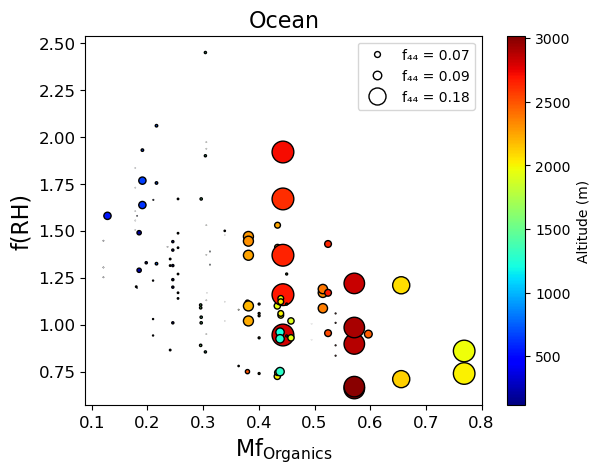

In [67]:
# Create a scatter plot with two distinct colors
#min_mz44 = ocean_transport['mz44'].median()
min_mz44 = np.percentile(ocean_transport['mz44'], 75)
percentile_95 = np.percentile(ocean_transport['mz44'], 85)
max_mz44 = ocean_transport['mz44'].max()
blue_star = mlines.Line2D([], [], color='white', marker='.', markeredgecolor = 'k', linestyle='None', markersize= 20000* (min_mz44**3), label='f₄₄ = {:.2f}'.format(min_mz44))
red_square = mlines.Line2D([], [], color='white', marker='.', markeredgecolor = 'k', linestyle='None', markersize= 4000* (max_mz44**3), label='f₄₄ = {:.2f}'.format(max_mz44))
purple_triangle = mlines.Line2D([], [], color='white', marker='.', markeredgecolor = 'k', linestyle='None', markersize= (18000* ((percentile_95)**3)), label='f₄₄ = {:.2f}'.format(percentile_95))

# Create a scatter plot with two distinct colors and markers
plt.scatter(ocean_transport['Org_Ave_IsoK_STP_ZIEMBA'], ocean_transport['fRH550_RH20to80_ZIEMBA'], c=ocean_transport['GPS_Altitude_THORNHILL'], s= 40000 * (ocean_transport['mz44']**3), cmap='jet', marker='o', edgecolors = 'black')

# Set the title and labels for the axes
plt.title("Ocean", fontsize = 16)
plt.xlabel(r'$\mathrm{Mf_{Organics}}$', fontsize = 16)
plt.ylabel("f(RH)", fontsize = 16)
plt.colorbar(label='Altitude (m)')
# Set tick label sizes for both x and y axes
plt.xticks(fontsize=12)  # Set tick label size for x-axis
plt.yticks(fontsize=12)  # Set tick label size for y-axis
# Add the custom legends to the plot
plt.legend(handles=[blue_star, purple_triangle, red_square])

# Display the plot
plt.show()

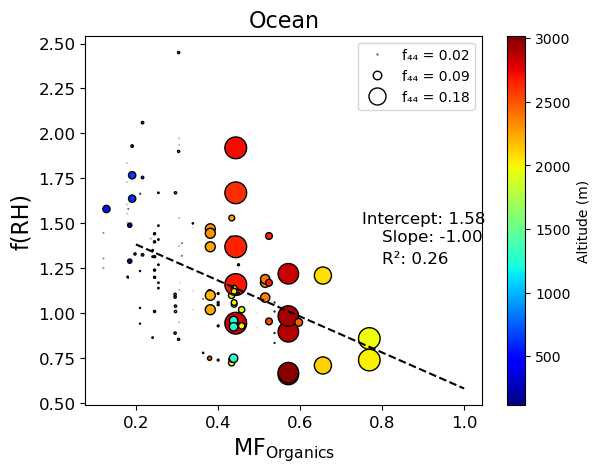

In [68]:
# Create a scatter plot with two distinct colors
ocean_transport_cleaned = ocean_transport.dropna(subset=['fRH550_RH20to80_ZIEMBA'])

min_mz44 = ocean_transport['mz44'].median()
percentile_90 = np.percentile(ocean_transport['mz44'], 85)
max_mz44 = ocean_transport['mz44'].max()
blue_star = mlines.Line2D([], [], color='white', marker='.', markeredgecolor = 'k', linestyle='None', markersize= 200000* (min_mz44**3), label='f₄₄ = {:.2f}'.format(min_mz44))
red_square = mlines.Line2D([], [], color='white', marker='.', markeredgecolor = 'k', linestyle='None', markersize= 4000* (max_mz44**3), label='f₄₄ = {:.2f}'.format(max_mz44))
purple_triangle = mlines.Line2D([], [], color='white', marker='.', markeredgecolor = 'k', linestyle='None', markersize= (18000* ((percentile_95)**3)), label='f₄₄ = {:.2f}'.format(percentile_95))
# Create a scatter plot with two distinct colors and markers
plt.scatter(ocean_transport['Org_Ave_IsoK_STP_ZIEMBA'], ocean_transport['fRH550_RH20to80_ZIEMBA'], c=ocean_transport['GPS_Altitude_THORNHILL'], s= (40000 * (ocean_transport['mz44']**3)), cmap='jet', marker='o', edgecolors='black')

# Perform linear regression to get the trendline
X = ocean_transport_cleaned['Org_Ave_IsoK_STP_ZIEMBA'].values.reshape(-1, 1)
y = ocean_transport_cleaned['fRH550_RH20to80_ZIEMBA'].values
reg = LinearRegression().fit(X, y)

# Plot the trendline
x_fit = np.linspace(0.2, 1, 100)
y_fit = reg.predict(x_fit.reshape(-1, 1))
plt.plot(x_fit, y_fit, color='k', linestyle='--', label=f'Trendline: y = {reg.coef_[0]:.2f}x + {reg.intercept_:.2f}')
# Add text annotations for intercept and regression values
intercept_text = f'Intercept: {reg.intercept_:.2f}'
slope_text = f'Slope: {reg.coef_[0]:.2f}'
# Calculate R-squared value
r_squared = reg.score(X, y)
r_squared_text = f'R²: {r_squared:.2f}'
plt.text(0.8, 1.28, r_squared_text, fontsize=12, color='k')
plt.text(0.75, 1.5, intercept_text, fontsize=12, color='k')
plt.text(0.8, 1.4, slope_text, fontsize=12, color='k')

# Set the title and labels for the axes
plt.title("Ocean", fontsize=16)
plt.xlabel(r'$\mathrm{MF_{Organics}}$', fontsize=16)
plt.ylabel("f(RH)", fontsize=16)
plt.colorbar(label='Altitude (m)')
# Set tick label sizes for both x and y axes
plt.xticks(fontsize=12)  # Set tick label size for x-axis
plt.yticks(fontsize=12)  # Set tick label size for y-axis
# Add the custom legends to the plot
plt.legend(handles=[blue_star, purple_triangle, red_square])

# Display the plot
plt.show()

In [69]:
# Concatenate the dataframes vertically (along rows)
North_America = pd.concat([DAY1000_subset_7, DAY1000_subset_7b, DAY1000_subset_17], axis=0)

# Reset the index of the merged dataframe
North_America.reset_index(drop=True, inplace=True)
North_America.mean()

Time_Start                  2022-06-09 07:55:27.365671680
Time_Stop                   2022-06-09 07:55:28.365671424
Latitude_THORNHILL                               32.23193
Longitude_THORNHILL                            -65.009193
GPS_Altitude_THORNHILL                         548.055485
Org_Ave_IsoK_STP_ZIEMBA                          0.534403
SO4_Ave_IsoK_STP_ZIEMBA                          0.322741
NO3_Ave_IsoK_STP_ZIEMBA                          0.026862
NH4_Ave_IsoK_STP_ZIEMBA                          0.112945
Chl_Ave_IsoK_STP_ZIEMBA                          0.003112
mz44_Ave_IsoK_STP_ZIEMBA                         0.189284
fRH550_RH20to80_ZIEMBA                           1.454942
mz44                                                 -inf
AMS                                              2.821119
dtype: object

In [70]:
# Concatenate the dataframes vertically (along rows)
North_America2 = pd.concat([DAY7_subset_3000, DAY7b_subset_3000, DAY17_subset_3000], axis=0)

# Reset the index of the merged dataframe
North_America2.reset_index(drop=True, inplace=True)
North_America2

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,fRH550_RH20to80_ZIEMBA,mz44,AMS
0,2022-06-07 14:38:12.000,2022-06-07 14:38:13.000,32.229355,-65.062216,1030.120,0.432010,0.395250,0.023097,0.150943,-0.001301,0.143,1.6100,0.143,3.0740
1,2022-06-07 14:38:21.000,2022-06-07 14:38:22.000,32.237006,-65.057784,1055.940,0.432010,0.395250,0.023097,0.150943,-0.001301,0.143,1.5850,0.143,3.0740
2,2022-06-07 14:38:32.000,2022-06-07 14:38:33.000,32.245194,-65.050061,1084.140,0.432010,0.395250,0.023097,0.150943,-0.001301,0.143,1.6300,0.143,3.0740
3,2022-06-07 14:38:42.500,2022-06-07 14:38:43.500,32.251219,-65.040481,1107.855,0.351597,0.424546,0.015654,0.195679,0.012523,0.132,1.5975,0.132,3.1940
4,2022-06-07 14:38:52.000,2022-06-07 14:38:53.000,32.254166,-65.030077,1136.620,0.351597,0.424546,0.015654,0.195679,0.012523,0.132,1.4950,0.132,3.1940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166,2022-06-17 16:37:28.000,2022-06-17 16:37:29.000,32.179166,-65.017440,3104.720,0.513889,0.183532,-0.011905,0.270833,0.043651,0.027,1.0000,0.027,1.0080
167,2022-06-17 16:37:38.500,2022-06-17 16:37:39.500,32.178687,-65.002961,3178.440,0.466019,0.260194,-0.023301,0.233981,0.063107,0.041,2.0300,0.041,1.0300
168,2022-06-17 16:37:48.500,2022-06-17 16:37:49.500,32.182226,-64.989990,3254.130,0.466019,0.260194,-0.023301,0.233981,0.063107,0.041,1.4600,0.041,1.0300
169,2022-06-17 16:37:58.500,2022-06-17 16:37:59.500,32.189191,-64.979410,3333.355,0.466019,0.260194,-0.023301,0.233981,0.063107,0.041,NaN,0.041,1.0300


In [71]:
North_America_transport = pd.concat([North_America, North_America2], axis=0)
North_America_transport.reset_index(drop=True, inplace=True)
North_America_transport
nbins = 10
bins = np.linspace(North_America_transport.GPS_Altitude_THORNHILL.min(), North_America_transport.GPS_Altitude_THORNHILL.max(), nbins+1)
North_America_transport['Bins'] = pd.cut(North_America_transport['GPS_Altitude_THORNHILL'], bins)
North_America_transport_plot = North_America_transport.groupby('Bins').median()
North_America_transport_plot

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,fRH550_RH20to80_ZIEMBA,mz44,AMS
Bins,,,,,,,,,,,,,,
"(129.055, 462.134]",2022-06-07 19:08:09.000000000,2022-06-07 19:08:10.000000000,32.242680,-64.990692,305.6750,0.562038,0.276398,0.020853,0.144943,0.004268,0.1410,1.4400,0.1410,1.9180
"(462.134, 795.214]",2022-06-07 19:09:56.000000000,2022-06-07 19:09:57.000000000,32.234662,-65.006074,626.7200,0.543490,0.289977,0.026471,0.124398,0.002465,0.1150,1.4450,0.1150,2.3840
"(795.214, 1128.294]",2022-06-07 19:11:26.000000000,2022-06-07 19:11:27.000000000,32.240078,-65.030907,936.2300,0.543490,0.395250,0.023097,0.132181,0.004106,0.1430,1.5775,0.1430,3.0740
"(1128.294, 1461.373]",2022-06-07 19:13:16.249999872,2022-06-07 19:13:17.249999872,32.235862,-65.009517,1293.3200,0.540760,0.295778,0.015654,0.185172,0.011584,0.1320,1.5500,0.1320,2.6015
"(1461.373, 1794.452]",2022-06-07 19:15:09.000000000,2022-06-07 19:15:10.000000000,32.244333,-65.028508,1635.5275,0.676051,0.161967,0.028736,0.125783,-0.004047,0.1235,1.2975,0.1235,1.8275
"(1794.452, 2127.532]",2022-06-07 19:17:02.249999872,2022-06-07 19:17:03.249999872,32.227914,-64.989851,1965.8425,0.729317,0.171033,0.013545,0.077183,-0.005180,0.0790,0.9300,0.0800,1.3120
"(2127.532, 2460.612]",2022-06-07 19:18:46.000000000,2022-06-07 19:18:47.000000000,32.211862,-65.021523,2295.2200,0.597895,0.255789,0.020134,0.181208,0.004785,0.0410,NaN,0.0410,0.9500
"(2460.612, 2793.691]",2022-06-07 19:20:16.500000000,2022-06-07 19:20:17.500000000,32.239553,-65.040110,2630.3350,0.568839,0.195762,0.028888,0.171790,0.011697,0.0790,NaN,0.0790,1.0280
"(2793.691, 3126.77]",2022-06-07 19:21:44.000000000,2022-06-07 19:21:45.000000000,32.218298,-65.003107,2951.4400,0.606838,0.176200,0.023669,0.181460,0.015078,0.1220,1.0625,0.1220,1.5210


In [72]:
# Filter the data using the condition >= 0.4
North_America_transport = North_America_transport[North_America_transport['mz44'] <= 2]
North_America_transport


# Print the filtered data
#filtered_Caribbean_data

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,fRH550_RH20to80_ZIEMBA,mz44,AMS,Bins
0,2022-06-07 14:32:05.500,2022-06-07 14:32:06.500,32.247084,-64.993783,130.630,0.643388,0.303912,0.027805,0.022308,0.002586,0.245,1.4400,0.245,3.0930,"(129.055, 462.134]"
1,2022-06-07 14:32:14.000,2022-06-07 14:32:15.000,32.241242,-64.985855,172.025,0.608696,0.276398,0.022516,0.087474,0.004917,0.372,1.3750,0.372,3.8640,"(129.055, 462.134]"
2,2022-06-07 14:32:27.500,2022-06-07 14:32:28.500,32.229405,-64.976252,188.390,0.608696,0.276398,0.022516,0.087474,0.004917,0.372,1.3775,0.372,3.8640,"(129.055, 462.134]"
3,2022-06-07 14:32:40.000,2022-06-07 14:32:41.000,32.216014,-64.972467,219.640,0.541940,0.231022,0.020853,0.195408,0.010778,0.296,1.8400,0.296,4.2680,"(129.055, 462.134]"
4,2022-06-07 14:32:48.000,2022-06-07 14:32:49.000,32.207231,-64.973025,250.980,0.541940,0.231022,0.020853,0.195408,0.010778,0.296,1.6250,0.296,4.2680,"(129.055, 462.134]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233,2022-06-17 16:37:28.000,2022-06-17 16:37:29.000,32.179166,-65.017440,3104.720,0.513889,0.183532,-0.011905,0.270833,0.043651,0.027,1.0000,0.027,1.0080,"(2793.691, 3126.77]"
234,2022-06-17 16:37:38.500,2022-06-17 16:37:39.500,32.178687,-65.002961,3178.440,0.466019,0.260194,-0.023301,0.233981,0.063107,0.041,2.0300,0.041,1.0300,"(3126.77, 3459.85]"
235,2022-06-17 16:37:48.500,2022-06-17 16:37:49.500,32.182226,-64.989990,3254.130,0.466019,0.260194,-0.023301,0.233981,0.063107,0.041,1.4600,0.041,1.0300,"(3126.77, 3459.85]"
236,2022-06-17 16:37:58.500,2022-06-17 16:37:59.500,32.189191,-64.979410,3333.355,0.466019,0.260194,-0.023301,0.233981,0.063107,0.041,NaN,0.041,1.0300,"(3126.77, 3459.85]"


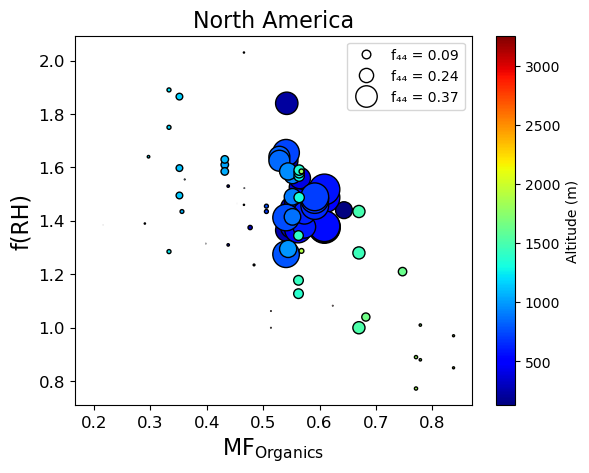

In [73]:
# Create a scatter plot with two distinct colors
min_mz44 = North_America_transport['mz44'].median()
percentile_90 = np.percentile(North_America_transport['mz44'], 85)
max_mz44 = North_America_transport['mz44'].max()
blue_star = mlines.Line2D([], [], color='white', marker='.', markeredgecolor = 'k', linestyle='None', markersize= (15000 * (min_mz44**3)), label='f₄₄ = {:.2f}'.format(min_mz44))
red_square = mlines.Line2D([], [], color='white', marker='.', markeredgecolor = 'k', linestyle='None', markersize= (600 * (max_mz44**3)), label='f₄₄ = {:.2f}'.format(max_mz44))
purple_triangle = mlines.Line2D([], [], color='white', marker='.', markeredgecolor = 'k', linestyle='None', markersize= (1500 * ((percentile_90)**3)), label='f₄₄ = {:.2f}'.format(percentile_90))
# Create a scatter plot with two distinct colors and markers
plt.scatter(North_America_transport['Org_Ave_IsoK_STP_ZIEMBA'], North_America_transport['fRH550_RH20to80_ZIEMBA'], c=North_America_transport['GPS_Altitude_THORNHILL'], s= (10000 * (North_America_transport['mz44']**3)), cmap='jet', marker='o', edgecolors='black')

# Set the title and labels for the axes
plt.title("North America", fontsize = 16)
plt.xlabel(r'$\mathrm{MF_{Organics}}$', fontsize = 16)
plt.ylabel("f(RH)", fontsize = 16)
plt.colorbar(label='Altitude (m)')
# Set tick label sizes for both x and y axes
plt.xticks(fontsize=12)  # Set tick label size for x-axis
plt.yticks(fontsize=12)  # Set tick label size for y-axis
# Add the custom legends to the plot
plt.legend(handles=[blue_star, purple_triangle, red_square])

# Display the plot
plt.show()

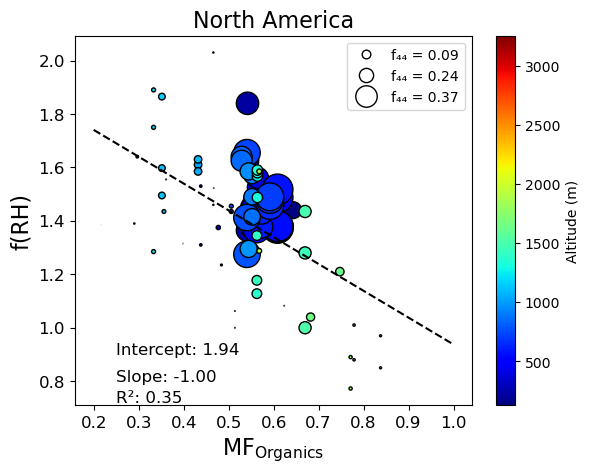

In [74]:
# Create a scatter plot with two distinct colors
North_America_transport_cleaned = North_America_transport.dropna(subset=['fRH550_RH20to80_ZIEMBA'])

min_mz44 = North_America_transport['mz44'].median()
percentile_90 = np.percentile(North_America_transport['mz44'], 85)
max_mz44 = North_America_transport['mz44'].max()
blue_star = mlines.Line2D([], [], color='white', marker='.', markeredgecolor = 'k', linestyle='None', markersize= (15000 * (min_mz44**3)), label='f₄₄ = {:.2f}'.format(min_mz44))
red_square = mlines.Line2D([], [], color='white', marker='.', markeredgecolor = 'k', linestyle='None', markersize= (600 * (max_mz44**3)), label='f₄₄ = {:.2f}'.format(max_mz44))
purple_triangle = mlines.Line2D([], [], color='white', marker='.', markeredgecolor = 'k', linestyle='None', markersize= (1500 * ((percentile_90)**3)), label='f₄₄ = {:.2f}'.format(percentile_90))
# Create a scatter plot with two distinct colors and markers
plt.scatter(North_America_transport['Org_Ave_IsoK_STP_ZIEMBA'], North_America_transport['fRH550_RH20to80_ZIEMBA'], c=North_America_transport['GPS_Altitude_THORNHILL'], s= (10000 * (North_America_transport['mz44']**3)), cmap='jet', marker='o', edgecolors='black')

# Perform linear regression to get the trendline
X = North_America_transport_cleaned['Org_Ave_IsoK_STP_ZIEMBA'].values.reshape(-1, 1)
y = North_America_transport_cleaned['fRH550_RH20to80_ZIEMBA'].values
reg = LinearRegression().fit(X, y)

# Plot the trendline
x_fit = np.linspace(0.2, 1, 100)
y_fit = reg.predict(x_fit.reshape(-1, 1))
plt.plot(x_fit, y_fit, color='k', linestyle='--', label=f'Trendline: y = {reg.coef_[0]:.2f}x + {reg.intercept_:.2f}')
# Add text annotations for intercept and regression values
intercept_text = f'Intercept: {reg.intercept_:.2f}'
slope_text = f'Slope: {reg.coef_[0]:.2f}'
# Calculate R-squared value
r_squared = reg.score(X, y)
r_squared_text = f'R²: {r_squared:.2f}'
plt.text(0.25, 0.72, r_squared_text, fontsize=12, color='k')
plt.text(0.25, 0.9, intercept_text, fontsize=12, color='k')
plt.text(0.25, 0.8, slope_text, fontsize=12, color='k')

# Set the title and labels for the axes
plt.title("North America", fontsize=16)
plt.xlabel(r'$\mathrm{MF_{Organics}}$', fontsize=16)
plt.ylabel("f(RH)", fontsize=16)
plt.colorbar(label='Altitude (m)')
# Set tick label sizes for both x and y axes
plt.xticks(fontsize=12)  # Set tick label size for x-axis
plt.yticks(fontsize=12)  # Set tick label size for y-axis
# Add the custom legends to the plot
plt.legend(handles=[blue_star, purple_triangle, red_square])

# Display the plot
plt.show()


In [75]:
# Concatenate the dataframes vertically (along rows)
Caribbean = pd.concat([DAY1000_subset_8, DAY1000_subset_10, DAY1000_subset_110b, DAY1000_subset_10b, DAY1000_subset_11, DAY1000_subset_11b, DAY1000_subset_13, DAY1000_subset_13b, DAY1000_subset_14], axis=0)

# Reset the index of the merged dataframe
Caribbean.reset_index(drop=True, inplace=True)
Caribbean

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,fRH550_RH20to80_ZIEMBA,mz44,AMS
0,2022-06-08 20:30:28.000,2022-06-08 20:30:29.000,32.293626,-65.017848,154.5400,0.434934,0.473664,0.014717,0.073199,0.003486,0.142,0.9050,0.142,2.582
1,2022-06-08 20:31:07.000,2022-06-08 20:31:08.000,32.300051,-65.066294,198.9850,0.411602,0.590239,0.000460,0.001381,-0.003683,0.102,1.1000,0.102,2.172
2,2022-06-08 20:31:21.500,2022-06-08 20:31:22.500,32.291698,-65.080461,242.1600,0.411602,0.590239,0.000460,0.001381,-0.003683,0.102,1.0675,0.102,2.172
3,2022-06-08 20:31:32.500,2022-06-08 20:31:33.500,32.282742,-65.087275,278.0025,0.430960,0.639274,0.017678,-0.087434,-0.000478,0.076,0.8900,0.076,2.093
4,2022-06-08 20:31:44.000,2022-06-08 20:31:45.000,32.272093,-65.089858,314.4600,0.430960,0.639274,0.017678,-0.087434,-0.000478,0.076,0.8050,0.076,2.093
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169,2022-06-14 16:06:27.500,2022-06-14 16:06:28.500,30.680642,-64.429457,577.6025,0.130834,0.634277,0.018363,0.174445,0.042081,-0.049,1.0575,-inf,1.307
170,2022-06-14 16:06:38.500,2022-06-14 16:06:39.500,30.684686,-64.417288,662.5250,-0.186014,0.980420,0.033566,0.186014,-0.013986,-0.047,0.9700,-inf,0.715
171,2022-06-14 16:06:48.500,2022-06-14 16:06:49.500,30.683898,-64.405451,744.1025,-0.186014,0.980420,0.033566,0.186014,-0.013986,-0.047,0.9175,-inf,0.715
172,2022-06-14 16:06:59.500,2022-06-14 16:07:00.500,30.678364,-64.394209,825.6350,-0.186014,0.980420,0.033566,0.186014,-0.013986,-0.047,0.8350,-inf,0.715


In [76]:
# Concatenate the dataframes vertically (along rows)
Caribbean2 = pd.concat([DAY8_subset_3000, DAY10_subset_3000, DAY110b_subset_3000, DAY10b_subset_3000, DAY11_subset_3000, DAY11b_subset_3000, DAY13_subset_3000, DAY13b_subset_3000, DAY14_subset_3000], axis=0)

# Reset the index of the merged dataframe
Caribbean2.reset_index(drop=True, inplace=True)
Caribbean2.mean()

Time_Start                  2022-06-11 14:59:04.714000128
Time_Stop                   2022-06-11 14:59:05.714000128
Latitude_THORNHILL                              31.887651
Longitude_THORNHILL                            -65.100517
GPS_Altitude_THORNHILL                         2200.89885
Org_Ave_IsoK_STP_ZIEMBA                          0.386282
SO4_Ave_IsoK_STP_ZIEMBA                          0.474936
NO3_Ave_IsoK_STP_ZIEMBA                         -0.009764
NH4_Ave_IsoK_STP_ZIEMBA                          0.150701
Chl_Ave_IsoK_STP_ZIEMBA                         -0.001812
mz44_Ave_IsoK_STP_ZIEMBA                         0.032135
fRH550_RH20to80_ZIEMBA                           0.960654
mz44                                                  NaN
AMS                                              1.018531
dtype: object

In [77]:
Caribbean_transport = pd.concat([Caribbean, Caribbean2], axis=0)
Caribbean_transport.reset_index(drop=True, inplace=True)
nbins = 10
bins = np.linspace(Caribbean_transport.GPS_Altitude_THORNHILL.min(), Caribbean_transport.GPS_Altitude_THORNHILL.max(), nbins+1)
Caribbean_transport['Bins'] = pd.cut(Caribbean_transport['GPS_Altitude_THORNHILL'], bins)
Caribbean_transport_plot = Caribbean_transport.groupby('Bins').median()
Caribbean_transport_plot

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,fRH550_RH20to80_ZIEMBA,mz44,AMS
Bins,,,,,,,,,,,,,,
"(115.232, 448.612]",2022-06-11 15:26:15.000000000,2022-06-11 15:26:16.000000000,32.228500,-65.012279,289.11250,0.165815,0.651902,0.018363,0.169811,-0.001814,0.0030,1.0200,0.0195,1.654
"(448.612, 781.991]",2022-06-11 15:27:35.000000000,2022-06-11 15:27:36.000000000,32.208787,-65.030230,617.59375,0.208202,0.598452,0.001516,0.184431,0.002395,0.0000,0.9825,0.0140,1.701
"(781.991, 1115.37]",2022-06-11 15:28:42.249999872,2022-06-11 15:28:43.249999872,32.221669,-65.035855,921.55000,0.206002,0.557450,0.013849,0.212414,0.003509,0.0450,0.9425,0.0510,1.733
"(1115.37, 1448.75]",2022-06-11 15:30:26.000000000,2022-06-11 15:30:27.000000000,32.222529,-65.026186,1283.95500,0.254768,0.579724,0.002433,0.166122,0.002820,0.0350,0.8925,0.0500,1.233
"(1448.75, 1782.129]",2022-06-11 15:32:11.500000000,2022-06-11 15:32:12.500000000,32.211598,-65.048986,1619.04000,0.250583,0.525538,0.015065,0.156642,0.003803,0.0295,0.8525,0.0900,1.113
"(1782.129, 2115.508]",2022-06-11 15:33:36.249999872,2022-06-11 15:33:37.249999872,32.218318,-65.010468,1955.29250,0.305486,0.509855,0.015921,0.152071,0.006293,0.0220,0.8150,0.0540,0.909
"(2115.508, 2448.887]",2022-06-11 15:35:18.000000000,2022-06-11 15:35:19.000000000,32.249386,-65.003874,2273.61500,0.388935,0.445658,0.013266,0.110936,0.006853,0.0320,0.9700,0.0320,0.792
"(2448.887, 2782.266]",2022-06-11 15:36:39.500000000,2022-06-11 15:36:40.500000000,32.220810,-65.006000,2622.56500,0.502451,0.456866,0.002797,0.042088,0.002797,0.0270,0.9500,0.0310,0.715
"(2782.266, 3115.646]",2022-06-11 15:37:36.750000128,2022-06-11 15:37:37.750000128,32.238931,-65.017036,2960.22000,0.446172,0.402655,0.001177,0.150581,0.000000,0.0170,0.9975,0.0170,0.639


In [78]:
Caribbean_transport

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,fRH550_RH20to80_ZIEMBA,mz44,AMS,Bins
0,2022-06-08 20:30:28.000,2022-06-08 20:30:29.000,32.293626,-65.017848,154.5400,0.434934,0.473664,0.014717,0.073199,0.003486,0.142,0.9050,0.142,2.582,"(115.232, 448.612]"
1,2022-06-08 20:31:07.000,2022-06-08 20:31:08.000,32.300051,-65.066294,198.9850,0.411602,0.590239,0.000460,0.001381,-0.003683,0.102,1.1000,0.102,2.172,"(115.232, 448.612]"
2,2022-06-08 20:31:21.500,2022-06-08 20:31:22.500,32.291698,-65.080461,242.1600,0.411602,0.590239,0.000460,0.001381,-0.003683,0.102,1.0675,0.102,2.172,"(115.232, 448.612]"
3,2022-06-08 20:31:32.500,2022-06-08 20:31:33.500,32.282742,-65.087275,278.0025,0.430960,0.639274,0.017678,-0.087434,-0.000478,0.076,0.8900,0.076,2.093,"(115.232, 448.612]"
4,2022-06-08 20:31:44.000,2022-06-08 20:31:45.000,32.272093,-65.089858,314.4600,0.430960,0.639274,0.017678,-0.087434,-0.000478,0.076,0.8050,0.076,2.093,"(115.232, 448.612]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
669,2022-06-14 16:11:16.000,2022-06-14 16:11:17.000,30.672894,-64.430983,3001.5400,0.355556,0.223529,0.050980,0.307190,0.062745,0.020,NaN,inf,0.765,"(2782.266, 3115.646]"
670,2022-06-14 16:11:25.500,2022-06-14 16:11:26.500,30.683628,-64.426389,3084.1300,0.355556,0.223529,0.050980,0.307190,0.062745,0.020,NaN,inf,0.765,"(2782.266, 3115.646]"
671,2022-06-14 16:11:35.000,2022-06-14 16:11:36.000,30.692355,-64.417783,3169.9400,0.561254,0.555556,0.039886,-0.176638,0.019943,0.047,NaN,inf,0.351,"(3115.646, 3449.025]"
672,2022-06-14 16:11:45.500,2022-06-14 16:11:46.500,30.698359,-64.404921,3256.0600,0.561254,0.555556,0.039886,-0.176638,0.019943,0.047,NaN,inf,0.351,"(3115.646, 3449.025]"


In [79]:
# Filter the data using the condition >= 0.4
Caribbean_transport = Caribbean_transport[Caribbean_transport['mz44'] <= 2]
Caribbean_transport


# Print the filtered data
#filtered_Caribbean_data

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,fRH550_RH20to80_ZIEMBA,mz44,AMS,Bins
0,2022-06-08 20:30:28.000,2022-06-08 20:30:29.000,32.293626,-65.017848,154.5400,0.434934,0.473664,0.014717,0.073199,0.003486,0.142,0.9050,0.142,2.582,"(115.232, 448.612]"
1,2022-06-08 20:31:07.000,2022-06-08 20:31:08.000,32.300051,-65.066294,198.9850,0.411602,0.590239,0.000460,0.001381,-0.003683,0.102,1.1000,0.102,2.172,"(115.232, 448.612]"
2,2022-06-08 20:31:21.500,2022-06-08 20:31:22.500,32.291698,-65.080461,242.1600,0.411602,0.590239,0.000460,0.001381,-0.003683,0.102,1.0675,0.102,2.172,"(115.232, 448.612]"
3,2022-06-08 20:31:32.500,2022-06-08 20:31:33.500,32.282742,-65.087275,278.0025,0.430960,0.639274,0.017678,-0.087434,-0.000478,0.076,0.8900,0.076,2.093,"(115.232, 448.612]"
4,2022-06-08 20:31:44.000,2022-06-08 20:31:45.000,32.272093,-65.089858,314.4600,0.430960,0.639274,0.017678,-0.087434,-0.000478,0.076,0.8050,0.076,2.093,"(115.232, 448.612]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
663,2022-06-14 16:10:13.000,2022-06-14 16:10:14.000,30.644419,-64.377702,2501.1400,-0.666667,-5.166667,-2.600000,9.433333,-0.000000,-0.019,0.7650,-inf,-0.030,"(2448.887, 2782.266]"
664,2022-06-14 16:10:23.000,2022-06-14 16:10:24.000,30.638905,-64.388339,2585.9900,-0.666667,-5.166667,-2.600000,9.433333,-0.000000,-0.019,0.7075,-inf,-0.030,"(2448.887, 2782.266]"
665,2022-06-14 16:10:33.500,2022-06-14 16:10:34.500,30.637526,-64.401464,2664.6600,0.343789,0.207026,0.067754,0.341280,0.040151,-0.054,NaN,-inf,0.797,"(2448.887, 2782.266]"
666,2022-06-14 16:10:43.000,2022-06-14 16:10:44.000,30.640487,-64.413111,2751.5200,0.343789,0.207026,0.067754,0.341280,0.040151,-0.054,NaN,-inf,0.797,"(2448.887, 2782.266]"


In [80]:
Caribbean_transport['mz44'].min()

-inf

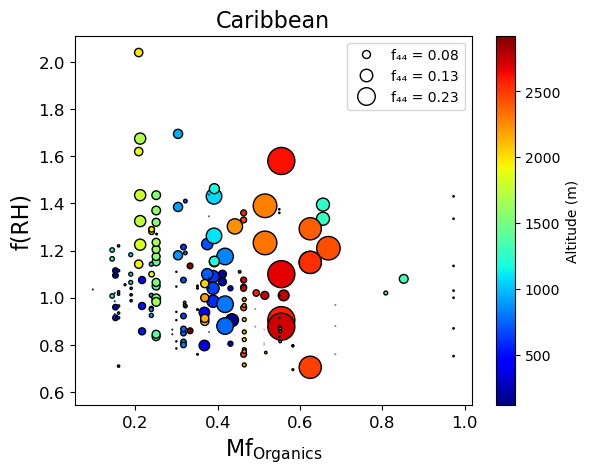

In [81]:
# Create a scatter plot with two distinct colors


min_mz44 = np.percentile(Caribbean_transport['mz44'], 75)
percentile_90 = np.percentile(Caribbean_transport['mz44'], 90)
max_mz44 = Caribbean_transport['mz44'].max()
blue_star = mlines.Line2D([], [], color='white', marker='.', markeredgecolor = 'k', linestyle='None', markersize= (20000* (min_mz44**3)), label='f₄₄ = {:.2f}'.format(min_mz44))
red_square = mlines.Line2D([], [], color='white', marker='.', markeredgecolor = 'k', linestyle='None', markersize= (2000 * (max_mz44**3)), label='f₄₄ = {:.2f}'.format(max_mz44))
purple_triangle = mlines.Line2D([], [], color='white', marker='.', markeredgecolor = 'k', linestyle='None', markersize= (9000* ((percentile_90)**3)), label='f₄₄ = {:.2f}'.format(percentile_90))

# Create a scatter plot with two distinct colors and markers
plt.scatter(Caribbean_transport['Org_Ave_IsoK_STP_ZIEMBA'], Caribbean_transport['fRH550_RH20to80_ZIEMBA'], c=Caribbean_transport['GPS_Altitude_THORNHILL'], s= (30000 * (Caribbean_transport['mz44']**3)), cmap='jet', marker='o', edgecolors='black')

# Set the title and labels for the axes
plt.title("Caribbean", fontsize = 16)
plt.xlabel(r'$\mathrm{Mf_{Organics}}$', fontsize = 16)
plt.ylabel("f(RH)", fontsize = 16)
plt.colorbar(label='Altitude (m)')
# Set tick label sizes for both x and y axes
plt.xticks(fontsize=12)  # Set tick label size for x-axis
plt.yticks(fontsize=12)  # Set tick label size for y-axis

# Add the custom legends to the plot
plt.legend(handles=[blue_star, purple_triangle, red_square])

# Display the plot
plt.show()

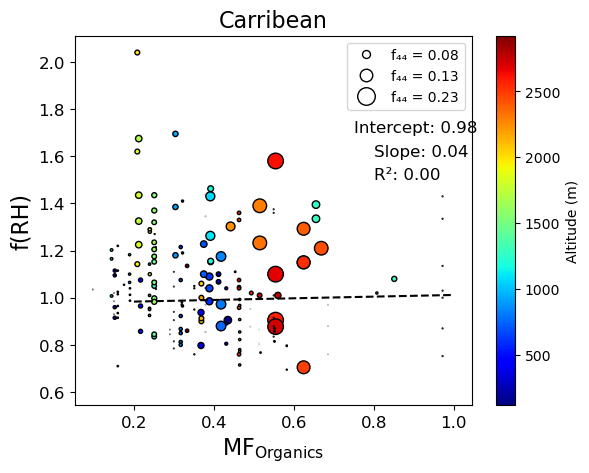

In [82]:
# Create a scatter plot with two distinct colors
Caribbean_transport_cleaned = Caribbean_transport.dropna(subset=['fRH550_RH20to80_ZIEMBA'])

min_mz44 = np.percentile(Caribbean_transport['mz44'], 75)
percentile_90 = np.percentile(Caribbean_transport['mz44'], 90)
max_mz44 = Caribbean_transport['mz44'].max()
blue_star = mlines.Line2D([], [], color='white', marker='.', markeredgecolor = 'k', linestyle='None', markersize= (20000* (min_mz44**3)), label='f₄₄ = {:.2f}'.format(min_mz44))
red_square = mlines.Line2D([], [], color='white', marker='.', markeredgecolor = 'k', linestyle='None', markersize= (2000 * (max_mz44**3)), label='f₄₄ = {:.2f}'.format(max_mz44))
purple_triangle = mlines.Line2D([], [], color='white', marker='.', markeredgecolor = 'k', linestyle='None', markersize= (9000* ((percentile_90)**3)), label='f₄₄ = {:.2f}'.format(percentile_90))
# Create a scatter plot with two distinct colors and markers
plt.scatter(Caribbean_transport['Org_Ave_IsoK_STP_ZIEMBA'], Caribbean_transport['fRH550_RH20to80_ZIEMBA'], c=Caribbean_transport['GPS_Altitude_THORNHILL'], s= (10000 * (Caribbean_transport['mz44']**3)), cmap='jet', marker='o', edgecolors='black')

# Perform linear regression to get the trendline
X = Caribbean_transport_cleaned['Org_Ave_IsoK_STP_ZIEMBA'].values.reshape(-1, 1)
y = Caribbean_transport_cleaned['fRH550_RH20to80_ZIEMBA'].values
reg = LinearRegression().fit(X, y)
r_squared = reg.score(X, y)
# Plot the trendline
x_fit = np.linspace(0.2, 1, 100)
y_fit = reg.predict(x_fit.reshape(-1, 1))
plt.plot(x_fit, y_fit, color='k', linestyle='--', label=f'Trendline: y = {reg.coef_[0]:.2f}x + {reg.intercept_:.2f}')
# Add text annotations for intercept and regression values
intercept_text = f'Intercept: {reg.intercept_:.2f}'
slope_text = f'Slope: {reg.coef_[0]:.2f}'
# Calculate R-squared value
r_squared_text = f'R²: {r_squared:.2f}'
plt.text(0.8, 1.5, r_squared_text, fontsize=12, color='k')
plt.text(0.75, 1.7, intercept_text, fontsize=12, color='k')
plt.text(0.8, 1.6, slope_text, fontsize=12, color='k')

# Set the title and labels for the axes
plt.title("Carribean", fontsize=16)
plt.xlabel(r'$\mathrm{MF_{Organics}}$', fontsize=16)
plt.ylabel("f(RH)", fontsize=16)
plt.colorbar(label='Altitude (m)')
# Set tick label sizes for both x and y axes
plt.xticks(fontsize=12)  # Set tick label size for x-axis
plt.yticks(fontsize=12)  # Set tick label size for y-axis
# Add the custom legends to the plot
plt.legend(handles=[blue_star, purple_triangle, red_square])

# Display the plot
plt.show()


In [83]:
# Concatenate the dataframes vertically (along rows)
'''merged_df = pd.concat([Caribbean.describe(), Caribbean2.describe(), North_America.describe(), North_America2.describe(), ocean.describe(), ocean2.describe(), Africa.describe(), DAY14_subset_3000.describe()], axis=0)

# Reset the index of the merged dataframe
merged_df.reset_index(drop=False, inplace=True)

# Display the merged dataframe
merged_df
merged_df.to_csv('C:/Users/taiwoajayi/OneDrive - University of Arizona/python/chemistry_mass_description.csv')'''

"merged_df = pd.concat([Caribbean.describe(), Caribbean2.describe(), North_America.describe(), North_America2.describe(), ocean.describe(), ocean2.describe(), Africa.describe(), DAY14_subset_3000.describe()], axis=0)\n\n# Reset the index of the merged dataframe\nmerged_df.reset_index(drop=False, inplace=True)\n\n# Display the merged dataframe\nmerged_df\nmerged_df.to_csv('C:/Users/taiwoajayi/OneDrive - University of Arizona/python/chemistry_mass_description.csv')"

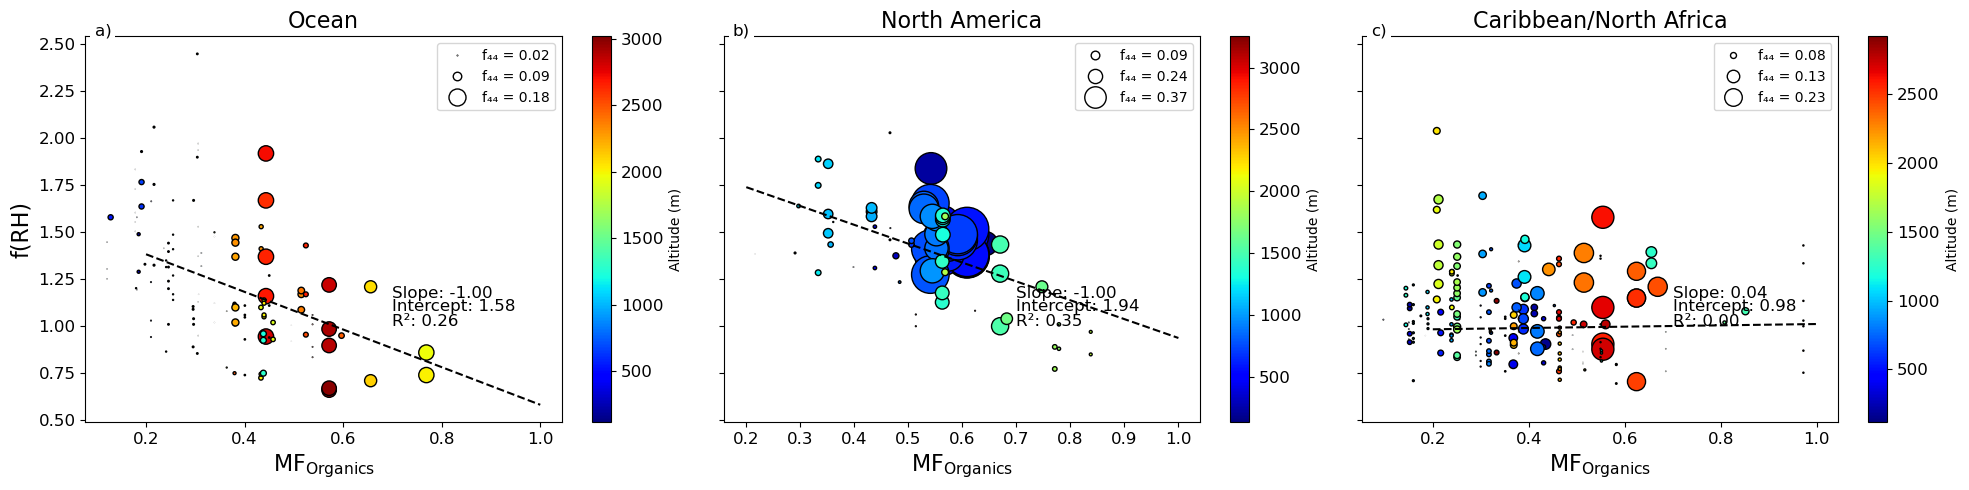

In [84]:
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.lines as mlines

# Create a scatter plot with two distinct colors
def create_scatter_plot(ax, data, title, x_label, y_label, legend_handles):
    data_cleaned = data.dropna(subset=['fRH550_RH20to80_ZIEMBA', 'Org_Ave_IsoK_STP_ZIEMBA', 'mz44', 'GPS_Altitude_THORNHILL'])
    scatter = ax.scatter(data_cleaned['Org_Ave_IsoK_STP_ZIEMBA'], data_cleaned['fRH550_RH20to80_ZIEMBA'], c=data_cleaned['GPS_Altitude_THORNHILL'], s=(20000 * (data_cleaned['mz44']**3)), cmap='jet', marker='o', edgecolors='black')

    # Perform linear regression to get the trendline
    X = data_cleaned['Org_Ave_IsoK_STP_ZIEMBA'].values.reshape(-1, 1)
    y = data_cleaned['fRH550_RH20to80_ZIEMBA'].values
    reg = LinearRegression().fit(X, y)

    # Plot the trendline
    x_fit = np.linspace(0.2, 1, 100)
    y_fit = reg.predict(x_fit.reshape(-1, 1))
    ax.plot(x_fit, y_fit, color='k', linestyle='--', label=f'Trendline: y = {reg.coef_[0]:.2f}x + {reg.intercept_:.2f}')
    
    # Add text annotations for intercept and regression values
    intercept_text = f'Intercept: {reg.intercept_:.2f}'
    slope_text = f'Slope: {reg.coef_[0]:.2f}'
    
    # Calculate R-squared value
    r_squared = reg.score(X, y)
    r_squared_text = f'R²: {r_squared:.2f}'
    ax.text(0.7, 1.0, r_squared_text, fontsize=12, color='k')
    ax.text(0.7, 1.08, intercept_text, fontsize=12, color='k')
    ax.text(0.7, 1.15, slope_text, fontsize=12, color='k')

    # Set the title and labels for the axes
    ax.set_title(title, fontsize=16)
    ax.set_xlabel(x_label, fontsize=16)
    ax.set_ylabel(y_label, fontsize=16)

    # Create a colorbar
    cbar = plt.colorbar(scatter, ax=ax, label='Altitude (m)')
    cbar.ax.tick_params(labelsize=12)

    # Set tick label sizes for both x and y axes
    ax.tick_params(axis='both', labelsize=12)

    # Add the custom legends to the plot
    ax.legend(handles=legend_handles)

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 5), sharey = True)

# Labels for the subplots
labels = ['a)', 'b)', 'c)']

# Create legend handles for all subplots
min_mz44 = ocean_transport['mz44'].median()
max_mz44 = ocean_transport['mz44'].max()
percentile_95 = np.percentile(ocean_transport['mz44'], 85)
blue_star = mlines.Line2D([], [], color='white', marker='.', markeredgecolor='k', linestyle='None', markersize=200000 * (min_mz44**3), label='f₄₄ = {:.2f}'.format(min_mz44))
purple_triangle = mlines.Line2D([], [], color='white', marker='.', markeredgecolor='k', linestyle='None', markersize=(18000 * ((percentile_95)**3)), label='f₄₄ = {:.2f}'.format(percentile_95))
red_square = mlines.Line2D([], [], color='white', marker='.', markeredgecolor='k', linestyle='None', markersize=4000 * (max_mz44**3), label='f₄₄ = {:.2f}'.format(max_mz44))

legend_handles_ocean = [blue_star, purple_triangle, red_square]

min_mz44 = North_America_transport['mz44'].median()
max_mz44 = North_America_transport['mz44'].max()
percentile_90 = np.percentile(North_America_transport['mz44'], 85)
indigo_star = mlines.Line2D([], [], color='white', marker='.', markeredgecolor='k', linestyle='None', markersize=(15000 * (min_mz44**3)), label='f₄₄ = {:.2f}'.format(min_mz44))
violet_square = mlines.Line2D([], [], color='white', marker='.', markeredgecolor='k', linestyle='None', markersize=(600 * (max_mz44**3)), label='f₄₄ = {:.2f}'.format(max_mz44))
cyan_triangle = mlines.Line2D([], [], color='white', marker='.', markeredgecolor='k', linestyle='None', markersize=(1500 * ((percentile_90)**3)), label='f₄₄ = {:.2f}'.format(percentile_90))

legend_handles_north_america = [indigo_star, cyan_triangle,  violet_square]

min_mz44 = np.percentile(Caribbean_transport['mz44'], 75)
max_mz44 = Caribbean_transport['mz44'].max()
percentile_90 = np.percentile(Caribbean_transport['mz44'], 90)
orange_star = mlines.Line2D([], [], color='white', marker='.', markeredgecolor='k', linestyle='None', markersize=(15000 * (min_mz44**3)), label='f₄₄ = {:.2f}'.format(min_mz44))
grey_square = mlines.Line2D([], [], color='white', marker='.', markeredgecolor='k', linestyle='None', markersize=(2000 * (max_mz44**3)), label='f₄₄ = {:.2f}'.format(max_mz44))
magenta_triangle = mlines.Line2D([], [], color='white', marker='.', markeredgecolor='k', linestyle='None', markersize=(9000 * ((percentile_90)**3)), label='f₄₄ = {:.2f}'.format(percentile_90))

legend_handles_caribbean = [orange_star, magenta_triangle, grey_square]


# Create legend handles for all subplots
# (Assuming you have defined these legend handles earlier)

# Create subplots using the existing code and labels
create_scatter_plot(axes[0], ocean_transport, 'Ocean', r'$\mathrm{MF_{Organics}}$', 'f(RH)', legend_handles_ocean)
create_scatter_plot(axes[1], North_America_transport, 'North America', r'$\mathrm{MF_{Organics}}$', '', legend_handles_north_america)
create_scatter_plot(axes[2], Caribbean_transport, 'Caribbean/North Africa', r'$\mathrm{MF_{Organics}}$', '', legend_handles_caribbean)

# Labels for subplots
for i, ax in enumerate(axes.flat):
    trans = ScaledTranslation(10 / 72, -5 / 72, fig.dpi_scale_trans)
    ax.text(
        -0.01, 1.05, labels[i],
        transform=ax.transAxes + trans,
        fontsize='large', verticalalignment='top',
        bbox=dict(facecolor='1', edgecolor='none', pad=3.0)
    )

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()


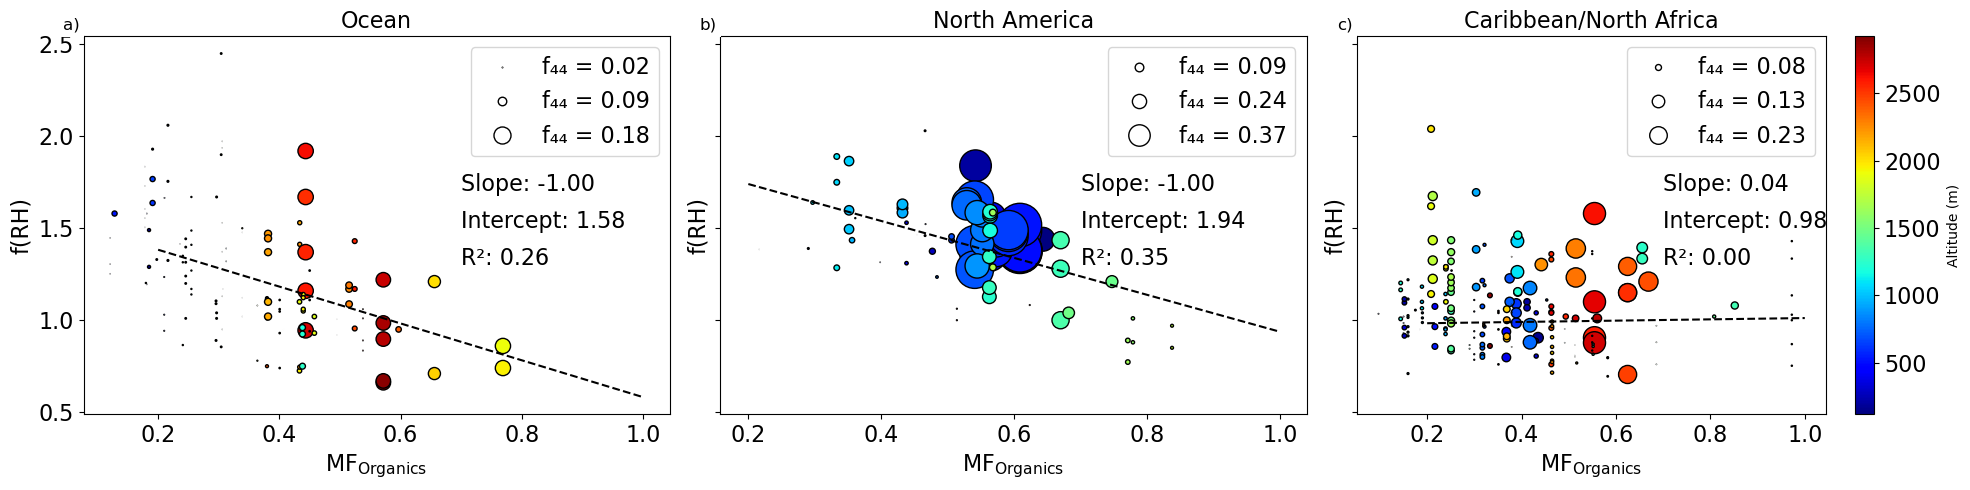

In [85]:
def create_scatter_plot(ax, data, title, x_label, y_label, legend_handles, show_colorbar=False):
    data_cleaned = data.dropna(subset=['fRH550_RH20to80_ZIEMBA', 'Org_Ave_IsoK_STP_ZIEMBA', 'mz44', 'GPS_Altitude_THORNHILL'])
    scatter = ax.scatter(data_cleaned['Org_Ave_IsoK_STP_ZIEMBA'], data_cleaned['fRH550_RH20to80_ZIEMBA'], c=data_cleaned['GPS_Altitude_THORNHILL'], s=(20000 * (data_cleaned['mz44']**3)), cmap='jet', marker='o', edgecolors='black')

    # Perform linear regression to get the trendline
    X = data_cleaned['Org_Ave_IsoK_STP_ZIEMBA'].values.reshape(-1, 1)
    y = data_cleaned['fRH550_RH20to80_ZIEMBA'].values
    reg = LinearRegression().fit(X, y)

    # Plot the trendline
    x_fit = np.linspace(0.2, 1, 100)
    y_fit = reg.predict(x_fit.reshape(-1, 1))
    ax.plot(x_fit, y_fit, color='k', linestyle='--', label=f'Trendline: y = {reg.coef_[0]:.2f}x + {reg.intercept_:.2f}')
    
    # Add text annotations for intercept and regression values
    intercept_text = f'Intercept: {reg.intercept_:.2f}'
    slope_text = f'Slope: {reg.coef_[0]:.2f}'
    
    # Calculate R-squared value
    r_squared = reg.score(X, y)
    r_squared_text = f'R²: {r_squared:.2f}'
    ax.text(0.7, 1.3, r_squared_text, fontsize=16, color='k')
    ax.text(0.7, 1.5, intercept_text, fontsize=16, color='k')
    ax.text(0.7, 1.7, slope_text, fontsize=16, color='k')

    # Set the title and labels for the axes
    ax.set_title(title, fontsize=16)
    ax.set_xlabel(x_label, fontsize=16)
    ax.set_ylabel(y_label, fontsize=16)

    # Create a colorbar if show_colorbar is True
    if show_colorbar:
        cbar = plt.colorbar(scatter, ax=ax, label='Altitude (m)')
        cbar.ax.tick_params(labelsize=16)

    # Set tick label sizes for both x and y axes
    ax.tick_params(axis='both', labelsize=16)

    # Add the custom legends to the plot
    ax.legend(handles=legend_handles, fontsize = 16)

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 5), sharey = True)

# Labels for the subplots
labels = ['a)', 'b)', 'c)']

# Create legend handles for all subplots (you need to define these legend handles earlier in your code)

# Create subplots using the existing code and labels
create_scatter_plot(axes[0], ocean_transport, 'Ocean', r'$\mathrm{MF_{Organics}}$', 'f(RH)', legend_handles_ocean, show_colorbar=False)
create_scatter_plot(axes[1], North_America_transport, 'North America', r'$\mathrm{MF_{Organics}}$', 'f(RH)', legend_handles_north_america, show_colorbar=False)
create_scatter_plot(axes[2], Caribbean_transport, 'Caribbean/North Africa', r'$\mathrm{MF_{Organics}}$', 'f(RH)', legend_handles_caribbean, show_colorbar=True)

# Labels for subplots
for i, ax in enumerate(axes):
    trans = ScaledTranslation(-0.15, 0, fig.dpi_scale_trans)
    ax.text(
        -0.01, 1.05, labels[i],
        transform=ax.transAxes + trans,
        fontsize='large', verticalalignment='top',
        bbox=dict(facecolor='1', edgecolor='none', pad=3.0)
    )

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()


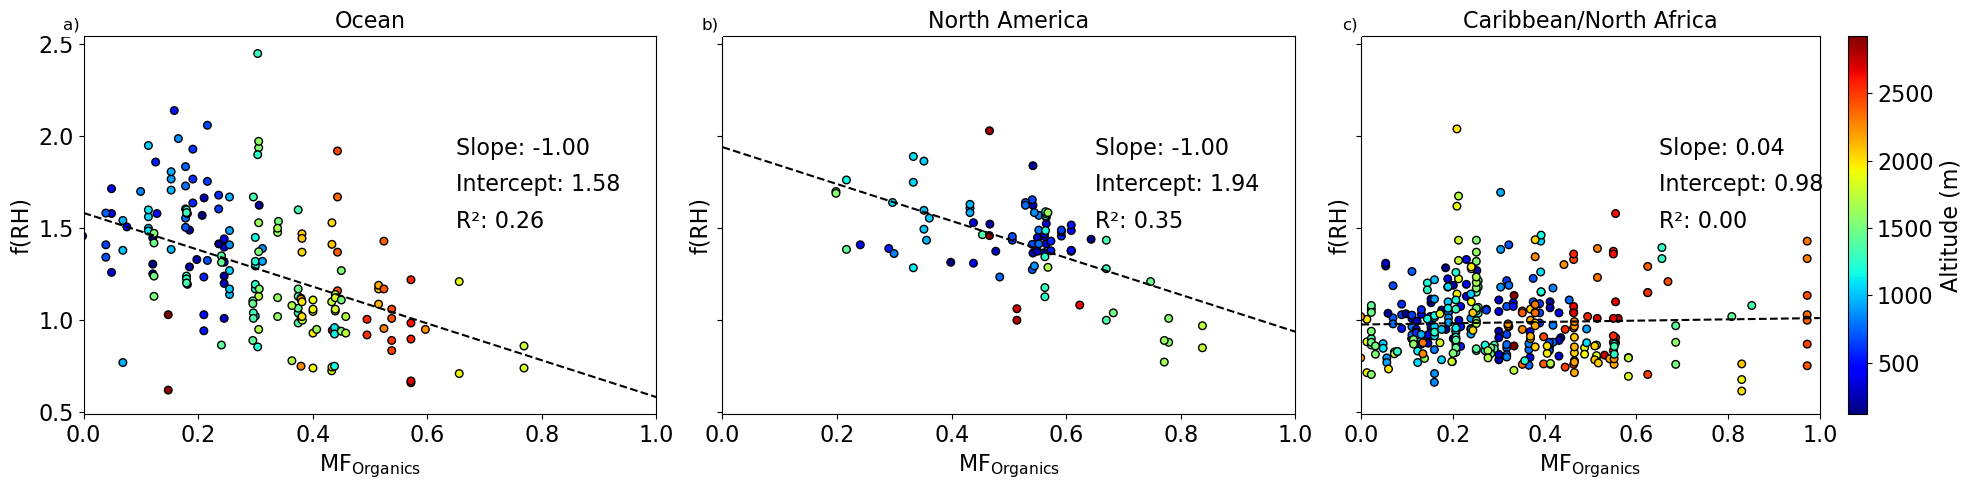

In [88]:
def create_scatter_plot(ax, data, title, x_label, y_label, legend_handles, show_colorbar=False):
    data_cleaned = data.dropna(subset=['fRH550_RH20to80_ZIEMBA', 'Org_Ave_IsoK_STP_ZIEMBA', 'mz44', 'GPS_Altitude_THORNHILL'])
    scatter = ax.scatter(data_cleaned['Org_Ave_IsoK_STP_ZIEMBA'], data_cleaned['fRH550_RH20to80_ZIEMBA'], c=data_cleaned['GPS_Altitude_THORNHILL'], s=30, cmap='jet', marker='o', edgecolors='black')

    # Perform linear regression to get the trendline
    X = data_cleaned['Org_Ave_IsoK_STP_ZIEMBA'].values.reshape(-1, 1)
    y = data_cleaned['fRH550_RH20to80_ZIEMBA'].values
    reg = LinearRegression().fit(X, y)

    # Plot the trendline
    x_fit = np.linspace(0., 1, 100)
    y_fit = reg.predict(x_fit.reshape(-1, 1))
    ax.plot(x_fit, y_fit, color='k', linestyle='--', label=f'Trendline: y = {reg.coef_[0]:.2f}x + {reg.intercept_:.2f}')
    
    # Add text annotations for intercept and regression values
    intercept_text = f'Intercept: {reg.intercept_:.2f}'
    slope_text = f'Slope: {reg.coef_[0]:.2f}'
    
    # Calculate R-squared value
    r_squared = reg.score(X, y)
    r_squared_text = f'R²: {r_squared:.2f}'
    ax.text(0.65, 1.5, r_squared_text, fontsize=16, color='k')
    ax.text(0.65, 1.7, intercept_text, fontsize=16, color='k')
    ax.text(0.65, 1.9, slope_text, fontsize=16, color='k')

    # Set the title and labels for the axes
    ax.set_title(title, fontsize=16)
    ax.set_xlabel(x_label, fontsize=16)
    ax.set_ylabel(y_label, fontsize=16)

    # Create a colorbar if show_colorbar is True
    if show_colorbar:
        cbar = plt.colorbar(scatter, ax=ax, label='')
        cbar.ax.tick_params(labelsize=16)
        cbar.ax.set_ylabel('Altitude (m)', fontsize=16) 

    # Set tick label sizes for both x and y axes
    ax.tick_params(axis='both', labelsize=16)
    ax.set_xlim(0,1)

    # Add the custom legends to the plot
    #ax.legend()

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 5), sharey = True)

# Labels for the subplots
labels = ['a)', 'b)', 'c)']

# Create legend handles for all subplots (you need to define these legend handles earlier in your code)

# Create subplots using the existing code and labels
create_scatter_plot(axes[0], ocean_transport, 'Ocean', r'$\mathrm{MF_{Organics}}$', 'f(RH)', legend_handles_ocean, show_colorbar=False)
create_scatter_plot(axes[1], North_America_transport, 'North America', r'$\mathrm{MF_{Organics}}$', 'f(RH)', legend_handles_north_america, show_colorbar=False)
create_scatter_plot(axes[2], Caribbean_transport, 'Caribbean/North Africa', r'$\mathrm{MF_{Organics}}$', 'f(RH)', legend_handles_caribbean, show_colorbar=True)

# Labels for subplots
for i, ax in enumerate(axes):
    trans = ScaledTranslation(-0.15, 0, fig.dpi_scale_trans)
    ax.text(
        -0.01, 1.05, labels[i],
        transform=ax.transAxes + trans,
        fontsize='large', verticalalignment='top',
        bbox=dict(facecolor='1', edgecolor='none', pad=3.0)
    )

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()


In [ ]:
'''from matplotlib.transforms import ScaledTranslation

# Modify the create_scatter_plot function to remove "MF Organics" from x_label
# Modify the create_scatter_plot function to remove "MF Organics" from x_label for the first two subplots
def create_scatter_plot(ax, data, title, x_label, y_label, legend_handles):
    data_cleaned = data.dropna(subset=['fRH550_RH20to80_ZIEMBA', 'Org_Ave_IsoK_STP_ZIEMBA', 'mz44', 'GPS_Altitude_THORNHILL'])
    scatter = ax.scatter(data_cleaned['Org_Ave_IsoK_STP_ZIEMBA'], data_cleaned['fRH550_RH20to80_ZIEMBA'], c=data_cleaned['GPS_Altitude_THORNHILL'], s=(40000 * (data_cleaned['mz44']**3)), cmap='jet', marker='o', edgecolors='black')

    # Perform linear regression to get the trendline
    X = data_cleaned['Org_Ave_IsoK_STP_ZIEMBA'].values.reshape(-1, 1)
    y = data_cleaned['fRH550_RH20to80_ZIEMBA'].values
    reg = LinearRegression().fit(X, y)

    # Plot the trendline
    x_fit = np.linspace(0.2, 1, 100)
    y_fit = reg.predict(x_fit.reshape(-1, 1))
    ax.plot(x_fit, y_fit, color='k', linestyle='--', label=f'Trendline: y = {reg.coef_[0]:.2f}x + {reg.intercept_:.2f}')
    
    # Add text annotations for intercept and regression values
    intercept_text = f'Intercept: {reg.intercept_:.2f}'
    slope_text = f'Slope: {reg.coef_[0]:.2f}'
    
    # Calculate R-squared value
    r_squared = reg.score(X, y)
    r_squared_text = f'R²: {r_squared:.2f}'
    ax.text(0.8, 1.11, r_squared_text, fontsize=12, color='k')
    ax.text(0.8, 1.19, intercept_text, fontsize=12, color='k')
    ax.text(0.8, 1.27, slope_text, fontsize=12, color='k')

    # Set the title and labels for the axes
    ax.set_title(title, fontsize=16)
    
    # Conditionally remove x-axis label for the first two subplots
    if ax in (axes[0, 0], axes[0, 1]):
        ax.set_xlabel('')
    else:
        ax.set_xlabel(x_label, fontsize=16)
    
    ax.set_ylabel(y_label, fontsize=16)

    # Create a colorbar
    cbar = plt.colorbar(scatter, ax=ax, label='')
    cbar.ax.set_ylabel('Altitude (m)', fontsize=16) 
    cbar.ax.tick_params(labelsize=12)

    # Set tick label sizes for both x and y axes
    ax.tick_params(axis='both', labelsize=12)

    # Add the custom legends to the plot
    ax.legend(handles=legend_handles)




# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 12), sharex = True)

# Labels for the subplots
labels = ['a)', 'b)', 'c)', 'd)']

# Create legend handles for all subplots
# (Assuming you have defined these legend handles earlier)

# Create subplots using the existing code and labels
create_scatter_plot(axes[0, 0], ocean_transport, 'Ocean', 'Organics', 'f(RH)', legend_handles_ocean)  # Removed "MF" from x_label
create_scatter_plot(axes[0, 1], North_America_transport, 'North America', 'Organics', 'f(RH)', legend_handles_north_america)  # Removed "MF" from x_label
create_scatter_plot(axes[1, 0], Caribbean_transport, 'Caribbean', r'$\mathrm{MF_{Organics}}$', 'f(RH)', legend_handles_caribbean)
create_scatter_plot(axes[1, 1], Africa_transport, 'North Africa', r'$\mathrm{MF_{Organics}}$', 'f(RH)', legend_handles_africa)

# Labels for subplots
for i, ax in enumerate(axes.flat):
    trans = ScaledTranslation(10 / 72, -5 / 72, fig.dpi_scale_trans)
    ax.text(
        -0.01, 1.05, labels[i],
        transform=ax.transAxes + trans,
        fontsize='large', verticalalignment='top',
        bbox=dict(facecolor='1', edgecolor='none', pad=3.0)
    )

# Adjust spacing between subplots
fig.tight_layout()

# Display the plot
plt.show()'''


'from matplotlib.transforms import ScaledTranslation\n\n# Modify the create_scatter_plot function to remove "MF Organics" from x_label\n# Modify the create_scatter_plot function to remove "MF Organics" from x_label for the first two subplots\ndef create_scatter_plot(ax, data, title, x_label, y_label, legend_handles):\n    data_cleaned = data.dropna(subset=[\'fRH550_RH20to80_ZIEMBA\', \'Org_Ave_IsoK_STP_ZIEMBA\', \'mz44\', \'GPS_Altitude_THORNHILL\'])\n    scatter = ax.scatter(data_cleaned[\'Org_Ave_IsoK_STP_ZIEMBA\'], data_cleaned[\'fRH550_RH20to80_ZIEMBA\'], c=data_cleaned[\'GPS_Altitude_THORNHILL\'], s=(40000 * (data_cleaned[\'mz44\']**3)), cmap=\'jet\', marker=\'o\', edgecolors=\'black\')\n\n    # Perform linear regression to get the trendline\n    X = data_cleaned[\'Org_Ave_IsoK_STP_ZIEMBA\'].values.reshape(-1, 1)\n    y = data_cleaned[\'fRH550_RH20to80_ZIEMBA\'].values\n    reg = LinearRegression().fit(X, y)\n\n    # Plot the trendline\n    x_fit = np.linspace(0.2, 1, 100)\n    y_

In [ ]:
''''# Modify the create_scatter_plot function to conditionally remove the y-axis label for the second and last subplot
def create_scatter_plot(ax, data, title, x_label, y_label, legend_handles):
    data_cleaned = data.dropna(subset=['fRH550_RH20to80_ZIEMBA', 'Org_Ave_IsoK_STP_ZIEMBA', 'mz44', 'GPS_Altitude_THORNHILL'])
    scatter = ax.scatter(data_cleaned['Org_Ave_IsoK_STP_ZIEMBA'], data_cleaned['fRH550_RH20to80_ZIEMBA'], c=data_cleaned['GPS_Altitude_THORNHILL'], s=(40000 * (data_cleaned['mz44']**3)), cmap='jet', marker='o', edgecolors='black')

    # Perform linear regression to get the trendline
    X = data_cleaned['Org_Ave_IsoK_STP_ZIEMBA'].values.reshape(-1, 1)
    y = data_cleaned['fRH550_RH20to80_ZIEMBA'].values
    reg = LinearRegression().fit(X, y)

    # Plot the trendline
    x_fit = np.linspace(0.2, 1, 100)
    y_fit = reg.predict(x_fit.reshape(-1, 1))
    ax.plot(x_fit, y_fit, color='k', linestyle='--', label=f'Trendline: y = {reg.coef_[0]:.2f}x + {reg.intercept_:.2f}')
    
    # Add text annotations for intercept and regression values
    intercept_text = f'Intercept: {reg.intercept_:.2f}'
    slope_text = f'Slope: {reg.coef_[0]:.2f}'
    
    # Calculate R-squared value
    r_squared = reg.score(X, y)
    r_squared_text = f'R²: {r_squared:.2f}'
    ax.text(0.7, 1.0, r_squared_text, fontsize=12, color='k')
    ax.text(0.7, 1.08, intercept_text, fontsize=12, color='k')
    ax.text(0.7, 1.15, slope_text, fontsize=12, color='k')

    # Set the title and labels for the axes
    ax.set_title(title, fontsize=16)
    
    # Conditionally remove x-axis label for the first two subplots
    if ax in (axes[0, 0], axes[0, 1]):
        ax.set_xlabel('')
    else:
        ax.set_xlabel(x_label, fontsize=16)
    
    # Conditionally remove y-axis label for the second and last subplot
    if ax in (axes[1, 0], axes[1, 1]):
        ax.set_ylabel('')
    else:
        ax.set_ylabel(y_label, fontsize=16)

    # Create a colorbar
    cbar = plt.colorbar(scatter, ax=ax, label='Altitude (m)')
    cbar.ax.tick_params(labelsize=16)  # Increase the fontsize for the colorbar label

    # Set tick label sizes for both x and y axes
    ax.tick_params(axis='both', labelsize=12)

    # Add the custom legends to the plot
    ax.legend(handles=legend_handles)


# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Labels for the subplots
labels = ['a) Ocean', 'b) North America', 'c) Caribbean', 'd) North Africa']

# Create legend handles for all subplots
# (Assuming you have defined these legend handles earlier)

# Create subplots using the existing code and labels
create_scatter_plot(axes[0, 0], ocean_transport, '', 'Organics', 'f(RH)', legend_handles_ocean)  # Removed "MF" from x_label
create_scatter_plot(axes[0, 1], North_America_transport, '', 'Organics', 'f(RH)', legend_handles_north_america)  # Removed "MF" from x_label
create_scatter_plot(axes[1, 0], Caribbean_transport, '', r'$\mathrm{MF_{Organics}}$', 'f(RH)', legend_handles_caribbean)
create_scatter_plot(axes[1, 1], Africa_transport, '', r'$\mathrm{MF_{Organics}}$', 'f(RH)', legend_handles_africa)

# Labels for subplots
for i, ax in enumerate(axes.flat):
    trans = ScaledTranslation(10 / 72, -5 / 72, fig.dpi_scale_trans)
    ax.text(
        -0.01, 1.05, labels[i],
        transform=ax.transAxes + trans,
        fontsize='large', verticalalignment='top',
        bbox=dict(facecolor='1', edgecolor='none', pad=3.0)
    )

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()'''


'\'# Modify the create_scatter_plot function to conditionally remove the y-axis label for the second and last subplot\ndef create_scatter_plot(ax, data, title, x_label, y_label, legend_handles):\n    data_cleaned = data.dropna(subset=[\'fRH550_RH20to80_ZIEMBA\', \'Org_Ave_IsoK_STP_ZIEMBA\', \'mz44\', \'GPS_Altitude_THORNHILL\'])\n    scatter = ax.scatter(data_cleaned[\'Org_Ave_IsoK_STP_ZIEMBA\'], data_cleaned[\'fRH550_RH20to80_ZIEMBA\'], c=data_cleaned[\'GPS_Altitude_THORNHILL\'], s=(40000 * (data_cleaned[\'mz44\']**3)), cmap=\'jet\', marker=\'o\', edgecolors=\'black\')\n\n    # Perform linear regression to get the trendline\n    X = data_cleaned[\'Org_Ave_IsoK_STP_ZIEMBA\'].values.reshape(-1, 1)\n    y = data_cleaned[\'fRH550_RH20to80_ZIEMBA\'].values\n    reg = LinearRegression().fit(X, y)\n\n    # Plot the trendline\n    x_fit = np.linspace(0.2, 1, 100)\n    y_fit = reg.predict(x_fit.reshape(-1, 1))\n    ax.plot(x_fit, y_fit, color=\'k\', linestyle=\'--\', label=f\'Trendline: y = {r